# Project description

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. I'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

I have used BERT embeddings below, but I've run it on a separate computer with a GPU and I'm just loading the embeddings here from a file.

## Initialization

In [128]:
# import needed packages
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm.auto import tqdm
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display

# import machine learning and language packages
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import torch
import transformers
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import f1_score
import lightgbm as lgb
from lightgbm import LGBMClassifier
import optuna

In [2]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

In [3]:
# download stopwords and other data nltk needs
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eyalw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eyalw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eyalw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\eyalw\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Set environment variables

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [5]:
# set to display all output not only print() or last output
InteractiveShell.ast_node_interactivity = "all"

# set display all columns when showing dataframes
pd.options.display.max_columns = None

## Load Data

In [6]:
# load needed files, try/except to differentiate between running at home or on yandex jupyterhub
try:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## Pre-process

### Look at input

In [7]:
# display basic information about the dataframes we use
df_reviews.info()
df_reviews.describe()
df_reviews.describe(include=[object])
df_reviews.head(10)
df_reviews.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

start_year      is_adult  average_rating         votes        rating  \
count  47331.000000  47331.000000    47329.000000  4.732900e+04  47331.000000   
mean    1989.631235      0.001732        5.998278  2.556292e+04      5.484608   
std       19.600364      0.041587        1.494289  8.367004e+04      3.473109   
min     1894.000000      0.000000        1.400000  9.000000e+00      1.000000   
25%     1982.000000      0.000000        5.100000  8.270000e+02      2.000000   
50%     1998.000000      0.000000        6.300000  3.197000e+03      4.000000   
75%     2004.000000      0.000000        7.100000  1.397400e+04      9.000000   
max     2010.000000      1.000000        9.700000  1.739448e+06     10.000000   

                pos           idx  
count  47331.000000  47331.000000  
mean       0.498954   6279.697999  
std        0.500004   3605.702545  
min        0.000000      0.000000  
25%        0.000000   3162.000000  
50%        0.000000   6299.000000  
75%        1.000000   9412.000000  
max        1.000000  12499.000000

tconst title_type primary_title original_title end_year  \
count       47331      47331         47331          47331    47331   
unique       6648         10          6555           6562       60   
top     tt0067445      movie  The Sentinel   The Sentinel       \N   
freq           30      36861            60             60    45052   

       runtime_minutes genres  \
count            47331  47331   
unique             249    585   
top                 90  Drama   
freq              2442   3392   

                                                   review     sp ds_part  
count                                               47331  47331   47331  
unique                                              47240      2       2  
top     Loved today's show!!! It was a variety and not...    neg   train  
freq                                                    5  23715   23796

tconst title_type                                      primary_title  \
0  tt0068152      movie                                                  $   
1  tt0068152      movie                                                  $   
2  tt0313150      short                                               '15'   
3  tt0313150      short                                               '15'   
4  tt0313150      short                                               '15'   
5  tt0313150      short                                               '15'   
6  tt0313150      short                                               '15'   
7  tt0035958      movie  'Gung Ho!': The Story of Carlson's Makin Islan...   
8  tt0035958      movie  'Gung Ho!': The Story of Carlson's Makin Islan...   
9  tt0035958      movie  'Gung Ho!': The Story of Carlson's Makin Islan...   

                                      original_title  start_year end_year  \
0                                                  $        1971       \N   
1                                                  $        1971       \N   
2                                               '15'        2002       \N   
3                                               '15'        2002       \N   
4                                               '15'        2002       \N   
5                                               '15'        2002       \N   
6                                               '15'        2002       \N   
7  'Gung Ho!': The Story of Carlson's Makin Islan...        1943       \N   
8  'Gung Ho!': The Story of Carlson's Makin Islan...        1943       \N   
9  'Gung Ho!': The Story of Carlson's Makin Islan...        1943       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   
5              25         0  Comedy,Drama,Short             6.3    184   
6              25         0  Comedy,Drama,Short             6.3    184   
7              88         0   Drama,History,War             6.1   1240   
8              88         0   Drama,History,War             6.1   1240   
9              88         0   Drama,History,War             6.1   1240   

                                              review  rating   sp  pos  \
0  The pakage implies that Warren Beatty and Gold...       1  neg    0   
1  How the hell did they get this made?! Presenti...       1  neg    0   
2  There is no real story the film seems more lik...       3  neg    0   
3  Um .... a serious film about troubled teens in...       7  pos    1   
4  I'm totally agree with GarryJohal from Singapo...       9  pos    1   
5  This is the first movie I've seen from Singapo...       9  pos    1   
6  Yes non-Singaporean's can't see what's the big...       9  pos    1   
7  This true story of Carlson's Raiders is more o...       2  neg    0   
8  Should have been titled 'Balderdash!' Little i...       2  neg    0   
9  The movie 'Gung Ho!': The Story of Carlson's M...       4  neg    0   

  ds_part   idx  
0   train  8335  
1   train  8336  
2    test  2489  
3    test  9280  
4    test  9281  
5    test  9282  
6    test  9283  
7   train  9903  
8   train  9905  
9   train  9904

0

### Summary of first look

* The important columns are `review`, `pos` and `ds_part`, we can ignore the rest for the sake of our analysis.
* The `pos` column has a mean of 0.499, so the negative and positive reviews are close in number
* The `ds_part` has 23,796 train values and 47,331 total values, so our train/test split is about 50:50.
* Only 47240/47331 reviews are unique, so we have some duplicate reviews which is odd.

## EDA

Let's check the number of movies and reviews over years:

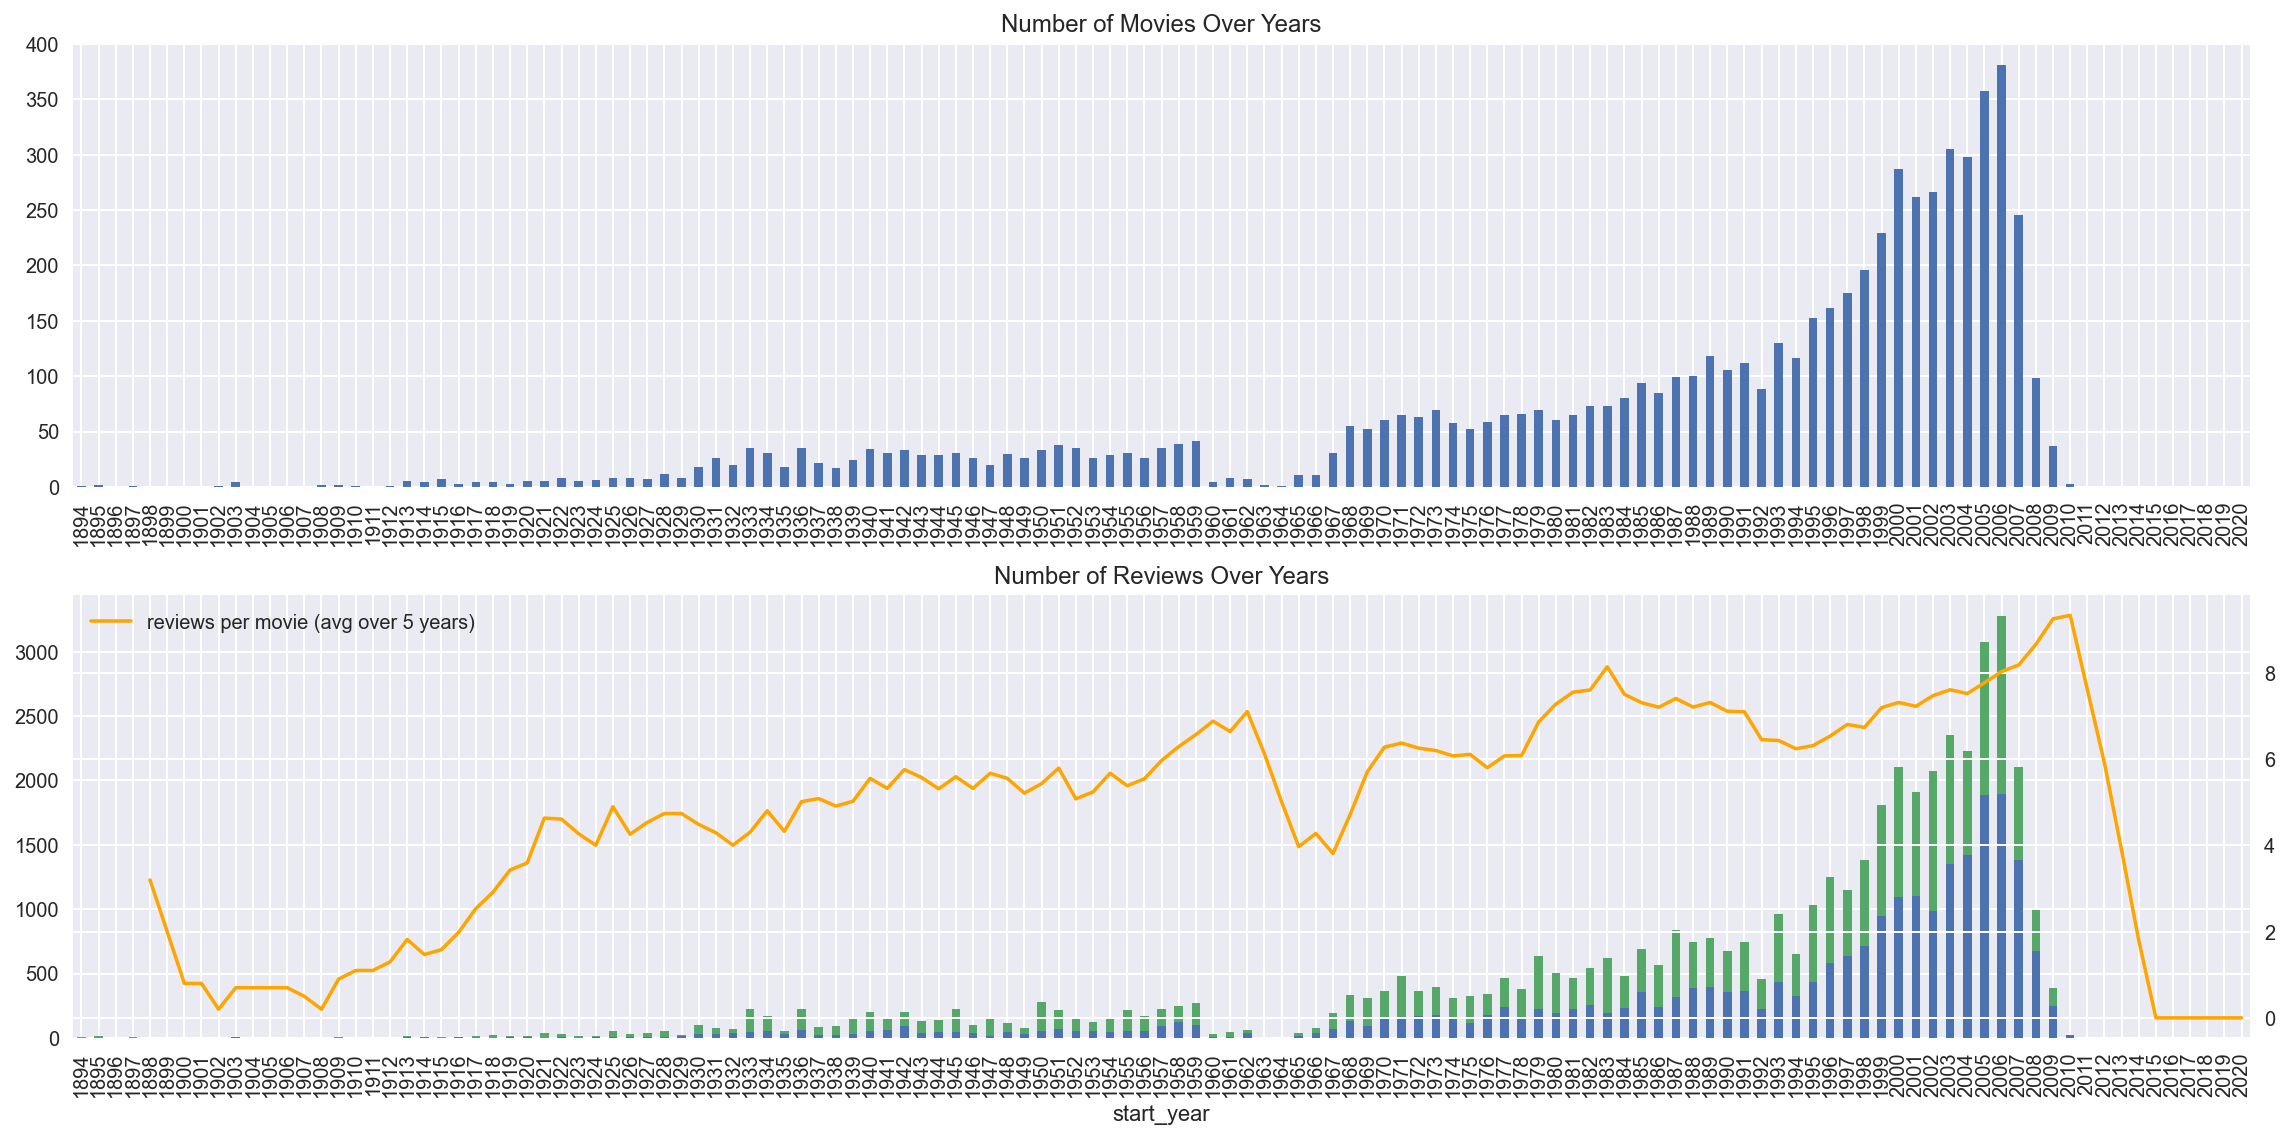

In [8]:
#create subplots
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# first subplot - number of movies per year
ax = axs[0]
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

# second subplot - number of reviews per year
ax = axs[1]
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

# add number of reviews/movie in the second subplot
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

# add legend
lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout();

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

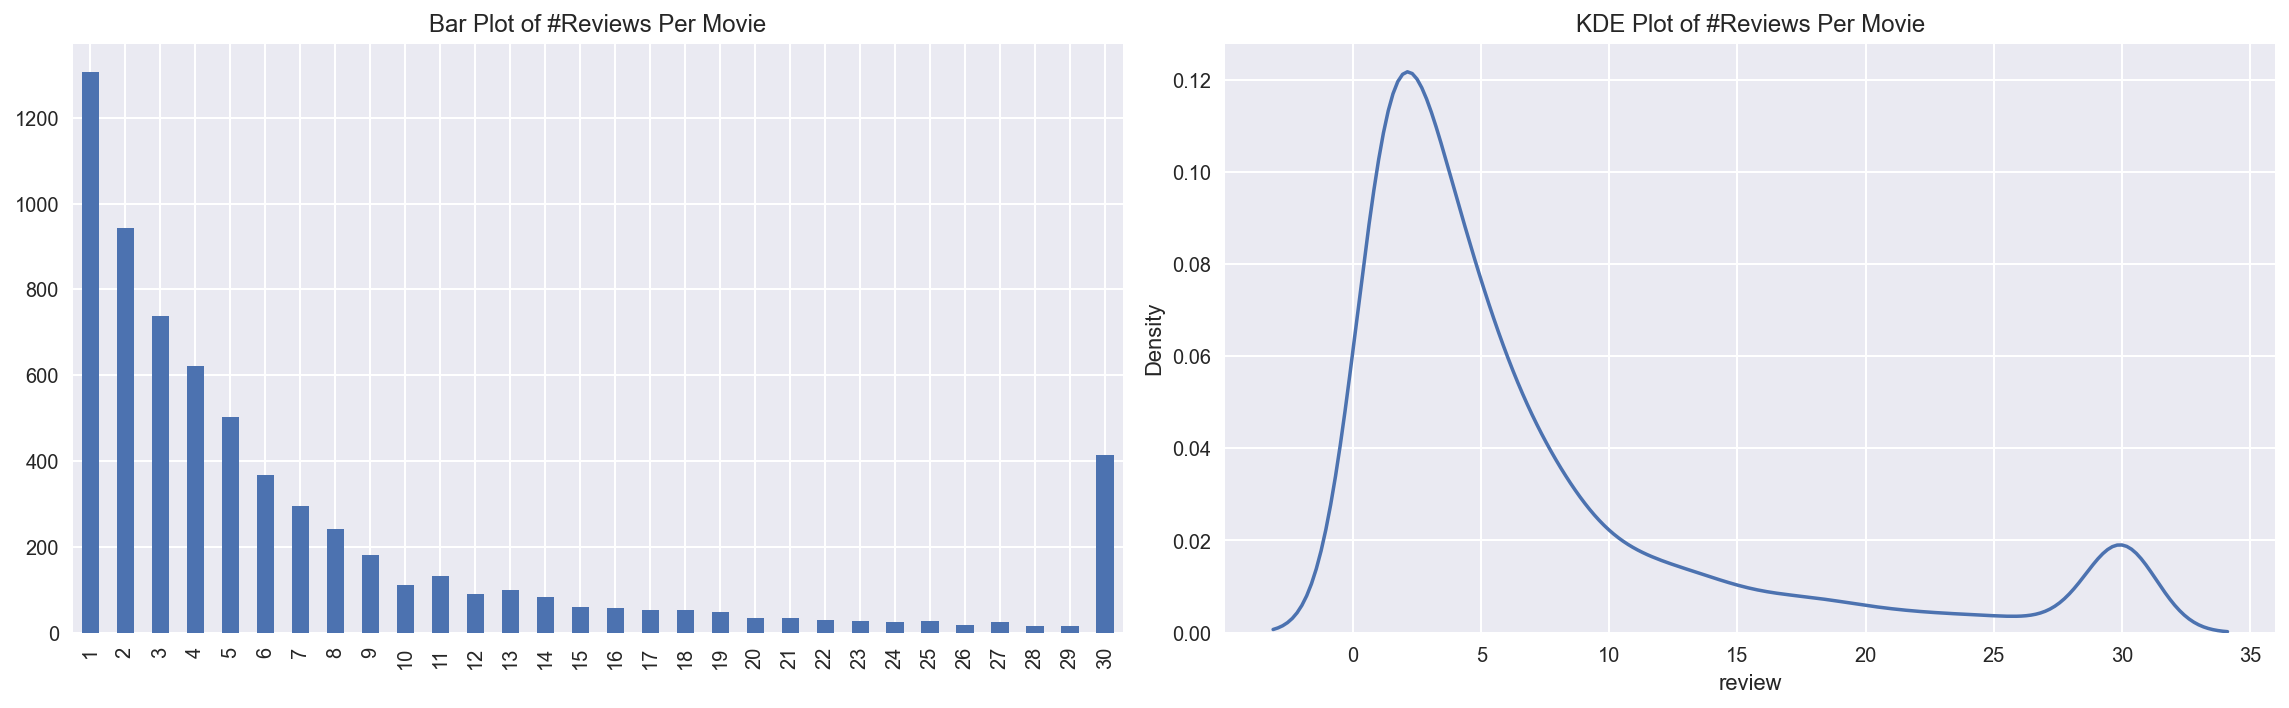

In [9]:
# create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# first subplot - histogram of reviews per movie
ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

# second subplot - KDE plot of reviews per movie
ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout();

I'll also compare the distribution of ratings between the train and test set:

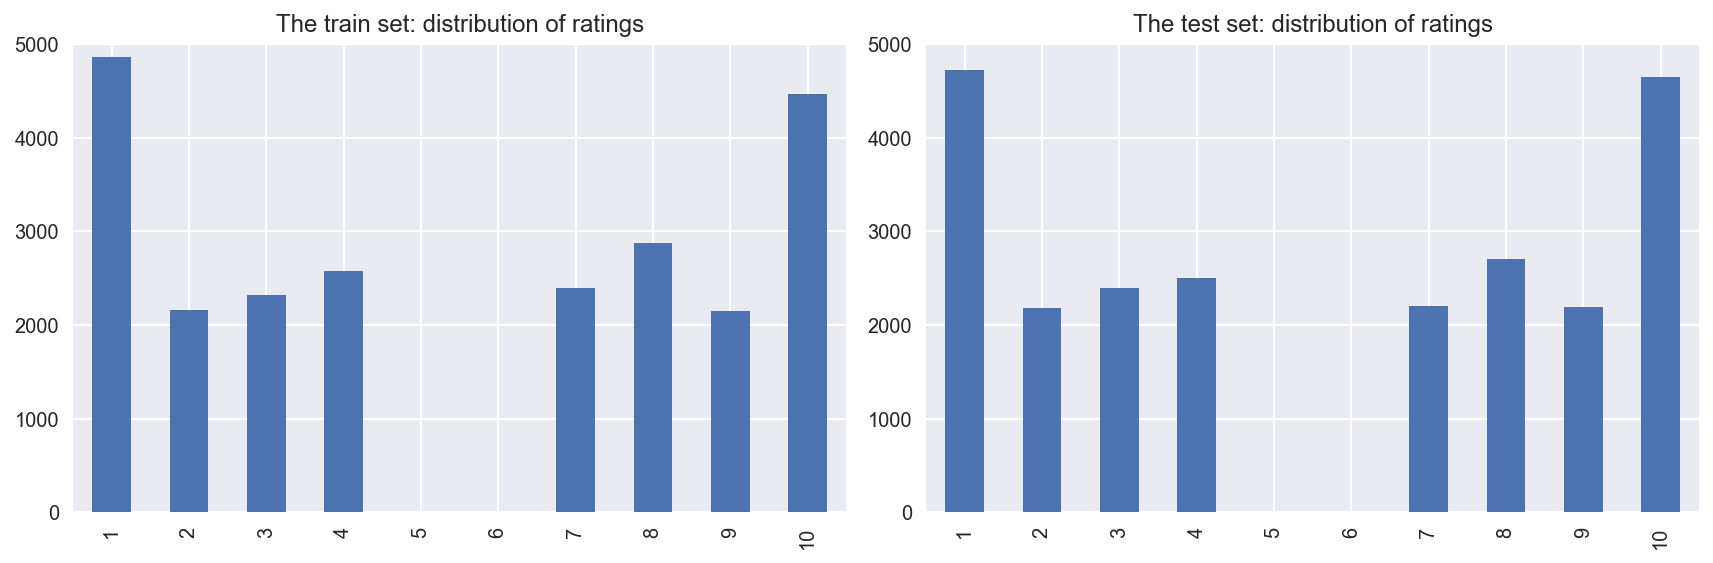

In [10]:
# create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# first subplot - train set distribution
ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

# second subplot - test set distribution
ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout();

Distribution of negative and positive reviews over the years for the two parts of the dataset:

C:\Miniconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Miniconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Miniconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Miniconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


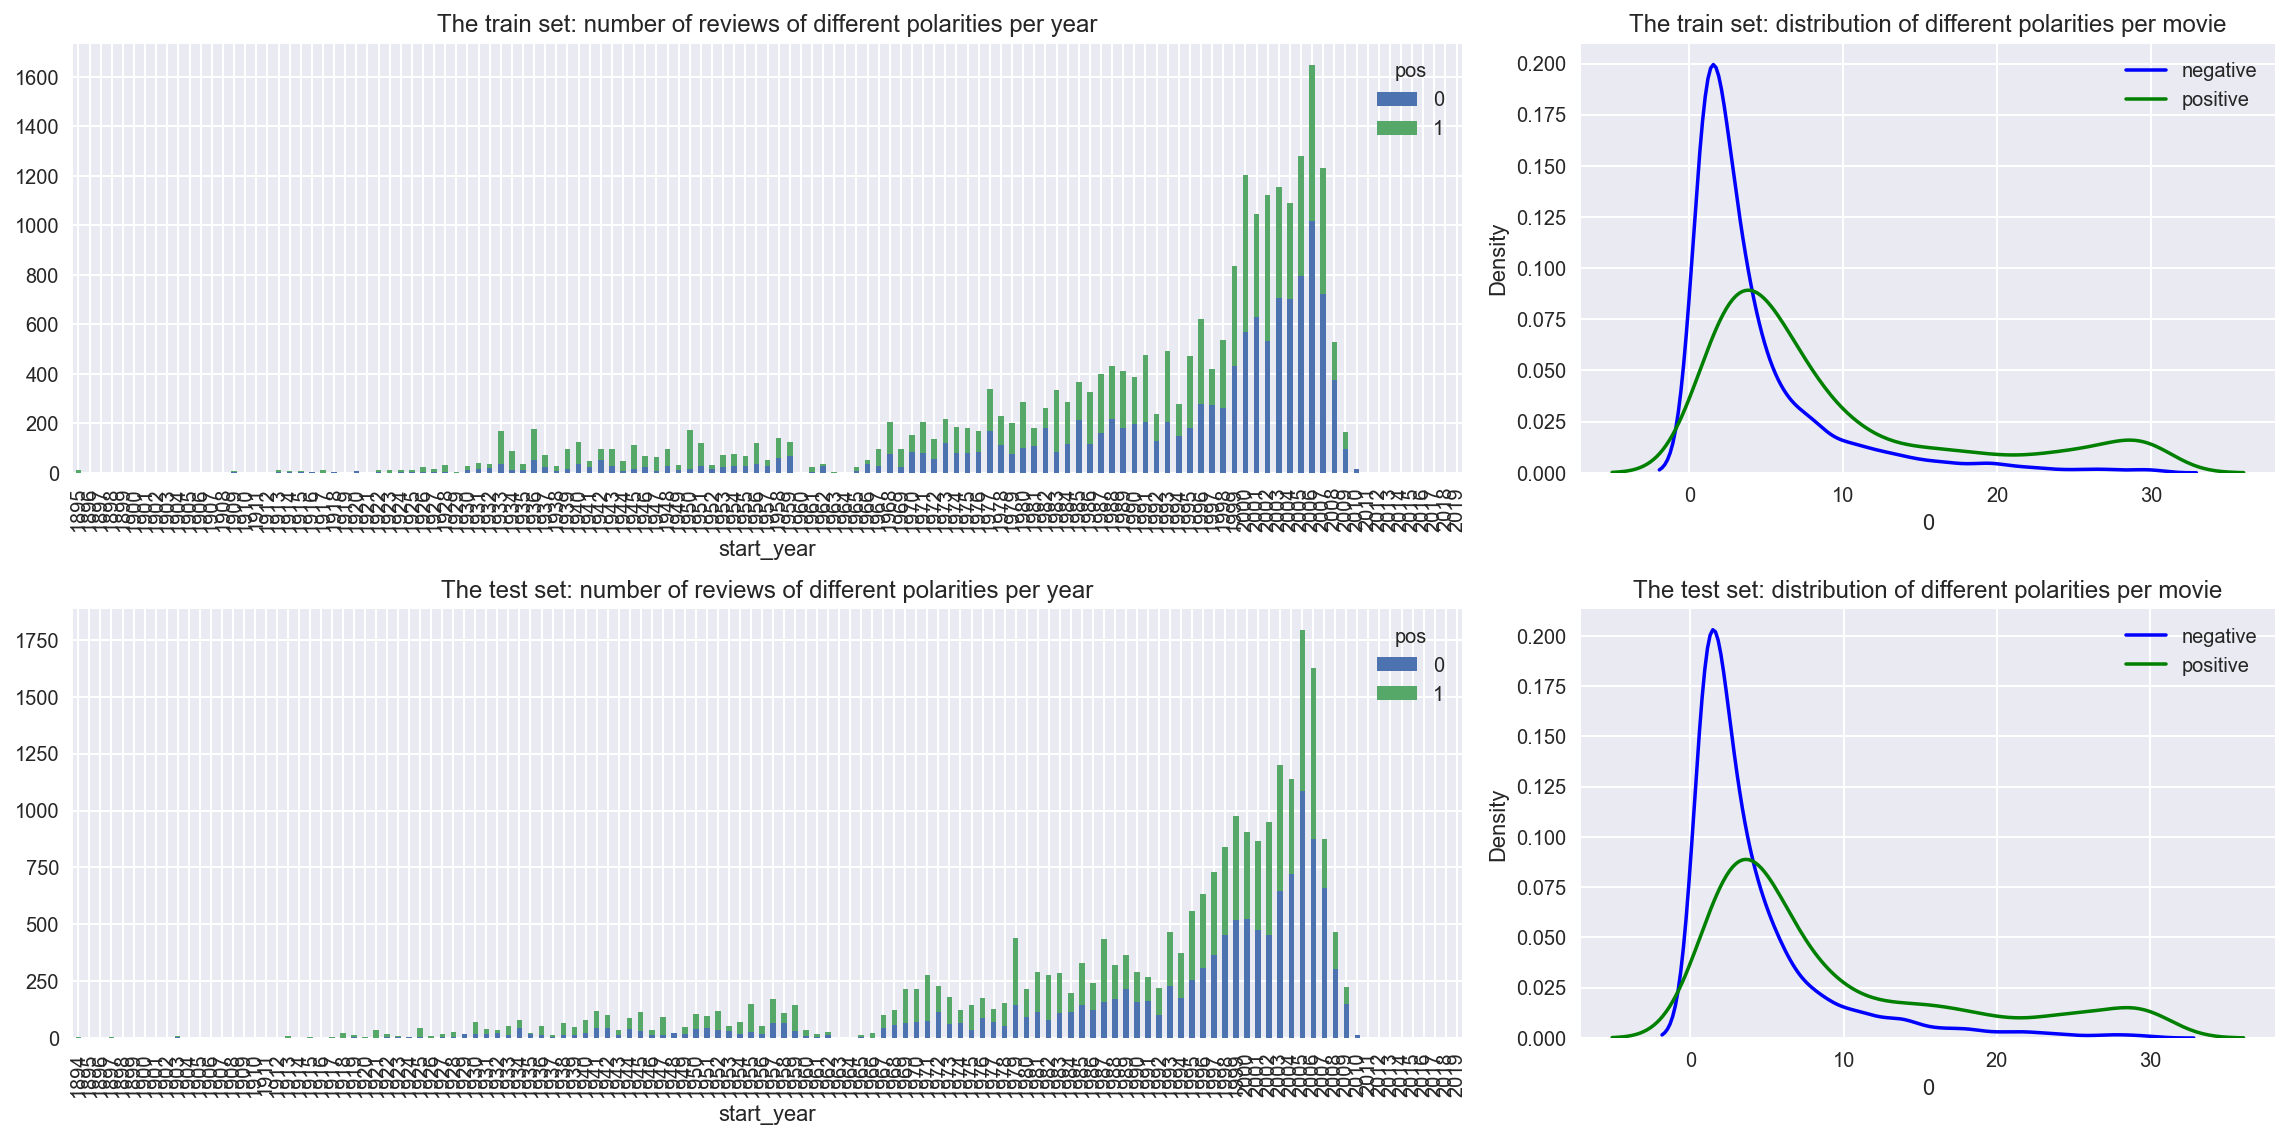

In [11]:
# create subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# subplot 0,0 - train set, reviews per year, pos vs neg
ax = axs[0][0]
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

# subplot 0,1 - train set, reviews per movie, pos vs neg
ax = axs[0][1]
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

# subplot 1,0 - test set, reviews per year, pos vs neg
ax = axs[1][0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

# subplot 0,1 - test set, reviews per movie, pos vs neg
ax = axs[1][1]
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout();

Now that we have looked in general at reviews for movies let's focus specifically on looking at class imbalance for our project:

In [12]:
# print percentages of positive and negative reviews in test vs train sets
100*df_reviews[['pos','ds_part', 'idx']].pivot_table(index='ds_part', columns='pos', aggfunc='count', margins=True)/df_reviews.shape[0]

idx                       
pos              0          1         All
ds_part                                  
test     24.937145  24.787137   49.724282
train    25.167438  25.108280   50.275718
All      50.104583  49.895417  100.000000

Based on the result above I do not think the dataset suffers from class imbalance, as we have a split of \~50:50 between test and train sets, and in each we have a split of \~50:50 between positive and negative reviews.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [13]:
# prepare metrics
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accept texts in lowercase and without any digits, punctuations marks etc.

In [14]:
# remove anything not letters, and lower the case
df_reviews['review_norm'] = df_reviews['review'].str.replace(r'[^a-zA-Z]', ' ', regex=True).str.lower()

# remove leading, trailing and consecutive whitespaces
df_reviews['review_norm'] = df_reviews['review_norm'].str.strip().replace(r'\s+',' ', regex=True)

I will also use lemmetization to generate a similar dataset but with lemmetized words as this is better for some of the models. I will perform this with both NLTK and spacy so we can compare.

In [15]:
# create NLTK lemmetizer object
lemmatizer = WordNetLemmatizer()

# define function that performs tokenization and lemmatizations
def lemmatize_text_nltk(text):
        
        # tokenize text
        tokens = word_tokenize(text)
        
        # lemmatize tokens
        lemmas = [lemmatizer.lemmatize(token) for token in tokens]
        
        # join everything back to one text
        return " ".join(lemmas)
    
# tokenize the whole column
df_reviews['review_norm_and_lemmatized_nltk'] = df_reviews['review_norm'].progress_apply(lemmatize_text_nltk)

  0%|          | 0/47331 [00:00<?, ?it/s]

In [16]:
# create spacy lemmatizer object
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# define function to tokenize/lemmatize based on spacy
def lemmatize_text_spacy(text):
    
    # tokenize text
    doc = nlp(text)
    
    # lemmatize tokens
    tokens = [token.lemma_ for token in doc]
    
    # join everything back to one text
    return ' '.join(tokens)

# tokenize the whole column
df_reviews['review_norm_and_lemmatized_spacy'] = df_reviews['review_norm'].progress_apply(lemmatize_text_spacy)

  0%|          | 0/47331 [00:00<?, ?it/s]

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_y = df_reviews_train['pos']
test_y = df_reviews_test['pos']

## Working with models

### Model 0 - Uniform

Since the classes in our dataset appear roughly in a 50:50 quantity, I will use the 'uniform' dummy classifier to predict either 0 or 1 as a sanity check model.

In [18]:
# define model
model_0 = DummyClassifier(strategy='uniform', random_state=13)

# fit to data
model_0.fit(df_reviews_train['review_norm'], train_y);

          train  test
Accuracy   0.49   0.5
F1         0.49   0.5
APS        0.50   0.5
ROC AUC    0.50   0.5


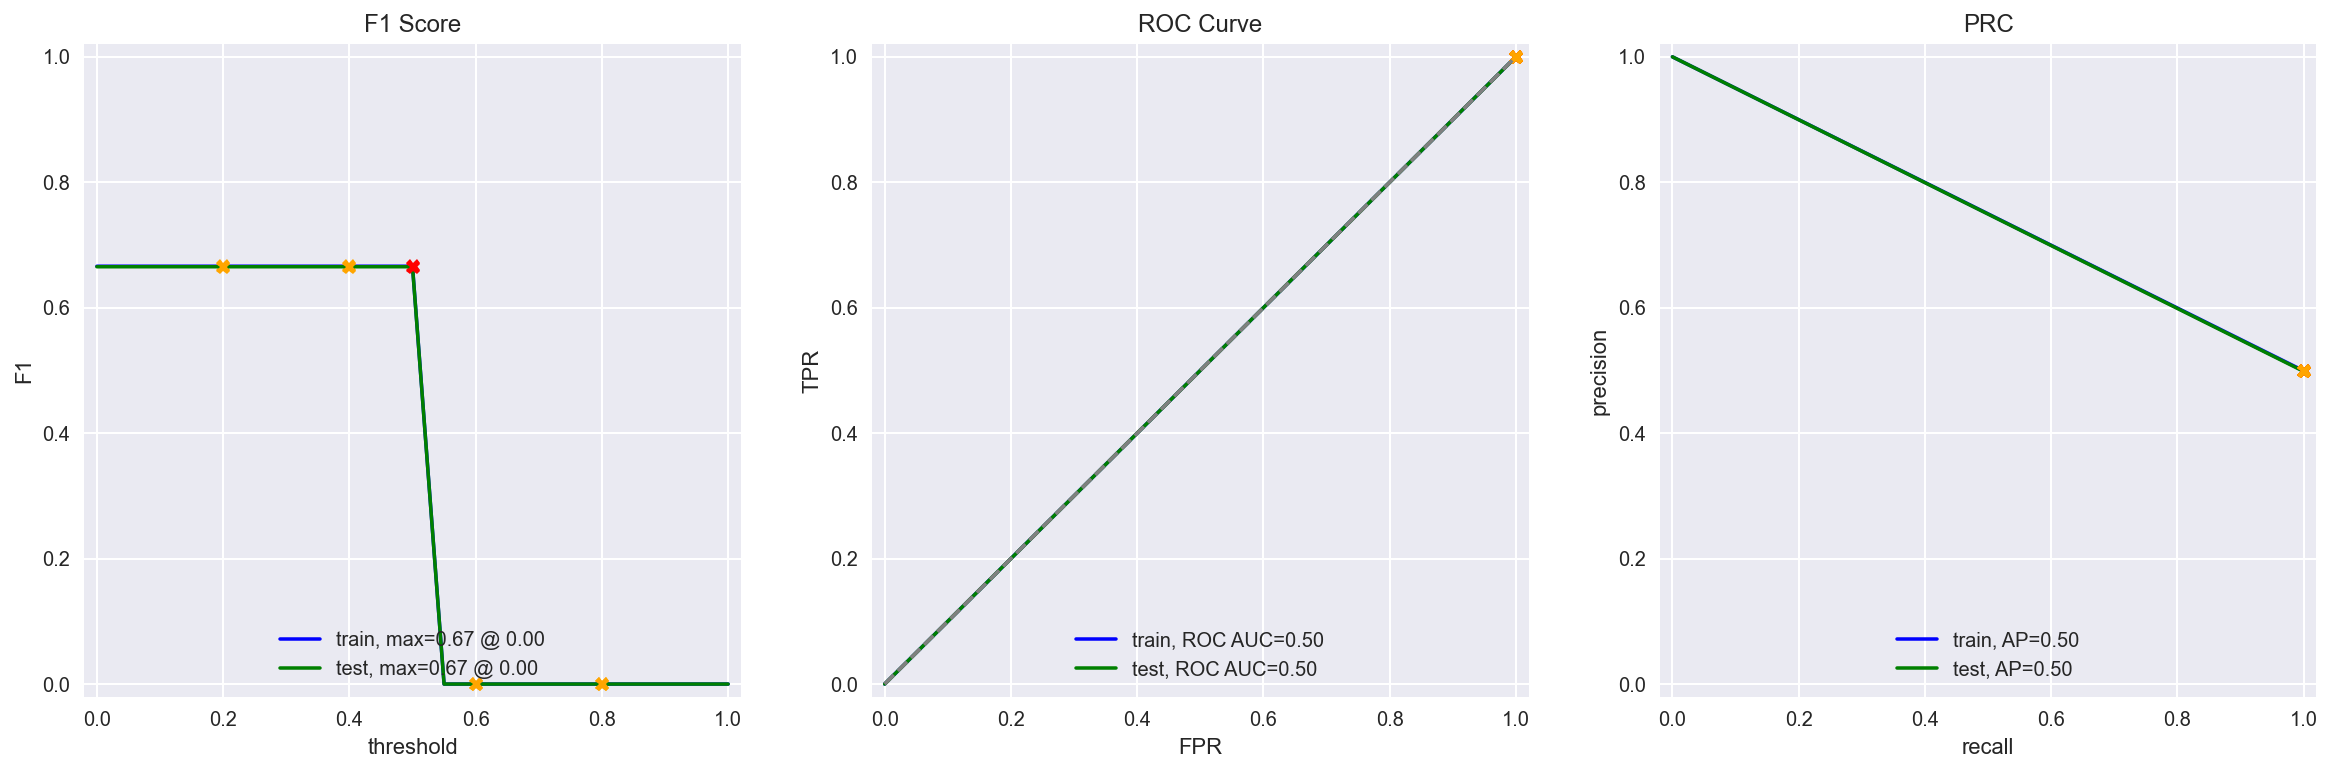

In [19]:
# evalutate the model
evaluate_model(model_0, df_reviews_train['review_norm'], train_y, df_reviews_test['review_norm'], test_y)

The model as expected is not better than a coin toss and returns an accuracy of \~0.5 and and F1 score of \~0.5.

### Model 1 - NLTK, TF-IDF and LR (with or without lemmatization)

I will use NLTK to exclude stopwords and TF-IDF to compute the feature space followed by a Logistic Regression model. As a comparison, I'll have model 1a (normalized) and model 1b (normalized and lemmatized) to see how lemmatization influences our model results. Lemmatization is also supplied by NLTK.

In [20]:
# define stopword language
stop_words = set(stopwords.words('english'))

# generate counter that excludes stopwords
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

# generate the features from the train corpus
tf_idf_train = count_tf_idf.fit_transform(df_reviews_train['review_norm'])

# transform the test corpus appropriately
tf_idf_test = count_tf_idf.transform(df_reviews_test['review_norm'])

In [21]:
# define model
model_1a = LogisticRegression()

# fit to data
model_1a.fit(tf_idf_train, train_y);

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


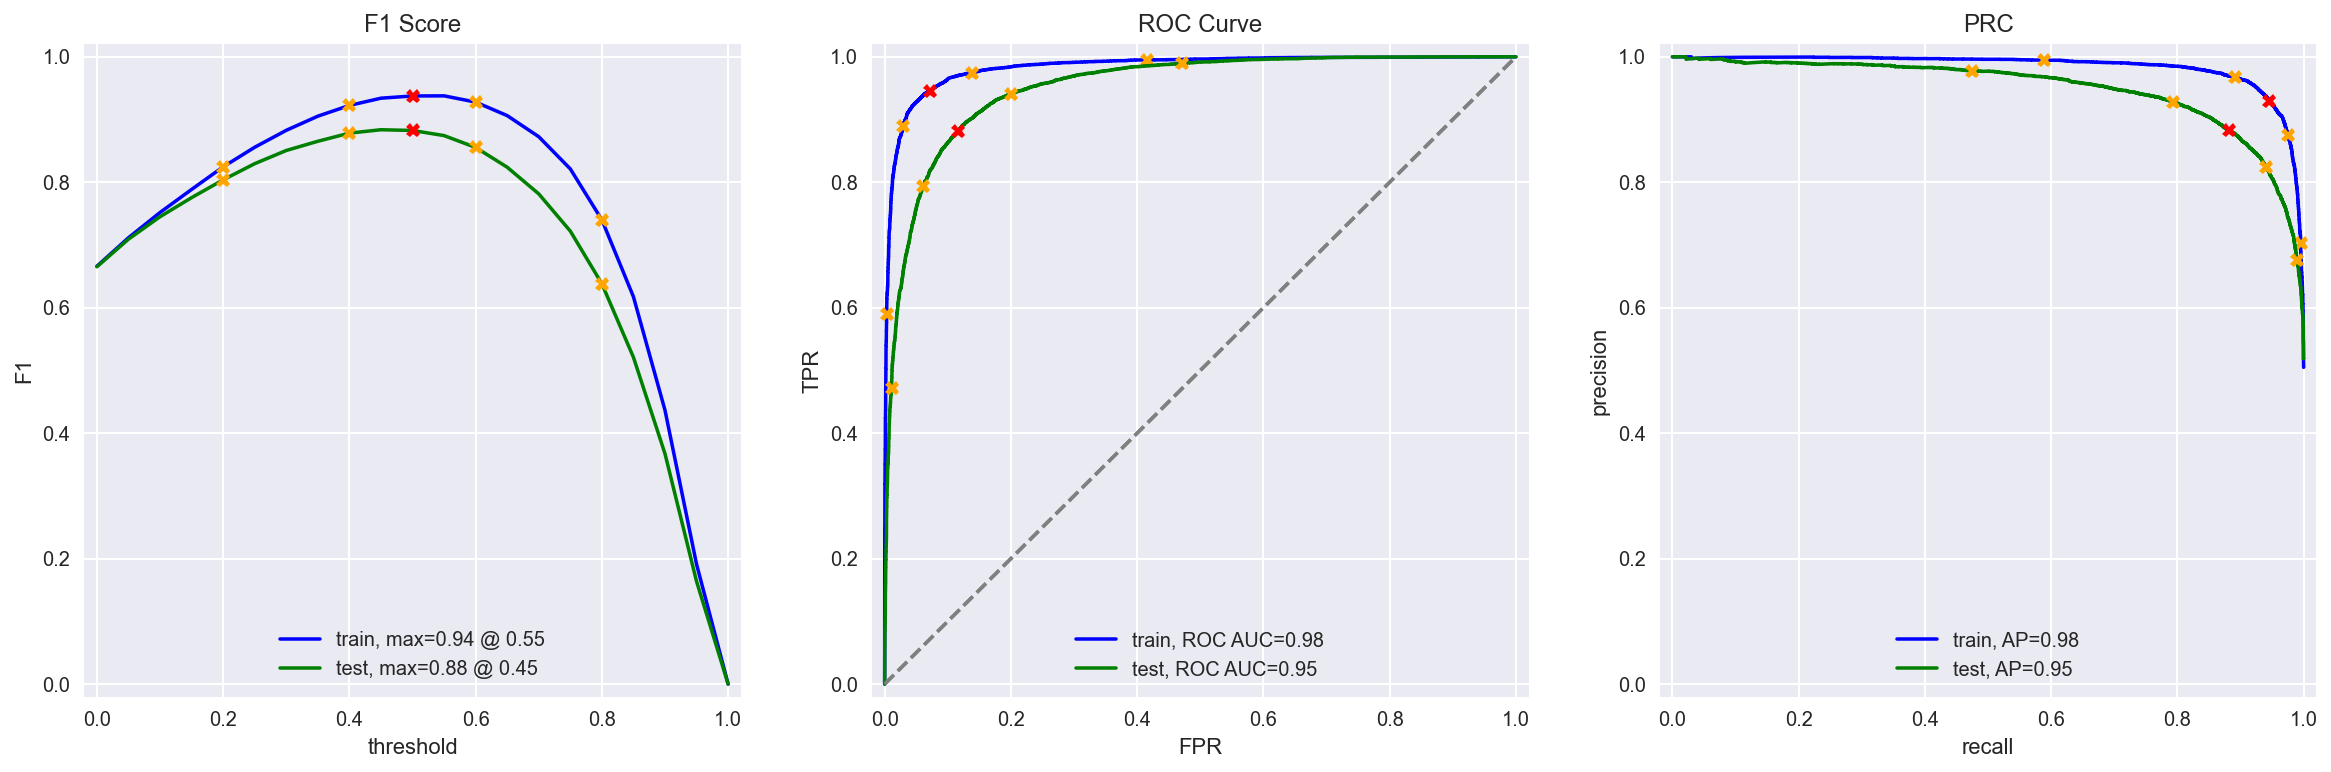

In [22]:
# evalutate the model
evaluate_model(model_1a, tf_idf_train, train_y, tf_idf_test, test_y)

A great improvement compared to the dummy classifier - we now have a 0.88 F1 score on the test set, let's see how lemmatization influences the results.

In [24]:
# generate the features from the train corpus
tf_idf_train_lemma = count_tf_idf.fit_transform(df_reviews_train['review_norm_and_lemmatized_nltk'])

# transform the test corpus appropriately
tf_idf_test_lemma = count_tf_idf.transform(df_reviews_test['review_norm_and_lemmatized_nltk'])

In [25]:
# define model
model_1b = LogisticRegression()

# fit to data
model_1b.fit(tf_idf_train_lemma, train_y);

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


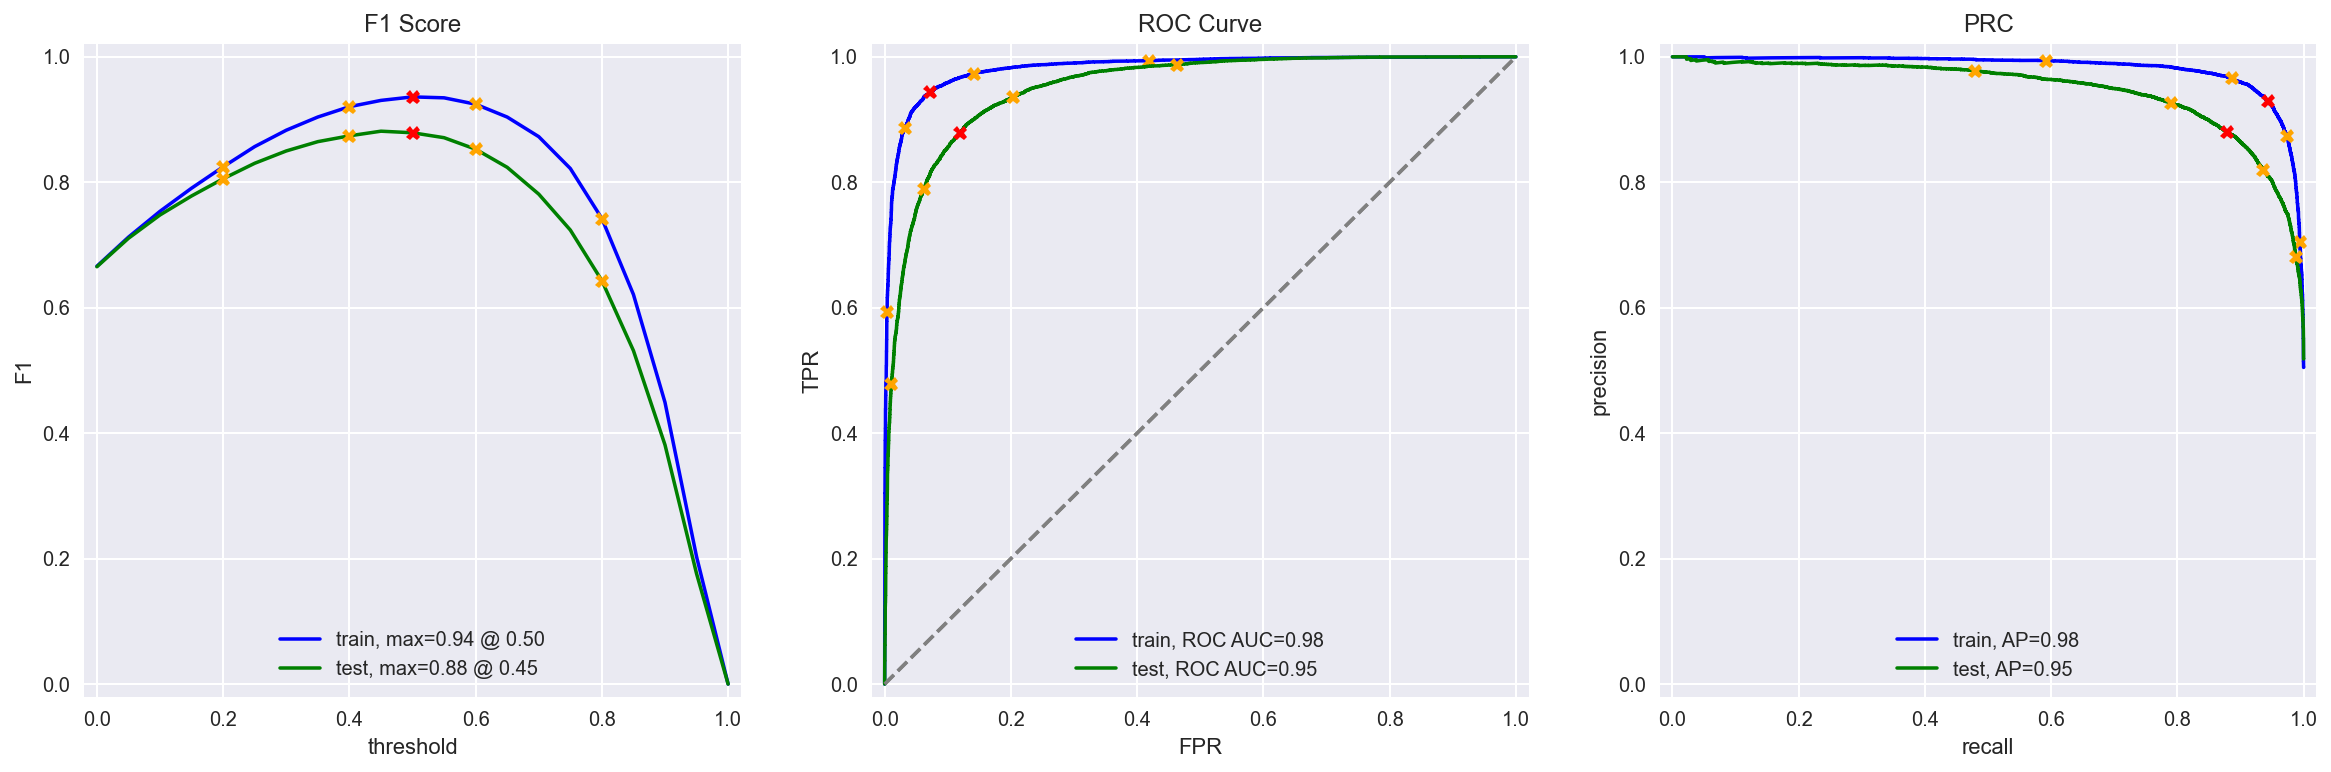

In [26]:
# evalutate the model
evaluate_model(model_1b, tf_idf_train_lemma, train_y, tf_idf_test_lemma, test_y)

It appears that the logistic regression model managed to get the same results with or without lemmatization.

### Model 2 - spaCy, TF-IDF and LR

Let's see if using a different platform for the lemmatization influences the results.

In [27]:
# generate the features from the train corpus
tf_idf_train_spacy = count_tf_idf.fit_transform(df_reviews_train['review_norm_and_lemmatized_spacy'])

# transform the test corpus appropriately
tf_idf_test_spacy = count_tf_idf.transform(df_reviews_test['review_norm_and_lemmatized_spacy'])

In [28]:
# define model
model_2 = LogisticRegression()

# fit to data
model_2.fit(tf_idf_train_spacy, train_y);

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


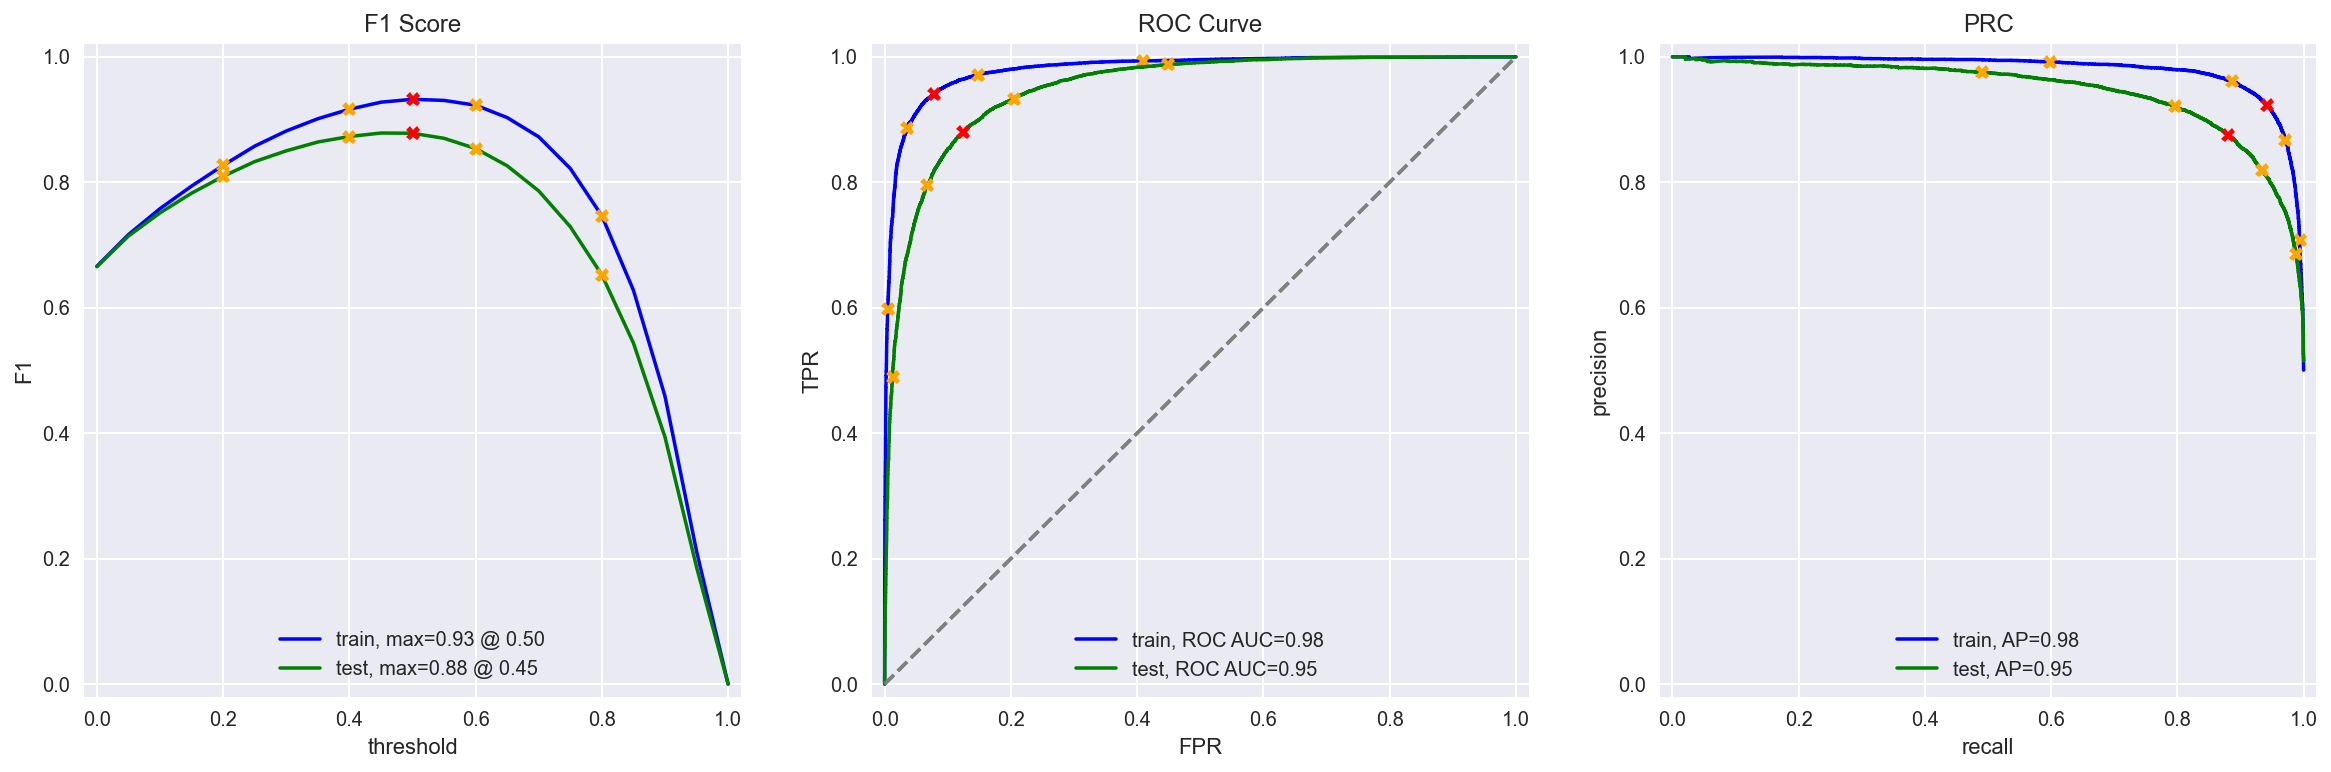

In [29]:
# evalutate the model
evaluate_model(model_2, tf_idf_train_spacy, train_y, tf_idf_test_spacy, test_y)

We still get the same kinds of results as previously seen using nltk. Seems like the logistic regression model is the main bottleneck at this point, so let's see more complex classification models.

### Model 3 - spaCy, TF-IDF and LGBMClassifier

We'll use the same features we prepared for the previous step based on spacy lemmatization and TF-IDF analysis, but with LGBMClassifier as the model that classifies results instead of Logistic regression. Since it has many hyperparameters we could tune I will perform some basic cross-validation looking for the optimal parameters.

In [38]:
# define model
model_3 = LGBMClassifier()

# define parameters for the gridsearchCV
param_lgbm = {'boosting_type' : ['gbdt', 'dart', 'goss'],
              'learning_rate' : [0.05, 0.1],
              'min_data_in_leaf' : [10, 100]}

# Perform the grid search cross validation
grid_lgbm = GridSearchCV(model_3, param_grid=param_lgbm, cv=4, scoring='f1', verbose=2, n_jobs=3)
results_lgbm = grid_lgbm.fit(tf_idf_train_spacy, train_y)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


In [42]:
# print resulting best score and parameters - RandomForestRegressor
print("\nLGBMRegressor() model:")
print('The best parameters across ALL searched params: \n   {}' .format(grid_lgbm.best_params_))
print('The best score across ALL searched params: {:.3f}' .format(grid_lgbm.best_score_))
cv_results_lgbm = pd.DataFrame.from_dict(results_lgbm.cv_results_)

# let's show the 10 best parameter combinations for lgbm 
cv_results_lgbm.sort_values('rank_test_score').head(10)[['param_boosting_type', 'param_learning_rate', 'param_min_data_in_leaf','mean_test_score', 'rank_test_score']]


LGBMRegressor() model:
The best parameters across ALL searched params: 
   {'boosting_type': 'goss', 'learning_rate': 0.1, 'min_data_in_leaf': 10}
The best score across ALL searched params: -0.852


param_boosting_type param_learning_rate param_min_data_in_leaf  \
10                goss                 0.1                     10   
2                 gbdt                 0.1                     10   
3                 gbdt                 0.1                    100   
11                goss                 0.1                    100   
8                 goss                0.05                     10   
0                 gbdt                0.05                     10   
1                 gbdt                0.05                    100   
7                 dart                 0.1                    100   
6                 dart                 0.1                     10   
9                 goss                0.05                    100   

    mean_test_score  rank_test_score  
10         0.851675                1  
2          0.850095                2  
3          0.849339                3  
11         0.842573                4  
8          0.832910                5  
0          0.832302                6  
1          0.831208                7  
7          0.829350                8  
6          0.828012                9  
9          0.826240               10

Now we'll use the best hyperparameters we found to train the model and then test its results.

In [44]:
# define model
model_3 = LGBMClassifier(boosting_type='goss', learning_rate=0.1, min_data_in_leaf=10)

# fit the data
model_3.fit(tf_idf_train_spacy, train_y);

LGBMClassifier(boosting_type='goss', min_data_in_leaf=10)

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


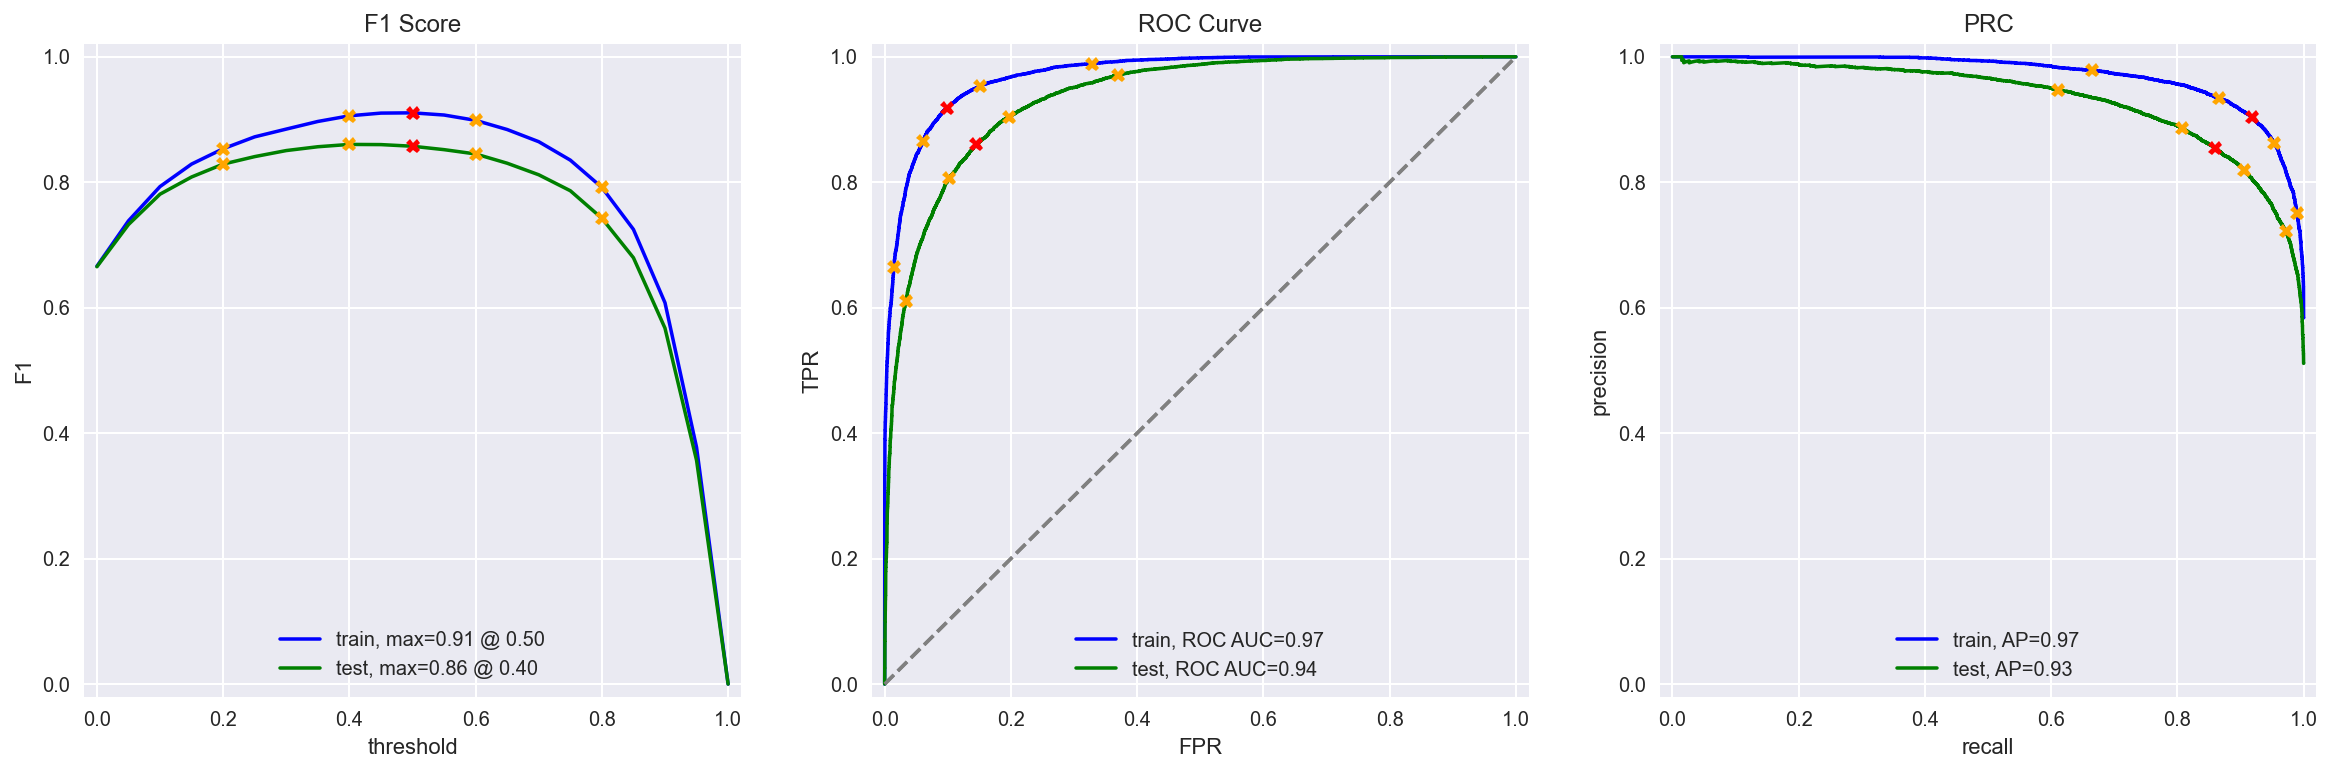

In [45]:
# evalutate the model
evaluate_model(model_3, tf_idf_train_spacy, train_y, tf_idf_test_spacy, test_y)

Seems like the more complex lightGBM classifier doesn't give us better results than the logistic regression model we used above, even though fitting hyperparameters and training it took much more time.

###  Model 4 - BERT

Let's try another direction entirely, using BERT to generate the text embeddings as features and then a either logistic regression or lightgbbm models to predict targets.

In [50]:
# define needed objects
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [65]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=10, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    for text in texts:
        
        # tokenize the text
        ids = tokenizer.encode(text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        
        # add padding
        padded = np.array(ids[:max_length] + [0]*(max_length - len(ids)))
        
        # creating the attention mask to distinguish tokens we are interested in
        attention_mask = np.where(padded != 0, 1, 0)        
        
        # append ids and mask to lists
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)        

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # getting embeddings in batches
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.ShortTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

I used this function to perform the embeddings for the whole dataset with a computer with a GPU to greatly speed things up. I'll try loading the computed embeddings which I saved using numpy's savez_compressed().

If the loading of the embeddings doesn't work, I'll limit myself to 200 train and 200 test reviews that I'll calculate de novo.

In [118]:
# try loading computer embeddings, otherwise generate new results.
try:
    with np.load('bert_features_all.npz') as data:
         train_features_4 = data['train_features_4']
         test_features_4 = data['test_features_4']
except:
    # running BERT on 200 training reviews
    train_features_4 = BERT_text_to_embeddings(df_reviews_train['review_norm'].head(200))
    train_y = train_y.head(200)

    # running BERT on 200 test reviews
    test_features_4 = BERT_text_to_embeddings(df_reviews_test['review_norm'].head(200))
    test_y = test_y.head(200)

# how to embeddings were saved:
#np.savez_compressed('bert_features_all.npz', train_features_4=train_features_4, test_features_4=test_features_4)

Now that we have embeddings, I'll try 3 different models:
* A logistic regression model
* A lightGBBM model cross validated to tune 2 basic hyperparameters
* A lightGBBM model with hyperparameter tuning using the optuna library

We'll begin with the logistic regression.

In [117]:
# define model
model_4a = LogisticRegression(max_iter=300, verbose=2, solver='lbfgs', n_jobs=3)

# fit to data
model_4a.fit(train_features_4, train_y);

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:  2.5min finished


          train  test
Accuracy   0.88  0.86
F1         0.88  0.86
APS        0.95  0.94
ROC AUC    0.95  0.94


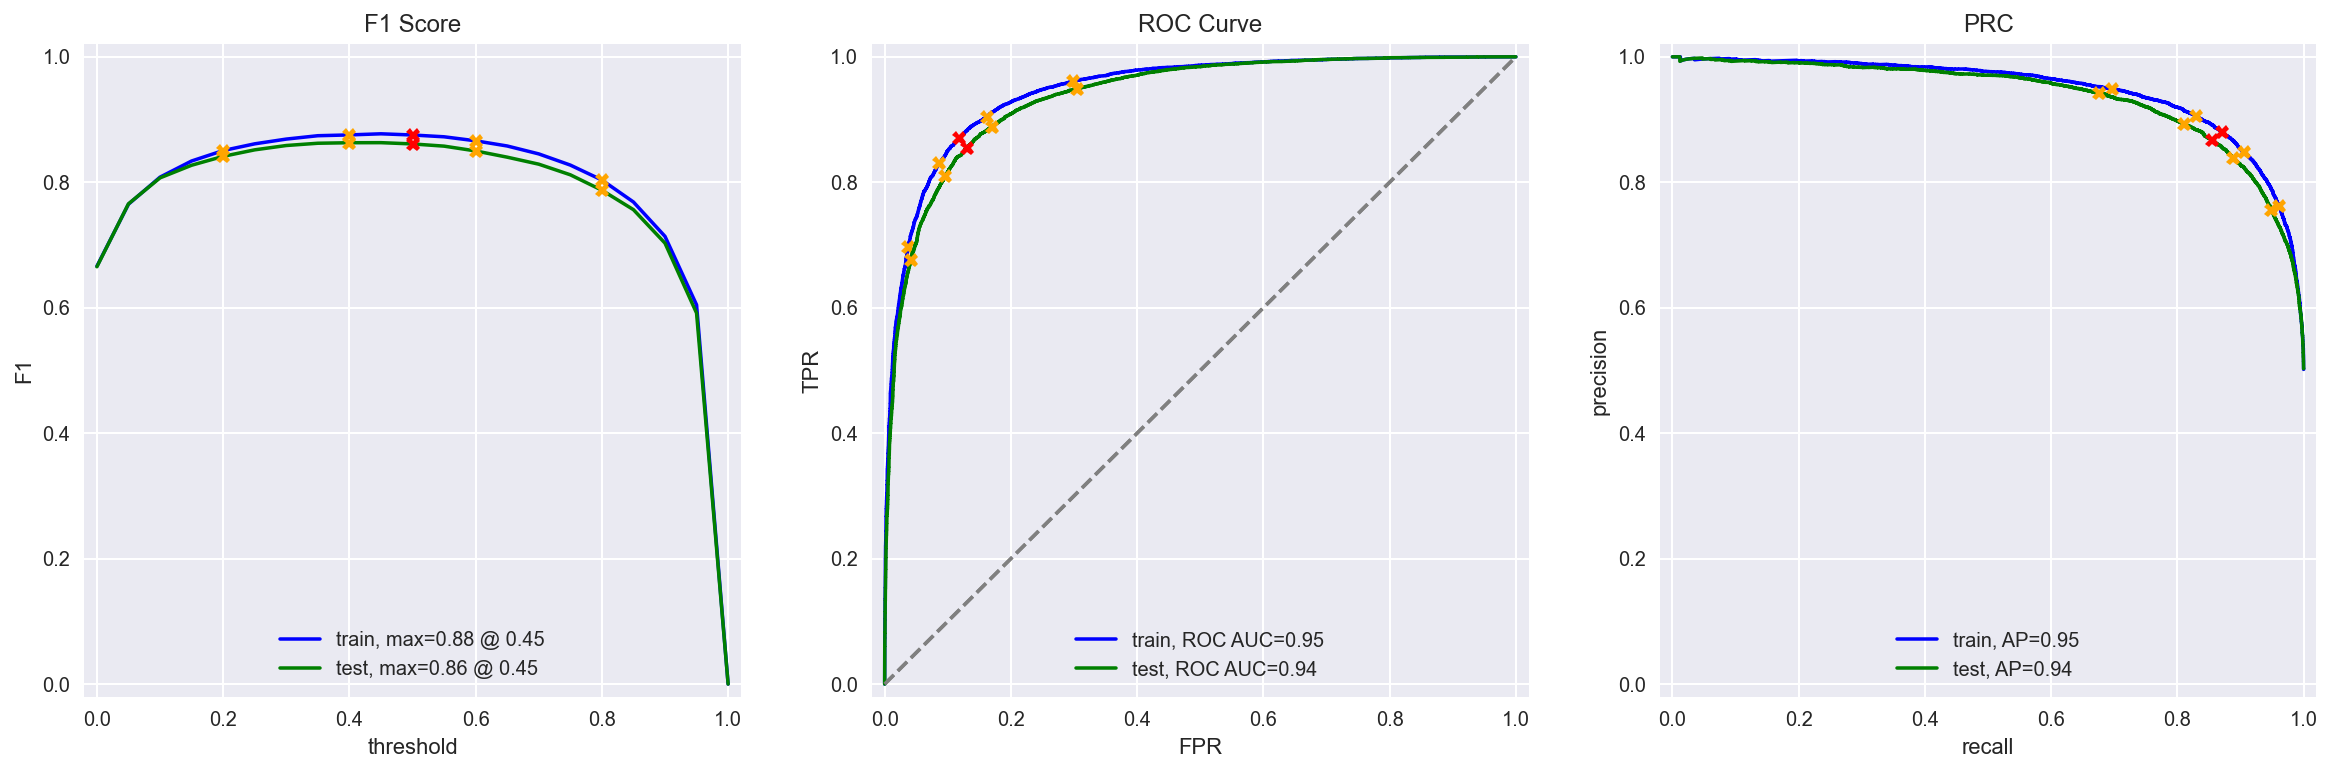

In [119]:
# evalutate the model
evaluate_model(model_4a, train_features_4, train_y, test_features_4, test_y)

Now let's tune an LGBM classifier using a simple cross validation with a small number of hyperparameters to tune:

In [90]:
# define model
model_4b = LGBMClassifier()

# define parameters for the gridsearchCV
param_lgbm = {'boosting_type' : ['gbdt', 'dart', 'goss'],
              'min_data_in_leaf' : [10, 100]}

# Perform the grid search cross validation
grid_lgbm = GridSearchCV(model_4b, param_grid=param_lgbm, cv=3, scoring='f1', verbose=2, n_jobs=3)
results_lgbm = grid_lgbm.fit(tf_idf_train_spacy, train_y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


In [91]:
# print resulting best score and parameters - RandomForestRegressor
print("\nLGBMRegressor() model:")
print('The best parameters across ALL searched params: \n   {}' .format(grid_lgbm.best_params_))
print('The best score across ALL searched params: {:.3f}' .format(grid_lgbm.best_score_))
cv_results_lgbm = pd.DataFrame.from_dict(results_lgbm.cv_results_)

# let's show the 10 best parameter combinations for lgbm 
cv_results_lgbm.sort_values('rank_test_score').head(10)[['param_boosting_type', 'param_min_data_in_leaf','mean_test_score', 'rank_test_score']]


LGBMRegressor() model:
The best parameters across ALL searched params: 
   {'boosting_type': 'gbdt', 'min_data_in_leaf': 10}
The best score across ALL searched params: 0.851


param_boosting_type param_min_data_in_leaf  mean_test_score  rank_test_score
0                gbdt                     10         0.851219                1
1                gbdt                    100         0.849340                2
4                goss                     10         0.849278                3
5                goss                    100         0.837534                4
2                dart                     10         0.829641                5
3                dart                    100         0.827880                6

Let's see what this tuned model gives us:

In [121]:
# define model
model_4b = LGBMClassifier(boosting_type='gbdt', min_data_in_leaf=10)

# fit the data
model_4b.fit(train_features_4, train_y);

          train  test
Accuracy   0.92  0.83
F1         0.92  0.83
APS        0.98  0.92
ROC AUC    0.98  0.91


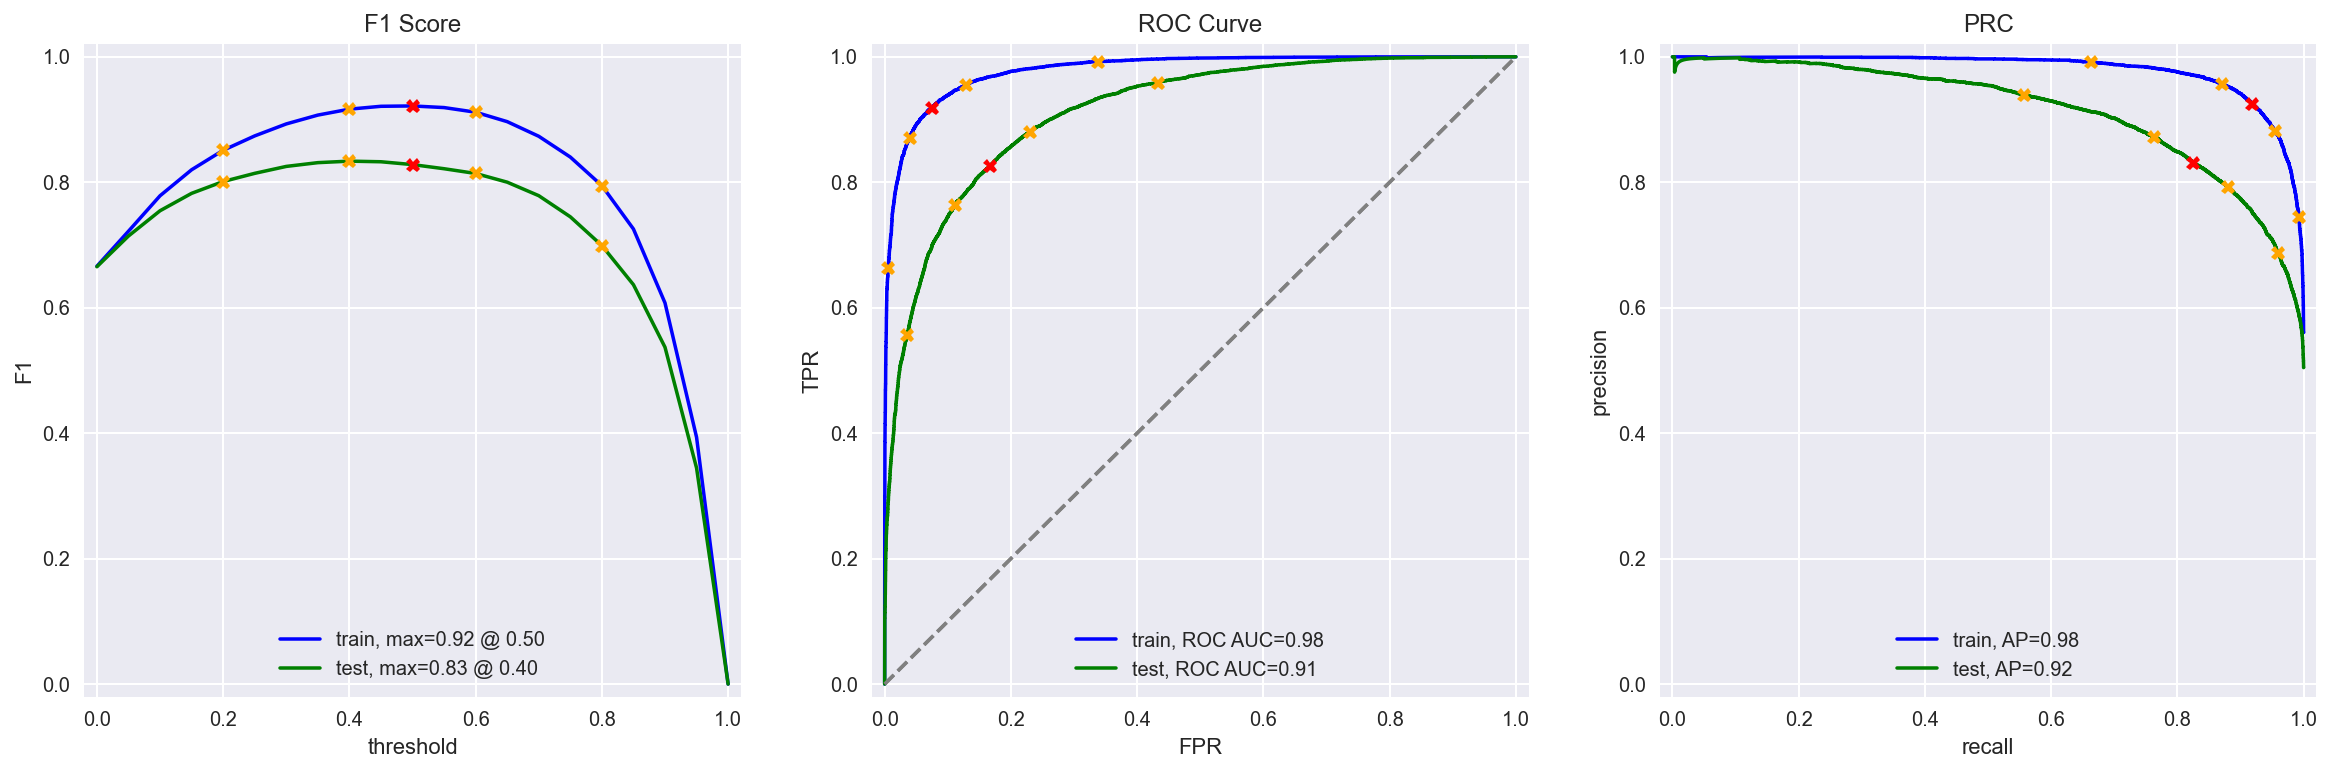

In [122]:
# evalutate the model
evaluate_model(model_4b, train_features_4, train_y, test_features_4, test_y)

We appear to be getting comparable max results to what we've seen in the past, including using spacy and nltk for the text vectorization.

Lastly, we'll try a separate hyperparameter tuning library to get the best hyperparameters using fewer rounds of testing:

In [97]:
# define objective function for optuna
def objective(trial):

    otrain_x, ovalid_x, otrain_y, ovalid_y = train_test_split(train_features_4, train_y, test_size=0.25)
    dtrain = lgb.Dataset(otrain_x, label=otrain_y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": 1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(ovalid_x)
    pred_labels = np.rint(preds)
    
    #accuracy = sklearn.metrics.accuracy_score(ovalid_y, pred_labels)
    return f1_score(ovalid_y, pred_labels)

# create optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

# print results
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-17 11:19:38,554] A new study created in memory with name: no-name-c377c65b-c14d-4110-a3e5-ee7f2b83192d


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Info] Number of positive: 8909, number of negative: 8938
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.250368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499188 -> initscore=-0.003250
[LightGBM] [Info] Start training from score -0.003250


[I 2022-08-17 11:19:58,959] Trial 0 finished with value: 0.830042194092827 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 72, 'lambda_l1': 0.00017902118661870648, 'lambda_l2': 0.0005422397916566407, 'num_leaves': 115, 'feature_fraction': 0.6523574305168212, 'bagging_fraction': 0.8266248556118139, 'bagging_freq': 1, 'min_child_samples': 55}. Best is trial 0 with value: 0.830042194092827.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Info] Number of positive: 8948, number of negative: 8899
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501373 -> initscore=0.005491
[LightGBM] [Info] Start training from score 0.005491


[I 2022-08-17 11:20:25,991] Trial 1 finished with value: 0.8239675016926202 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 11, 'lambda_l1': 0.5004005328293374, 'lambda_l2': 1.1913682695826584e-07, 'num_leaves': 188, 'feature_fraction': 0.46900119183855493, 'bagging_fraction': 0.718835417191469, 'bagging_freq': 1, 'min_child_samples': 64}. Best is trial 0 with value: 0.830042194092827.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Info] Number of positive: 8873, number of negative: 8974
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497170 -> initscore=-0.011319
[LightGBM] [Info] Start training from score -0.011319


[I 2022-08-17 11:20:43,095] Trial 2 finished with value: 0.8305901911886949 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 38, 'lambda_l1': 1.4667871094646008, 'lambda_l2': 0.009011146293933216, 'num_leaves': 154, 'feature_fraction': 0.5187926237981975, 'bagging_fraction': 0.7525958061293267, 'bagging_freq': 1, 'min_child_samples': 47}. Best is trial 2 with value: 0.8305901911886949.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 8902, number of negative: 8945
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498795 -> initscore=-0.004819
[LightGBM] [Info] Start training from score -0.004819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2022-08-17 11:20:57,905] Trial 3 finished with value: 0.8274712452075346 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 52, 'lambda_l1': 0.000305133347617085, 'lambda_l2': 4.810167991914546, 'num_leaves': 139, 'feature_fraction': 0.4777487425407323, 'bagging_fraction': 0.7622974109282271, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 2 with value: 0.8305901911886949.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Info] Number of positive: 8891, number of negative: 8956
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498179 -> initscore=-0.007284
[LightGBM] [Info] Start training from score -0.007284


[I 2022-08-17 11:21:52,298] Trial 4 finished with value: 0.8293910417715148 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 17, 'lambda_l1': 2.6323780831473505e-06, 'lambda_l2': 0.0006505784418344502, 'num_leaves': 223, 'feature_fraction': 0.8390914936630338, 'bagging_fraction': 0.8480637181665109, 'bagging_freq': 1, 'min_child_samples': 81}. Best is trial 2 with value: 0.8305901911886949.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Info] Number of positive: 8960, number of negative: 8887
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502045 -> initscore=0.008181
[LightGBM] [Info] Start training from score 0.008181


[I 2022-08-17 11:21:59,189] Trial 5 finished with value: 0.824957264957265 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 63, 'lambda_l1': 0.0005802814372206687, 'lambda_l2': 0.049347338614627013, 'num_leaves': 27, 'feature_fraction': 0.440859291584082, 'bagging_fraction': 0.5995018382676464, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 2 with value: 0.8305901911886949.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 8893, number of negative: 8954
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.247259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498291 -> initscore=-0.006836
[LightGBM] [Info] Start training from score -0.006836


[I 2022-08-17 11:22:14,427] Trial 6 finished with value: 0.8160996968676322 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 52, 'lambda_l1': 1.606987787351089e-05, 'lambda_l2': 4.5779879115573584e-08, 'num_leaves': 42, 'feature_fraction': 0.9848443728081137, 'bagging_fraction': 0.43797017557303264, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 2 with value: 0.8305901911886949.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Info] Number of positive: 8894, number of negative: 8953
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498347 -> initscore=-0.006612
[LightGBM] [Info] Start training from score -0.006612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2022-08-17 11:22:27,171] Trial 7 finished with value: 0.8186339522546419 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 93, 'lambda_l1': 1.3276366223387554e-07, 'lambda_l2': 9.531860046212183, 'num_leaves': 89, 'feature_fraction': 0.6397952722792912, 'bagging_fraction': 0.7413562558928429, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 2 with value: 0.8305901911886949.


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Info] Number of positive: 8893, number of negative: 8954
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498291 -> initscore=-0.006836
[LightGBM] [Info] Start training from score -0.006836


[I 2022-08-17 11:22:40,243] Trial 8 finished with value: 0.813507551332089 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 74, 'lambda_l1': 3.8610019657360755, 'lambda_l2': 0.002670044573518066, 'num_leaves': 77, 'feature_fraction': 0.7647741950310212, 'bagging_fraction': 0.7704541442991711, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 2 with value: 0.8305901911886949.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Info] Number of positive: 8938, number of negative: 8909
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500812 -> initscore=0.003250
[LightGBM] [Info] Start training from score 0.003250
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2022-08-17 11:22:57,819] Trial 9 finished with value: 0.8275978407557356 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 24, 'lambda_l1': 3.039944632947534e-06, 'lambda_l2': 1.2385859742426701, 'num_leaves': 248, 'feature_fraction': 0.4024268435309635, 'bagging_fraction': 0.4263807391453616, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 2 with value: 0.8305901911886949.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Info] Number of positive: 8907, number of negative: 8940
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499075 -> initscore=-0.003698
[LightGBM] [Info] Start training from score -0.003698


[I 2022-08-17 11:23:29,085] Trial 10 finished with value: 0.8325668540282745 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 35, 'lambda_l1': 0.05215535140120824, 'lambda_l2': 2.351361248704821e-05, 'num_leaves': 169, 'feature_fraction': 0.5671559310768173, 'bagging_fraction': 0.9352609962758325, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 10 with value: 0.8325668540282745.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Info] Number of positive: 8900, number of negative: 8947
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498683 -> initscore=-0.005267
[LightGBM] [Info] Start training from score -0.005267


[I 2022-08-17 11:24:22,283] Trial 11 finished with value: 0.8294325644047819 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 34, 'lambda_l1': 0.0388493311763278, 'lambda_l2': 3.619254392790969e-06, 'num_leaves': 177, 'feature_fraction': 0.5704026968885376, 'bagging_fraction': 0.9221020129922759, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 10 with value: 0.8325668540282745.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Info] Number of positive: 8915, number of negative: 8932
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499524 -> initscore=-0.001905
[LightGBM] [Info] Start training from score -0.001905


[I 2022-08-17 11:24:58,412] Trial 12 finished with value: 0.8306451612903225 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 37, 'lambda_l1': 0.03150457636744387, 'lambda_l2': 9.231295277301996e-06, 'num_leaves': 156, 'feature_fraction': 0.5611130710170326, 'bagging_fraction': 0.9950556916373857, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 10 with value: 0.8325668540282745.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Info] Number of positive: 8908, number of negative: 8939
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499132 -> initscore=-0.003474
[LightGBM] [Info] Start training from score -0.003474


[I 2022-08-17 11:25:40,643] Trial 13 finished with value: 0.8267968355495708 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 36, 'lambda_l1': 0.030907732261603423, 'lambda_l2': 9.174220154919074e-06, 'num_leaves': 202, 'feature_fraction': 0.5772452945709424, 'bagging_fraction': 0.9930745702298467, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 10 with value: 0.8325668540282745.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Info] Number of positive: 8919, number of negative: 8928
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499748 -> initscore=-0.001009
[LightGBM] [Info] Start training from score -0.001009


[I 2022-08-17 11:26:21,109] Trial 14 finished with value: 0.8329160407277583 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 44, 'lambda_l1': 0.020998724469443387, 'lambda_l2': 7.945720074397129e-06, 'num_leaves': 161, 'feature_fraction': 0.7319798173704664, 'bagging_fraction': 0.9833813351732549, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 14 with value: 0.8329160407277583.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Info] Number of positive: 8842, number of negative: 9005
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.250030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495433 -> initscore=-0.018267
[LightGBM] [Info] Start training from score -0.018267


[I 2022-08-17 11:26:57,922] Trial 15 finished with value: 0.83391289948667 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 45, 'lambda_l1': 0.010454296435152641, 'lambda_l2': 9.048809001973506e-07, 'num_leaves': 110, 'feature_fraction': 0.7705866205545981, 'bagging_fraction': 0.895874703750186, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 15 with value: 0.83391289948667.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Info] Number of positive: 8955, number of negative: 8892
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.307052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501765 -> initscore=0.007060
[LightGBM] [Info] Start training from score 0.007060


[I 2022-08-17 11:27:42,651] Trial 16 finished with value: 0.8406871000336815 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 48, 'lambda_l1': 0.003235595193174341, 'lambda_l2': 6.279835075187584e-07, 'num_leaves': 102, 'feature_fraction': 0.774845911630769, 'bagging_fraction': 0.6447841416633718, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 16 with value: 0.8406871000336815.


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Info] Number of positive: 8917, number of negative: 8930
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499636 -> initscore=-0.001457
[LightGBM] [Info] Start training from score -0.001457


[I 2022-08-17 11:28:10,691] Trial 17 finished with value: 0.8430252100840336 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 62, 'lambda_l1': 0.0018857023112062727, 'lambda_l2': 4.145510117339812e-07, 'num_leaves': 108, 'feature_fraction': 0.8552641327912923, 'bagging_fraction': 0.6041638110407759, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Info] Number of positive: 8923, number of negative: 8924
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.254875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499972 -> initscore=-0.000112
[LightGBM] [Info] Start training from score -0.000112


[I 2022-08-17 11:28:34,863] Trial 18 finished with value: 0.8345058626465661 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 64, 'lambda_l1': 0.0007763024989490757, 'lambda_l2': 3.573906312444859e-07, 'num_leaves': 68, 'feature_fraction': 0.898669755052662, 'bagging_fraction': 0.6254726593746744, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Info] Number of positive: 8861, number of negative: 8986
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.255332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496498 -> initscore=-0.014008
[LightGBM] [Info] Start training from score -0.014008


[I 2022-08-17 11:28:41,671] Trial 19 finished with value: 0.826990194449061 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 93, 'lambda_l1': 0.00264388096479743, 'lambda_l2': 3.47472839078233e-08, 'num_leaves': 11, 'feature_fraction': 0.8645644542626163, 'bagging_fraction': 0.5355629177572208, 'bagging_freq': 6, 'min_child_samples': 94}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Info] Number of positive: 8860, number of negative: 8987
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496442 -> initscore=-0.014232
[LightGBM] [Info] Start training from score -0.014232


[I 2022-08-17 11:29:13,113] Trial 20 finished with value: 0.8322858087992061 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 82, 'lambda_l1': 2.0219815211019246e-08, 'lambda_l2': 6.0643943259356455e-05, 'num_leaves': 101, 'feature_fraction': 0.9606541328151313, 'bagging_fraction': 0.6476181554958685, 'bagging_freq': 4, 'min_child_samples': 29}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Info] Number of positive: 8913, number of negative: 8934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.299849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


[I 2022-08-17 11:29:32,605] Trial 21 finished with value: 0.8291213389121338 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 63, 'lambda_l1': 4.468887361858774e-05, 'lambda_l2': 4.4221262777515885e-07, 'num_leaves': 62, 'feature_fraction': 0.8989661559907761, 'bagging_fraction': 0.5595176645095629, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Info] Number of positive: 8914, number of negative: 8933
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.254385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499468 -> initscore=-0.002129
[LightGBM] [Info] Start training from score -0.002129


[I 2022-08-17 11:29:54,177] Trial 22 finished with value: 0.8315860669597565 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 62, 'lambda_l1': 0.002528515330619723, 'lambda_l2': 1.0147224409041639e-08, 'num_leaves': 59, 'feature_fraction': 0.8140890852178975, 'bagging_fraction': 0.6585677969492634, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Info] Number of positive: 8916, number of negative: 8931
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.247922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499580 -> initscore=-0.001681
[LightGBM] [Info] Start training from score -0.001681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2022-08-17 11:30:14,712] Trial 23 finished with value: 0.8310810810810811 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 76, 'lambda_l1': 0.002216222487072722, 'lambda_l2': 1.0647137748807838e-06, 'num_leaves': 127, 'feature_fraction': 0.9136356773298812, 'bagging_fraction': 0.4883511629594316, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Info] Number of positive: 8887, number of negative: 8960
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.242599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497955 -> initscore=-0.008181
[LightGBM] [Info] Start training from score -0.008181


[I 2022-08-17 11:30:39,217] Trial 24 finished with value: 0.8236278447121822 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 56, 'lambda_l1': 0.20728506649961306, 'lambda_l2': 2.7972443048583517e-07, 'num_leaves': 79, 'feature_fraction': 0.7970615698149175, 'bagging_fraction': 0.6452344642852125, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Info] Number of positive: 8916, number of negative: 8931
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.249637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499580 -> initscore=-0.001681
[LightGBM] [Info] Start training from score -0.001681


[I 2022-08-17 11:30:57,154] Trial 25 finished with value: 0.8423867624937322 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 82, 'lambda_l1': 7.217099917788538e-05, 'lambda_l2': 5.692495567096532e-05, 'num_leaves': 51, 'feature_fraction': 0.9176550481882612, 'bagging_fraction': 0.5765940925955678, 'bagging_freq': 4, 'min_child_samples': 24}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Info] Number of positive: 8947, number of negative: 8900
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.382968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501317 -> initscore=0.005267
[LightGBM] [Info] Start training from score 0.005267


[I 2022-08-17 11:31:10,126] Trial 26 finished with value: 0.8298854505043597 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 85, 'lambda_l1': 4.87693985336204e-05, 'lambda_l2': 7.880103492167667e-05, 'num_leaves': 38, 'feature_fraction': 0.7048429051697807, 'bagging_fraction': 0.5673709066138773, 'bagging_freq': 4, 'min_child_samples': 26}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Info] Number of positive: 8899, number of negative: 8948
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498627 -> initscore=-0.005491
[LightGBM] [Info] Start training from score -0.005491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2022-08-17 11:31:30,861] Trial 27 finished with value: 0.8300488462186288 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 81, 'lambda_l1': 3.949949963788985e-06, 'lambda_l2': 2.2346792961583878e-06, 'num_leaves': 97, 'feature_fraction': 0.9425584358930911, 'bagging_fraction': 0.5099631100858733, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 8945, number of negative: 8902
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.302961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501205 -> initscore=0.004819
[LightGBM] [Info] Start training from score 0.004819


[I 2022-08-17 11:31:35,498] Trial 28 finished with value: 0.8128235097679078 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 100, 'lambda_l1': 0.00010839678341275858, 'lambda_l2': 0.00012876742528764943, 'num_leaves': 4, 'feature_fraction': 0.8628553046945413, 'bagging_fraction': 0.6830051908563327, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Info] Number of positive: 8898, number of negative: 8949
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.247596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498571 -> initscore=-0.005715
[LightGBM] [Info] Start training from score -0.005715


[I 2022-08-17 11:32:07,071] Trial 29 finished with value: 0.8306139613120269 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 69, 'lambda_l1': 0.005580961659832023, 'lambda_l2': 0.0003791831591595232, 'num_leaves': 126, 'feature_fraction': 0.6501831603027027, 'bagging_fraction': 0.8141457577427093, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Info] Number of positive: 8920, number of negative: 8927
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.254612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499804 -> initscore=-0.000784
[LightGBM] [Info] Start training from score -0.000784


[I 2022-08-17 11:32:28,178] Trial 30 finished with value: 0.8277134708941453 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 57, 'lambda_l1': 6.24173731289547e-07, 'lambda_l2': 1.2412507056656795e-08, 'num_leaves': 49, 'feature_fraction': 0.9947741882706413, 'bagging_fraction': 0.6007244338188675, 'bagging_freq': 4, 'min_child_samples': 45}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Info] Number of positive: 8911, number of negative: 8936
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499300 -> initscore=-0.002802
[LightGBM] [Info] Start training from score -0.002802


[I 2022-08-17 11:32:49,895] Trial 31 finished with value: 0.8321631561350717 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 64, 'lambda_l1': 0.0005407726632011481, 'lambda_l2': 1.2819872564359263e-07, 'num_leaves': 71, 'feature_fraction': 0.9031728947350015, 'bagging_fraction': 0.6086061761754702, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Info] Number of positive: 8879, number of negative: 8968
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497507 -> initscore=-0.009974
[LightGBM] [Info] Start training from score -0.009974


[I 2022-08-17 11:33:18,387] Trial 32 finished with value: 0.8240214118434258 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 70, 'lambda_l1': 0.0008019012283949147, 'lambda_l2': 1.452418727342118e-07, 'num_leaves': 113, 'feature_fraction': 0.8504476687239877, 'bagging_fraction': 0.6843242488695722, 'bagging_freq': 5, 'min_child_samples': 39}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Info] Number of positive: 8953, number of negative: 8894
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.257155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501653 -> initscore=0.006612
[LightGBM] [Info] Start training from score 0.006612


[I 2022-08-17 11:33:31,567] Trial 33 finished with value: 0.8294087751990513 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 45, 'lambda_l1': 0.00013375602772784206, 'lambda_l2': 1.321879595561668e-06, 'num_leaves': 27, 'feature_fraction': 0.9326429159327341, 'bagging_fraction': 0.481934805937661, 'bagging_freq': 7, 'min_child_samples': 49}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Info] Number of positive: 8915, number of negative: 8932
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.295277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499524 -> initscore=-0.001905
[LightGBM] [Info] Start training from score -0.001905


[I 2022-08-17 11:34:01,480] Trial 34 finished with value: 0.8338971583220567 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 49, 'lambda_l1': 0.30260197479500867, 'lambda_l2': 2.3900077738992833e-05, 'num_leaves': 77, 'feature_fraction': 0.8866224214096496, 'bagging_fraction': 0.7158225976860682, 'bagging_freq': 6, 'min_child_samples': 65}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Info] Number of positive: 8861, number of negative: 8986
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496498 -> initscore=-0.014008
[LightGBM] [Info] Start training from score -0.014008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2022-08-17 11:34:30,318] Trial 35 finished with value: 0.8258000659848235 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 77, 'lambda_l1': 2.132735485245068e-05, 'lambda_l2': 4.685488405868346e-08, 'num_leaves': 144, 'feature_fraction': 0.8127257050061504, 'bagging_fraction': 0.622684863516887, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Info] Number of positive: 8925, number of negative: 8922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500084 -> initscore=0.000336
[LightGBM] [Info] Start training from score 0.000336


[I 2022-08-17 11:34:59,523] Trial 36 finished with value: 0.8335857311122328 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 27, 'lambda_l1': 0.0002515176511795577, 'lambda_l2': 0.0021290052235058013, 'num_leaves': 94, 'feature_fraction': 0.7488331887350458, 'bagging_fraction': 0.5649805130014565, 'bagging_freq': 2, 'min_child_samples': 56}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Info] Number of positive: 8886, number of negative: 8961
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497899 -> initscore=-0.008405
[LightGBM] [Info] Start training from score -0.008405


[I 2022-08-17 11:35:19,475] Trial 37 finished with value: 0.8316335061026583 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 58, 'lambda_l1': 0.0008748480333782155, 'lambda_l2': 3.995465458616113e-07, 'num_leaves': 54, 'feature_fraction': 0.8357548714465508, 'bagging_fraction': 0.5315333765640411, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Info] Number of positive: 8930, number of negative: 8917
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500364 -> initscore=0.001457
[LightGBM] [Info] Start training from score 0.001457


[I 2022-08-17 11:35:34,259] Trial 38 finished with value: 0.8230563002680965 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 69, 'lambda_l1': 1.2679422484021038e-05, 'lambda_l2': 4.395957598596464e-06, 'num_leaves': 26, 'feature_fraction': 0.960534102699982, 'bagging_fraction': 0.5819761359197396, 'bagging_freq': 7, 'min_child_samples': 73}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Info] Number of positive: 8859, number of negative: 8988
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.329006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496386 -> initscore=-0.014456
[LightGBM] [Info] Start training from score -0.014456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2022-08-17 11:35:59,757] Trial 39 finished with value: 0.8327473631341035 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 90, 'lambda_l1': 0.11637162606737145, 'lambda_l2': 0.023569541597045295, 'num_leaves': 138, 'feature_fraction': 0.7960171046100238, 'bagging_fraction': 0.7001205799497637, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Info] Number of positive: 8936, number of negative: 8911
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500700 -> initscore=0.002802
[LightGBM] [Info] Start training from score 0.002802


[I 2022-08-17 11:36:20,887] Trial 40 finished with value: 0.8287068381855112 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 51, 'lambda_l1': 0.007836354353650467, 'lambda_l2': 0.20852546328079952, 'num_leaves': 86, 'feature_fraction': 0.6944712219257876, 'bagging_fraction': 0.7889735785877602, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Info] Number of positive: 8929, number of negative: 8918
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500308 -> initscore=0.001233
[LightGBM] [Info] Start training from score 0.001233


[I 2022-08-17 11:36:45,754] Trial 41 finished with value: 0.8341554686171118 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 49, 'lambda_l1': 0.007700491524736038, 'lambda_l2': 6.462690158557559e-07, 'num_leaves': 112, 'feature_fraction': 0.7808518552231125, 'bagging_fraction': 0.6350872123696687, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Info] Number of positive: 8849, number of negative: 8998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495826 -> initscore=-0.016698
[LightGBM] [Info] Start training from score -0.016698


[I 2022-08-17 11:37:22,223] Trial 42 finished with value: 0.8328929986789962 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 43, 'lambda_l1': 0.0015211593150686296, 'lambda_l2': 5.795054791578458e-08, 'num_leaves': 121, 'feature_fraction': 0.8733690250783238, 'bagging_fraction': 0.6301769851456651, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Number of positive: 8894, number of negative: 8953
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498347 -> initscore=-0.006612
[LightGBM] [Info] Start training from score -0.006612


[I 2022-08-17 11:37:44,305] Trial 43 finished with value: 0.8288922406569467 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 60, 'lambda_l1': 0.7657736937201348, 'lambda_l2': 4.90991814218457e-07, 'num_leaves': 107, 'feature_fraction': 0.8326308831789797, 'bagging_fraction': 0.6679637810045703, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 8875, number of negative: 8972
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497282 -> initscore=-0.010870
[LightGBM] [Info] Start training from score -0.010870


[I 2022-08-17 11:38:08,266] Trial 44 finished with value: 0.8316831683168315 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 52, 'lambda_l1': 0.00032079422777182154, 'lambda_l2': 2.168282265690316e-06, 'num_leaves': 90, 'feature_fraction': 0.7781350725120485, 'bagging_fraction': 0.7346030629493547, 'bagging_freq': 5, 'min_child_samples': 20}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Info] Number of positive: 8881, number of negative: 8966
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497619 -> initscore=-0.009525
[LightGBM] [Info] Start training from score -0.009525


[I 2022-08-17 11:38:27,174] Trial 45 finished with value: 0.8313373253493014 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 67, 'lambda_l1': 0.006564671790773491, 'lambda_l2': 2.57202072647726e-05, 'num_leaves': 67, 'feature_fraction': 0.7297996320434493, 'bagging_fraction': 0.6038330364267755, 'bagging_freq': 7, 'min_child_samples': 37}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 8913, number of negative: 8934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.249293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


[I 2022-08-17 11:39:02,970] Trial 46 finished with value: 0.8259845169976439 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 10, 'lambda_l1': 0.08095227687346744, 'lambda_l2': 1.8180304495117454e-07, 'num_leaves': 141, 'feature_fraction': 0.7023233593071859, 'bagging_fraction': 0.45331691458571743, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Info] Number of positive: 8905, number of negative: 8942
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498963 -> initscore=-0.004146
[LightGBM] [Info] Start training from score -0.004146


[I 2022-08-17 11:39:18,489] Trial 47 finished with value: 0.8251256281407034 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 48, 'lambda_l1': 0.017919834142851074, 'lambda_l2': 7.311179894654523e-08, 'num_leaves': 44, 'feature_fraction': 0.9304750339957455, 'bagging_fraction': 0.4015348336865688, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Info] Number of positive: 8917, number of negative: 8930
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499636 -> initscore=-0.001457
[LightGBM] [Info] Start training from score -0.001457


[I 2022-08-17 11:39:45,693] Trial 48 finished with value: 0.8239675016926203 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 41, 'lambda_l1': 7.090505467852832e-05, 'lambda_l2': 2.3482881383705235e-08, 'num_leaves': 115, 'feature_fraction': 0.827046102187708, 'bagging_fraction': 0.5368796202437217, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Info] Number of positive: 8892, number of negative: 8955
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498235 -> initscore=-0.007060
[LightGBM] [Info] Start training from score -0.007060


[I 2022-08-17 11:40:34,605] Trial 49 finished with value: 0.8252005347593583 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 28, 'lambda_l1': 0.004216031593245401, 'lambda_l2': 0.0010750950864498348, 'num_leaves': 192, 'feature_fraction': 0.9682679081258778, 'bagging_fraction': 0.6299404872299538, 'bagging_freq': 6, 'min_child_samples': 45}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Info] Number of positive: 8828, number of negative: 9019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494649 -> initscore=-0.021405
[LightGBM] [Info] Start training from score -0.021405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2022-08-17 11:40:44,931] Trial 50 finished with value: 0.8284120734908137 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 73, 'lambda_l1': 8.877874704718852, 'lambda_l2': 4.87008921379852e-06, 'num_leaves': 82, 'feature_fraction': 0.8804754907892628, 'bagging_fraction': 0.5797490207577707, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Info] Number of positive: 8920, number of negative: 8927
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499804 -> initscore=-0.000784
[LightGBM] [Info] Start training from score -0.000784


[I 2022-08-17 11:41:10,797] Trial 51 finished with value: 0.8394062078272605 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 54, 'lambda_l1': 0.012967163763721258, 'lambda_l2': 1.5723801260281722e-06, 'num_leaves': 104, 'feature_fraction': 0.7631183967716177, 'bagging_fraction': 0.7112339425815479, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Info] Number of positive: 8881, number of negative: 8966
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497619 -> initscore=-0.009525
[LightGBM] [Info] Start training from score -0.009525


[I 2022-08-17 11:41:32,479] Trial 52 finished with value: 0.8334163760172728 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 53, 'lambda_l1': 0.014462870971767175, 'lambda_l2': 7.511488791723071e-07, 'num_leaves': 103, 'feature_fraction': 0.6856693109164321, 'bagging_fraction': 0.7127946855195113, 'bagging_freq': 7, 'min_child_samples': 14}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Number of positive: 8930, number of negative: 8917
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500364 -> initscore=0.001457
[LightGBM] [Info] Start training from score 0.001457


[I 2022-08-17 11:42:05,348] Trial 53 finished with value: 0.8296146044624746 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 40, 'lambda_l1': 0.00043333563837633657, 'lambda_l2': 1.2883384864920173e-05, 'num_leaves': 134, 'feature_fraction': 0.7407027899152683, 'bagging_fraction': 0.7551041545152964, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Info] Number of positive: 8956, number of negative: 8891
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.270351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501821 -> initscore=0.007284
[LightGBM] [Info] Start training from score 0.007284


[I 2022-08-17 11:42:24,922] Trial 54 finished with value: 0.8321917808219178 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 65, 'lambda_l1': 0.0019577737902671945, 'lambda_l2': 2.5947981712559576e-06, 'num_leaves': 70, 'feature_fraction': 0.7874941326262996, 'bagging_fraction': 0.6734551319961162, 'bagging_freq': 5, 'min_child_samples': 28}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Info] Number of positive: 8883, number of negative: 8964
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497731 -> initscore=-0.009077
[LightGBM] [Info] Start training from score -0.009077


[I 2022-08-17 11:42:53,116] Trial 55 finished with value: 0.8352452202826267 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 47, 'lambda_l1': 0.0009660146394677395, 'lambda_l2': 3.094642063461215e-07, 'num_leaves': 121, 'feature_fraction': 0.7587470750702101, 'bagging_fraction': 0.642960958418584, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Info] Number of positive: 8936, number of negative: 8911
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500700 -> initscore=0.002802
[LightGBM] [Info] Start training from score 0.002802


[I 2022-08-17 11:43:27,641] Trial 56 finished with value: 0.8289718048286341 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 16, 'lambda_l1': 0.000994818563418566, 'lambda_l2': 2.568168716702109e-07, 'num_leaves': 148, 'feature_fraction': 0.6291266615970627, 'bagging_fraction': 0.7338333371070958, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Info] Number of positive: 8917, number of negative: 8930
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499636 -> initscore=-0.001457
[LightGBM] [Info] Start training from score -0.001457


[I 2022-08-17 11:43:52,977] Trial 57 finished with value: 0.824585167626143 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 55, 'lambda_l1': 0.00020152071843742328, 'lambda_l2': 0.0001599243600398205, 'num_leaves': 121, 'feature_fraction': 0.7540175305378055, 'bagging_fraction': 0.6522381124827471, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Info] Number of positive: 8893, number of negative: 8954
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.264585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498291 -> initscore=-0.006836
[LightGBM] [Info] Start training from score -0.006836


[I 2022-08-17 11:44:27,618] Trial 58 finished with value: 0.8339483394833949 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 31, 'lambda_l1': 3.0426924228352582e-05, 'lambda_l2': 1.4245701022446327e-06, 'num_leaves': 165, 'feature_fraction': 0.7232546844830633, 'bagging_fraction': 0.6934571043590568, 'bagging_freq': 5, 'min_child_samples': 36}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Info] Number of positive: 8914, number of negative: 8933
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499468 -> initscore=-0.002129
[LightGBM] [Info] Start training from score -0.002129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2022-08-17 11:44:53,108] Trial 59 finished with value: 0.8369437447523089 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 47, 'lambda_l1': 1.2035710555826879e-05, 'lambda_l2': 9.446829628954557e-08, 'num_leaves': 245, 'feature_fraction': 0.6124708107609899, 'bagging_fraction': 0.5832316586935886, 'bagging_freq': 6, 'min_child_samples': 94}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Info] Number of positive: 8972, number of negative: 8875
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502718 -> initscore=0.010870
[LightGBM] [Info] Start training from score 0.010870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2022-08-17 11:45:24,147] Trial 60 finished with value: 0.8270908158029758 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 34, 'lambda_l1': 4.3716402506309336e-06, 'lambda_l2': 9.841924872070182e-08, 'num_leaves': 228, 'feature_fraction': 0.6051563913897586, 'bagging_fraction': 0.5427607871227792, 'bagging_freq': 4, 'min_child_samples': 98}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Info] Number of positive: 8904, number of negative: 8943
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498907 -> initscore=-0.004370
[LightGBM] [Info] Start training from score -0.004370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2022-08-17 11:45:43,571] Trial 61 finished with value: 0.8270676691729324 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 47, 'lambda_l1': 8.699723015823528e-05, 'lambda_l2': 2.3140109980240888e-08, 'num_leaves': 223, 'feature_fraction': 0.44512027027770606, 'bagging_fraction': 0.5843742221829628, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Info] Number of positive: 8891, number of negative: 8956
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498179 -> initscore=-0.007284
[LightGBM] [Info] Start training from score -0.007284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2022-08-17 11:46:02,378] Trial 62 finished with value: 0.833947104117844 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 61, 'lambda_l1': 8.561342193357821e-07, 'lambda_l2': 1.664916084667319e-07, 'num_leaves': 249, 'feature_fraction': 0.5444387035250533, 'bagging_fraction': 0.6039114922978367, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Info] Number of positive: 8875, number of negative: 8972
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497282 -> initscore=-0.010870
[LightGBM] [Info] Start training from score -0.010870


[I 2022-08-17 11:46:24,859] Trial 63 finished with value: 0.8306816278680288 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 58, 'lambda_l1': 1.291168171784805e-05, 'lambda_l2': 2.7682490373885086e-07, 'num_leaves': 103, 'feature_fraction': 0.8544428121064278, 'bagging_fraction': 0.5056488705821097, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Info] Number of positive: 8923, number of negative: 8924
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.254481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499972 -> initscore=-0.000112
[LightGBM] [Info] Start training from score -0.000112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2022-08-17 11:46:50,574] Trial 64 finished with value: 0.8309835230168167 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 54, 'lambda_l1': 0.0034670711556876762, 'lambda_l2': 1.112334142150964e-06, 'num_leaves': 180, 'feature_fraction': 0.6672995681105389, 'bagging_fraction': 0.6187378056586532, 'bagging_freq': 5, 'min_child_samples': 24}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Number of positive: 8881, number of negative: 8966
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497619 -> initscore=-0.009525
[LightGBM] [Info] Start training from score -0.009525


[I 2022-08-17 11:47:00,560] Trial 65 finished with value: 0.8255930504510524 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 40, 'lambda_l1': 0.0001553333719145214, 'lambda_l2': 7.220467090721781e-06, 'num_leaves': 36, 'feature_fraction': 0.503061016879121, 'bagging_fraction': 0.6560889163371484, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Info] Number of positive: 8874, number of negative: 8973
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497226 -> initscore=-0.011094
[LightGBM] [Info] Start training from score -0.011094


[I 2022-08-17 11:47:27,062] Trial 66 finished with value: 0.8364674278038952 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 46, 'lambda_l1': 7.575765601630501e-06, 'lambda_l2': 5.498974316490191e-07, 'num_leaves': 95, 'feature_fraction': 0.9174946336048282, 'bagging_fraction': 0.5937188502013199, 'bagging_freq': 7, 'min_child_samples': 76}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Info] Number of positive: 8891, number of negative: 8956
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498179 -> initscore=-0.007284
[LightGBM] [Info] Start training from score -0.007284


[I 2022-08-17 11:47:51,335] Trial 67 finished with value: 0.8281953007832028 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 45, 'lambda_l1': 7.930236006184375e-06, 'lambda_l2': 2.7153873488266017e-08, 'num_leaves': 153, 'feature_fraction': 0.6251701876778462, 'bagging_fraction': 0.5530912798797943, 'bagging_freq': 7, 'min_child_samples': 89}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Info] Number of positive: 8912, number of negative: 8935
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499356 -> initscore=-0.002577
[LightGBM] [Info] Start training from score -0.002577


[I 2022-08-17 11:48:22,024] Trial 68 finished with value: 0.8291533411883523 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 37, 'lambda_l1': 1.8004155396142494e-07, 'lambda_l2': 9.955891123711838e-08, 'num_leaves': 128, 'feature_fraction': 0.9127083699985087, 'bagging_fraction': 0.5168266521887686, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Info] Number of positive: 8915, number of negative: 8932
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499524 -> initscore=-0.001905
[LightGBM] [Info] Start training from score -0.001905


[I 2022-08-17 11:48:46,072] Trial 69 finished with value: 0.829309188464118 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 43, 'lambda_l1': 1.4389919024450819e-06, 'lambda_l2': 4.733783280796022e-05, 'num_leaves': 93, 'feature_fraction': 0.8121077121722595, 'bagging_fraction': 0.5837750885066436, 'bagging_freq': 7, 'min_child_samples': 72}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 8925, number of negative: 8922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500084 -> initscore=0.000336
[LightGBM] [Info] Start training from score 0.000336


[I 2022-08-17 11:49:09,104] Trial 70 finished with value: 0.8258973498825897 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 50, 'lambda_l1': 6.623360108829689e-06, 'lambda_l2': 1.705695733470145e-06, 'num_leaves': 121, 'feature_fraction': 0.6648293445506666, 'bagging_fraction': 0.6445637291289775, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Info] Number of positive: 8950, number of negative: 8897
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501485 -> initscore=0.005939
[LightGBM] [Info] Start training from score 0.005939


[I 2022-08-17 11:49:35,749] Trial 71 finished with value: 0.8320571720265442 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 46, 'lambda_l1': 0.001414288007878301, 'lambda_l2': 3.3944833431835e-07, 'num_leaves': 98, 'feature_fraction': 0.8907979781526346, 'bagging_fraction': 0.6176861026798035, 'bagging_freq': 6, 'min_child_samples': 69}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Info] Number of positive: 8895, number of negative: 8952
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498403 -> initscore=-0.006388
[LightGBM] [Info] Start training from score -0.006388


[I 2022-08-17 11:49:52,880] Trial 72 finished with value: 0.8343949044585988 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 98, 'lambda_l1': 3.003984721449585e-05, 'lambda_l2': 5.383745401248322e-07, 'num_leaves': 63, 'feature_fraction': 0.9408644803189954, 'bagging_fraction': 0.5684239058893364, 'bagging_freq': 4, 'min_child_samples': 100}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Info] Number of positive: 8906, number of negative: 8941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499019 -> initscore=-0.003922
[LightGBM] [Info] Start training from score -0.003922


[I 2022-08-17 11:50:12,586] Trial 73 finished with value: 0.8293830895948898 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 59, 'lambda_l1': 0.0005897557807738508, 'lambda_l2': 3.618670750744826e-06, 'num_leaves': 83, 'feature_fraction': 0.7613133370445195, 'bagging_fraction': 0.5955969033388402, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Info] Number of positive: 8892, number of negative: 8955
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498235 -> initscore=-0.007060
[LightGBM] [Info] Start training from score -0.007060


[I 2022-08-17 11:50:33,029] Trial 74 finished with value: 0.8303273213092852 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 87, 'lambda_l1': 2.021554128825535e-06, 'lambda_l2': 7.014154377311138e-07, 'num_leaves': 77, 'feature_fraction': 0.919773729260818, 'bagging_fraction': 0.6719688334905276, 'bagging_freq': 5, 'min_child_samples': 88}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Info] Number of positive: 8971, number of negative: 8876
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.248979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502662 -> initscore=0.010646
[LightGBM] [Info] Start training from score 0.010646


[I 2022-08-17 11:50:54,191] Trial 75 finished with value: 0.8191032468647997 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 81, 'lambda_l1': 0.04348383638716403, 'lambda_l2': 0.007230734910785797, 'num_leaves': 58, 'feature_fraction': 0.9749812598908276, 'bagging_fraction': 0.7739936331234163, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Info] Number of positive: 8902, number of negative: 8945
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498795 -> initscore=-0.004819
[LightGBM] [Info] Start training from score -0.004819


[I 2022-08-17 11:51:17,402] Trial 76 finished with value: 0.8260505608571906 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 55, 'lambda_l1': 0.00035922193045920714, 'lambda_l2': 6.299101737714415e-08, 'num_leaves': 105, 'feature_fraction': 0.7158270749251716, 'bagging_fraction': 0.6995696101707434, 'bagging_freq': 6, 'min_child_samples': 52}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Info] Number of positive: 8890, number of negative: 8957
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498123 -> initscore=-0.007508
[LightGBM] [Info] Start training from score -0.007508


[I 2022-08-17 11:51:37,997] Trial 77 finished with value: 0.8388278388278388 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 51, 'lambda_l1': 4.959919663291998e-05, 'lambda_l2': 1.3943607654200386e-08, 'num_leaves': 51, 'feature_fraction': 0.951348271631736, 'bagging_fraction': 0.8588765846910396, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Info] Number of positive: 8914, number of negative: 8933
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499468 -> initscore=-0.002129
[LightGBM] [Info] Start training from score -0.002129


[I 2022-08-17 11:51:48,321] Trial 78 finished with value: 0.8261376896149358 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 51, 'lambda_l1': 5.369019057500137e-05, 'lambda_l2': 1.5580050660753323e-08, 'num_leaves': 15, 'feature_fraction': 0.9993515040341672, 'bagging_fraction': 0.8561156945071924, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Info] Number of positive: 8913, number of negative: 8934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


[I 2022-08-17 11:52:10,610] Trial 79 finished with value: 0.829406850459482 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 42, 'lambda_l1': 8.295352372852317e-06, 'lambda_l2': 3.847680470324794e-08, 'num_leaves': 48, 'feature_fraction': 0.944990293104316, 'bagging_fraction': 0.9735296631368275, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Info] Number of positive: 8912, number of negative: 8935
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499356 -> initscore=-0.002577
[LightGBM] [Info] Start training from score -0.002577


[I 2022-08-17 11:52:35,603] Trial 80 finished with value: 0.825155960209071 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 39, 'lambda_l1': 2.3991220654991987e-05, 'lambda_l2': 1.857998260743482e-07, 'num_leaves': 116, 'feature_fraction': 0.5955662950715331, 'bagging_fraction': 0.876601578986359, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Info] Number of positive: 8875, number of negative: 8972
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497282 -> initscore=-0.010870
[LightGBM] [Info] Start training from score -0.010870


[I 2022-08-17 11:52:58,900] Trial 81 finished with value: 0.8315244615127735 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 47, 'lambda_l1': 0.00012836605071817547, 'lambda_l2': 8.809237998407452e-08, 'num_leaves': 72, 'feature_fraction': 0.9048102737051835, 'bagging_fraction': 0.6371663422049383, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Info] Number of positive: 8927, number of negative: 8920
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500196 -> initscore=0.000784
[LightGBM] [Info] Start training from score 0.000784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2022-08-17 11:53:33,034] Trial 82 finished with value: 0.8315098468271335 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 66, 'lambda_l1': 0.0010498790729446506, 'lambda_l2': 1.0192843107821959e-08, 'num_leaves': 236, 'feature_fraction': 0.8679619629672035, 'bagging_fraction': 0.8079365470806393, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Info] Number of positive: 8886, number of negative: 8961
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497899 -> initscore=-0.008405
[LightGBM] [Info] Start training from score -0.008405


[I 2022-08-17 11:53:55,570] Trial 83 finished with value: 0.8291363866824404 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 76, 'lambda_l1': 0.011004287138377328, 'lambda_l2': 3.741897353075147e-07, 'num_leaves': 90, 'feature_fraction': 0.9266140394462864, 'bagging_fraction': 0.611451982024174, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Info] Number of positive: 8893, number of negative: 8954
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.292422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498291 -> initscore=-0.006836
[LightGBM] [Info] Start training from score -0.006836


[I 2022-08-17 11:54:08,842] Trial 84 finished with value: 0.8267285690598575 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 63, 'lambda_l1': 0.002559603348882811, 'lambda_l2': 1.026995460497636e-06, 'num_leaves': 32, 'feature_fraction': 0.9469404220259944, 'bagging_fraction': 0.5616704031502472, 'bagging_freq': 5, 'min_child_samples': 20}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Info] Number of positive: 8941, number of negative: 8906
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500981 -> initscore=0.003922
[LightGBM] [Info] Start training from score 0.003922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2022-08-17 11:54:39,400] Trial 85 finished with value: 0.8303677342823251 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 53, 'lambda_l1': 0.026215481700552292, 'lambda_l2': 4.147378645258708e-08, 'num_leaves': 201, 'feature_fraction': 0.892236495035287, 'bagging_fraction': 0.5916213954141168, 'bagging_freq': 1, 'min_child_samples': 65}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Info] Number of positive: 8898, number of negative: 8949
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498571 -> initscore=-0.005715
[LightGBM] [Info] Start training from score -0.005715


[I 2022-08-17 11:54:59,913] Trial 86 finished with value: 0.8321608040201006 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 57, 'lambda_l1': 5.498633000571064e-05, 'lambda_l2': 2.19572414816432e-07, 'num_leaves': 54, 'feature_fraction': 0.851160146082351, 'bagging_fraction': 0.9141355194656554, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Info] Number of positive: 8872, number of negative: 8975
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497114 -> initscore=-0.011543
[LightGBM] [Info] Start training from score -0.011543


[I 2022-08-17 11:55:29,880] Trial 87 finished with value: 0.8301637175458905 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 51, 'lambda_l1': 0.00023294912471632145, 'lambda_l2': 1.468671235318693, 'num_leaves': 108, 'feature_fraction': 0.8177874146484682, 'bagging_fraction': 0.9665407637493704, 'bagging_freq': 3, 'min_child_samples': 12}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Info] Number of positive: 8898, number of negative: 8949
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498571 -> initscore=-0.005715
[LightGBM] [Info] Start training from score -0.005715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2022-08-17 11:55:54,591] Trial 88 finished with value: 0.8374516725500083 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 61, 'lambda_l1': 0.00420637507683067, 'lambda_l2': 1.3222887522328192e-07, 'num_leaves': 131, 'feature_fraction': 0.7999858173654005, 'bagging_fraction': 0.5733929137178562, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Info] Number of positive: 8904, number of negative: 8943
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498907 -> initscore=-0.004370
[LightGBM] [Info] Start training from score -0.004370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2022-08-17 11:56:23,902] Trial 89 finished with value: 0.8312521093486331 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 49, 'lambda_l1': 0.004531341604454138, 'lambda_l2': 2.2281384604121715e-08, 'num_leaves': 255, 'feature_fraction': 0.8016836331276721, 'bagging_fraction': 0.5522090994455754, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Number of positive: 8891, number of negative: 8956
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498179 -> initscore=-0.007284
[LightGBM] [Info] Start training from score -0.007284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2022-08-17 11:56:48,357] Trial 90 finished with value: 0.8331936295054484 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 60, 'lambda_l1': 0.06397727434045034, 'lambda_l2': 1.4611576587218305e-05, 'num_leaves': 135, 'feature_fraction': 0.7938050358121015, 'bagging_fraction': 0.5701502001194703, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Info] Number of positive: 8973, number of negative: 8874
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502774 -> initscore=0.011094
[LightGBM] [Info] Start training from score 0.011094


[I 2022-08-17 11:57:07,936] Trial 91 finished with value: 0.815690304898938 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 68, 'lambda_l1': 0.0007751305854679979, 'lambda_l2': 1.1652351038823172e-07, 'num_leaves': 98, 'feature_fraction': 0.7629364450813548, 'bagging_fraction': 0.5222686548168252, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Info] Number of positive: 8929, number of negative: 8918
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500308 -> initscore=0.001233
[LightGBM] [Info] Start training from score 0.001233


[I 2022-08-17 11:57:18,489] Trial 92 finished with value: 0.8191994572591587 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 72, 'lambda_l1': 1.5961963838217505e-05, 'lambda_l2': 4.4255710956467023e-07, 'num_leaves': 20, 'feature_fraction': 0.9552104361850694, 'bagging_fraction': 0.6189687008145838, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Info] Number of positive: 8898, number of negative: 8949
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498571 -> initscore=-0.005715
[LightGBM] [Info] Start training from score -0.005715


[I 2022-08-17 11:57:33,884] Trial 93 finished with value: 0.8275862068965518 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 56, 'lambda_l1': 0.0014354269049529481, 'lambda_l2': 2.6027720614870267e-06, 'num_leaves': 42, 'feature_fraction': 0.8431864045769051, 'bagging_fraction': 0.658169081874728, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Info] Number of positive: 8953, number of negative: 8894
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501653 -> initscore=0.006612
[LightGBM] [Info] Start training from score 0.006612


[I 2022-08-17 11:57:53,883] Trial 94 finished with value: 0.8369639210347175 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 45, 'lambda_l1': 0.0029761503844163133, 'lambda_l2': 6.196237506907594e-08, 'num_leaves': 75, 'feature_fraction': 0.7417253401814713, 'bagging_fraction': 0.5985749207010562, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Info] Number of positive: 8938, number of negative: 8909
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500812 -> initscore=0.003250
[LightGBM] [Info] Start training from score 0.003250


[I 2022-08-17 11:58:14,815] Trial 95 finished with value: 0.8265080713678845 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 44, 'lambda_l1': 0.011367752045541172, 'lambda_l2': 5.820381320538305e-08, 'num_leaves': 84, 'feature_fraction': 0.7425196695789011, 'bagging_fraction': 0.5745685143207506, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Info] Number of positive: 8901, number of negative: 8946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498739 -> initscore=-0.005043
[LightGBM] [Info] Start training from score -0.005043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2022-08-17 11:58:38,759] Trial 96 finished with value: 0.8310212268092929 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 48, 'lambda_l1': 0.006539118263415062, 'lambda_l2': 1.5748981063618234e-08, 'num_leaves': 212, 'feature_fraction': 0.7169968329286858, 'bagging_fraction': 0.492456315219297, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Info] Number of positive: 8910, number of negative: 8937
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499244 -> initscore=-0.003026
[LightGBM] [Info] Start training from score -0.003026


[I 2022-08-17 11:59:04,859] Trial 97 finished with value: 0.8292029470864032 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 45, 'lambda_l1': 0.00319579064531619, 'lambda_l2': 1.2136056802438504e-07, 'num_leaves': 116, 'feature_fraction': 0.7720322132321215, 'bagging_fraction': 0.5933104613756749, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Info] Number of positive: 8951, number of negative: 8896
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501541 -> initscore=0.006164
[LightGBM] [Info] Start training from score 0.006164


[I 2022-08-17 11:59:25,256] Trial 98 finished with value: 0.822429906542056 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 34, 'lambda_l1': 0.02210412730126581, 'lambda_l2': 2.1140331312339716e-07, 'num_leaves': 76, 'feature_fraction': 0.7346851823546413, 'bagging_fraction': 0.5411890835673434, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Info] Number of positive: 8927, number of negative: 8920
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500196 -> initscore=0.000784
[LightGBM] [Info] Start training from score 0.000784


[I 2022-08-17 11:59:54,387] Trial 99 finished with value: 0.8281224152191894 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 38, 'lambda_l1': 0.004754905091815943, 'lambda_l2': 3.477257926005106e-08, 'num_leaves': 89, 'feature_fraction': 0.98008462486844, 'bagging_fraction': 0.6317232781012665, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Info] Number of positive: 8916, number of negative: 8931
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499580 -> initscore=-0.001681
[LightGBM] [Info] Start training from score -0.001681


[I 2022-08-17 12:00:18,346] Trial 100 finished with value: 0.8187352045992559 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 53, 'lambda_l1': 0.0017914284409010653, 'lambda_l2': 7.531489350438945e-07, 'num_leaves': 110, 'feature_fraction': 0.7773455073985522, 'bagging_fraction': 0.6066816618931221, 'bagging_freq': 5, 'min_child_samples': 61}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Info] Number of positive: 8875, number of negative: 8972
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497282 -> initscore=-0.010870
[LightGBM] [Info] Start training from score -0.010870


[I 2022-08-17 12:00:38,422] Trial 101 finished with value: 0.8404979253112034 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 42, 'lambda_l1': 0.000614120806441545, 'lambda_l2': 7.52408473287194e-08, 'num_leaves': 64, 'feature_fraction': 0.875475188824956, 'bagging_fraction': 0.5521464665966129, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Info] Number of positive: 8902, number of negative: 8945
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498795 -> initscore=-0.004819
[LightGBM] [Info] Start training from score -0.004819


[I 2022-08-17 12:00:54,638] Trial 102 finished with value: 0.8276670574443141 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 47, 'lambda_l1': 0.0005093895191645621, 'lambda_l2': 6.689884851251221e-08, 'num_leaves': 53, 'feature_fraction': 0.7515554325622745, 'bagging_fraction': 0.5519179837093668, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Info] Number of positive: 8900, number of negative: 8947
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498683 -> initscore=-0.005267
[LightGBM] [Info] Start training from score -0.005267


[I 2022-08-17 12:01:12,865] Trial 103 finished with value: 0.8236281255244169 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 42, 'lambda_l1': 0.00010270827641620647, 'lambda_l2': 1.5106716019530315e-07, 'num_leaves': 60, 'feature_fraction': 0.8300356996646779, 'bagging_fraction': 0.525937603081353, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 8887, number of negative: 8960
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497955 -> initscore=-0.008181
[LightGBM] [Info] Start training from score -0.008181


[I 2022-08-17 12:01:36,552] Trial 104 finished with value: 0.8333610787414683 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 50, 'lambda_l1': 3.6369644678980945e-05, 'lambda_l2': 7.985935854365158e-08, 'num_leaves': 100, 'feature_fraction': 0.8043006614890793, 'bagging_fraction': 0.5869837158941155, 'bagging_freq': 6, 'min_child_samples': 55}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Info] Number of positive: 8990, number of negative: 8857
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.239226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503726 -> initscore=0.014905
[LightGBM] [Info] Start training from score 0.014905


[I 2022-08-17 12:02:06,408] Trial 105 finished with value: 0.8237515016303416 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 44, 'lambda_l1': 4.419378046497935e-06, 'lambda_l2': 1.568592034436945e-06, 'num_leaves': 124, 'feature_fraction': 0.8773874027659172, 'bagging_fraction': 0.6007248861613033, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Info] Number of positive: 8885, number of negative: 8962
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.249629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497843 -> initscore=-0.008629
[LightGBM] [Info] Start training from score -0.008629


[I 2022-08-17 12:02:34,420] Trial 106 finished with value: 0.8234512539445276 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 41, 'lambda_l1': 0.00025516817745168763, 'lambda_l2': 1.6988609305678493e-08, 'num_leaves': 95, 'feature_fraction': 0.9063399792278047, 'bagging_fraction': 0.6442477945145473, 'bagging_freq': 7, 'min_child_samples': 48}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Info] Number of positive: 8875, number of negative: 8972
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497282 -> initscore=-0.010870
[LightGBM] [Info] Start training from score -0.010870


[I 2022-08-17 12:02:55,141] Trial 107 finished with value: 0.8362311641000166 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 32, 'lambda_l1': 0.008796831637716468, 'lambda_l2': 2.8382656119106505e-07, 'num_leaves': 67, 'feature_fraction': 0.6834349586761975, 'bagging_fraction': 0.8322986578252958, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 8870, number of negative: 8977
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.279827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497002 -> initscore=-0.011991
[LightGBM] [Info] Start training from score -0.011991


[I 2022-08-17 12:03:16,218] Trial 108 finished with value: 0.8261451019725844 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 25, 'lambda_l1': 0.0032281904257973506, 'lambda_l2': 0.0006569967554985606, 'num_leaves': 69, 'feature_fraction': 0.694267873724807, 'bagging_fraction': 0.8062862724042827, 'bagging_freq': 4, 'min_child_samples': 34}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Info] Number of positive: 8894, number of negative: 8953
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.264579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498347 -> initscore=-0.006612
[LightGBM] [Info] Start training from score -0.006612


[I 2022-08-17 12:03:39,115] Trial 109 finished with value: 0.8267547481420313 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 36, 'lambda_l1': 0.01586240902790012, 'lambda_l2': 3.243588986963531e-08, 'num_leaves': 62, 'feature_fraction': 0.8631556660349149, 'bagging_fraction': 0.8398285470467216, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Info] Number of positive: 8886, number of negative: 8961
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497899 -> initscore=-0.008405
[LightGBM] [Info] Start training from score -0.008405


[I 2022-08-17 12:03:55,662] Trial 110 finished with value: 0.839485552029397 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 22, 'lambda_l1': 0.008977602243105464, 'lambda_l2': 4.767335031088449e-07, 'num_leaves': 46, 'feature_fraction': 0.6792117254872908, 'bagging_fraction': 0.8898109709241274, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Info] Number of positive: 8907, number of negative: 8940
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.256011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499075 -> initscore=-0.003698
[LightGBM] [Info] Start training from score -0.003698


[I 2022-08-17 12:04:11,917] Trial 111 finished with value: 0.8250626566416038 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 17, 'lambda_l1': 0.007915663105997797, 'lambda_l2': 5.578013828586202e-07, 'num_leaves': 48, 'feature_fraction': 0.6494521986997385, 'bagging_fraction': 0.8781289467500235, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Info] Number of positive: 8968, number of negative: 8879
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502493 -> initscore=0.009974
[LightGBM] [Info] Start training from score 0.009974


[I 2022-08-17 12:04:25,084] Trial 112 finished with value: 0.8252609960636659 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 22, 'lambda_l1': 0.011534654702598646, 'lambda_l2': 9.97750511127341e-07, 'num_leaves': 34, 'feature_fraction': 0.6683031792222316, 'bagging_fraction': 0.9363574276907513, 'bagging_freq': 7, 'min_child_samples': 43}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Info] Number of positive: 8919, number of negative: 8928
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499748 -> initscore=-0.001009
[LightGBM] [Info] Start training from score -0.001009


[I 2022-08-17 12:04:51,379] Trial 113 finished with value: 0.8317032040472175 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 32, 'lambda_l1': 0.03265016440117891, 'lambda_l2': 2.422356469847393e-07, 'num_leaves': 65, 'feature_fraction': 0.9232164165931349, 'bagging_fraction': 0.8836223824389384, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Info] Number of positive: 8959, number of negative: 8888
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501989 -> initscore=0.007957
[LightGBM] [Info] Start training from score 0.007957


[I 2022-08-17 12:05:14,709] Trial 114 finished with value: 0.823330515638208 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 14, 'lambda_l1': 0.0023686790976570468, 'lambda_l2': 4.674178580257064e-08, 'num_leaves': 75, 'feature_fraction': 0.6801928525258075, 'bagging_fraction': 0.8520855414148867, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Info] Number of positive: 8937, number of negative: 8910
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500756 -> initscore=0.003026
[LightGBM] [Info] Start training from score 0.003026


[I 2022-08-17 12:05:26,909] Trial 115 finished with value: 0.8247805536799458 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 29, 'lambda_l1': 0.005685435482613775, 'lambda_l2': 4.1851009532227193e-07, 'num_leaves': 40, 'feature_fraction': 0.540240164042675, 'bagging_fraction': 0.9197289400676681, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 8874, number of negative: 8973
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497226 -> initscore=-0.011094
[LightGBM] [Info] Start training from score -0.011094


[I 2022-08-17 12:05:45,877] Trial 116 finished with value: 0.8383788254755997 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 25, 'lambda_l1': 0.09983176543174972, 'lambda_l2': 1.484018258305e-07, 'num_leaves': 55, 'feature_fraction': 0.7093734987310163, 'bagging_fraction': 0.83396227938503, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Info] Number of positive: 8889, number of negative: 8958
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498067 -> initscore=-0.007732
[LightGBM] [Info] Start training from score -0.007732


[I 2022-08-17 12:06:04,565] Trial 117 finished with value: 0.8342818881821226 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 23, 'lambda_l1': 0.2743065789132517, 'lambda_l2': 1.3622390560759425e-07, 'num_leaves': 48, 'feature_fraction': 0.7171418478669376, 'bagging_fraction': 0.902844065815732, 'bagging_freq': 7, 'min_child_samples': 24}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Info] Number of positive: 8933, number of negative: 8914
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500532 -> initscore=0.002129
[LightGBM] [Info] Start training from score 0.002129


[I 2022-08-17 12:06:23,541] Trial 118 finished with value: 0.8281775386684599 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 19, 'lambda_l1': 0.11283274259361924, 'lambda_l2': 5.8944041424719115e-06, 'num_leaves': 54, 'feature_fraction': 0.7863863728017964, 'bagging_fraction': 0.5763181845406223, 'bagging_freq': 7, 'min_child_samples': 87}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Info] Number of positive: 8919, number of negative: 8928
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.240668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499748 -> initscore=-0.001009
[LightGBM] [Info] Start training from score -0.001009


[I 2022-08-17 12:06:44,783] Trial 119 finished with value: 0.8384368127220436 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 79, 'lambda_l1': 9.719591004415633e-06, 'lambda_l2': 0.08205911974113672, 'num_leaves': 82, 'feature_fraction': 0.7080573541766159, 'bagging_fraction': 0.9508661378018264, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Info] Number of positive: 8872, number of negative: 8975
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497114 -> initscore=-0.011543
[LightGBM] [Info] Start training from score -0.011543


[I 2022-08-17 12:07:01,129] Trial 120 finished with value: 0.8285144566301097 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 88, 'lambda_l1': 0.6065867663219425, 'lambda_l2': 0.5489986247650545, 'num_leaves': 56, 'feature_fraction': 0.6134080314780791, 'bagging_fraction': 0.9321589606659335, 'bagging_freq': 7, 'min_child_samples': 29}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Info] Number of positive: 8902, number of negative: 8945
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.316358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498795 -> initscore=-0.004819
[LightGBM] [Info] Start training from score -0.004819


[I 2022-08-17 12:07:16,841] Trial 121 finished with value: 0.8368794326241136 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 21, 'lambda_l1': 2.997040115799359e-06, 'lambda_l2': 0.00011592051650836923, 'num_leaves': 29, 'feature_fraction': 0.7085332266128301, 'bagging_fraction': 0.9022397914389699, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 8870, number of negative: 8977
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.240012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497002 -> initscore=-0.011991
[LightGBM] [Info] Start training from score -0.011991


[I 2022-08-17 12:07:29,334] Trial 122 finished with value: 0.831749207937302 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 20, 'lambda_l1': 8.707117140110179e-07, 'lambda_l2': 0.00019651041664546233, 'num_leaves': 29, 'feature_fraction': 0.7094229501039631, 'bagging_fraction': 0.9635083086783816, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Info] Number of positive: 8911, number of negative: 8936
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499300 -> initscore=-0.002802
[LightGBM] [Info] Start training from score -0.002802


[I 2022-08-17 12:07:41,638] Trial 123 finished with value: 0.8326926291158282 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 84, 'lambda_l1': 3.2102459732198363, 'lambda_l2': 0.0002797296483637196, 'num_leaves': 44, 'feature_fraction': 0.7352719321903028, 'bagging_fraction': 0.8618445635626306, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Info] Number of positive: 8869, number of negative: 8978
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.255199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496946 -> initscore=-0.012215
[LightGBM] [Info] Start training from score -0.012215


[I 2022-08-17 12:07:48,453] Trial 124 finished with value: 0.8334430546412113 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 12, 'lambda_l1': 2.7814369207548968e-06, 'lambda_l2': 5.028408346442998e-05, 'num_leaves': 10, 'feature_fraction': 0.7001169263361359, 'bagging_fraction': 0.9524365349794458, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Info] Number of positive: 8945, number of negative: 8902
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501205 -> initscore=0.004819
[LightGBM] [Info] Start training from score 0.004819


[I 2022-08-17 12:07:59,079] Trial 125 finished with value: 0.8308736217133164 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 79, 'lambda_l1': 1.0734978416772803e-05, 'lambda_l2': 0.03868990706060499, 'num_leaves': 25, 'feature_fraction': 0.7267595583778893, 'bagging_fraction': 0.8993634189672423, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Info] Number of positive: 8876, number of negative: 8971
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497338 -> initscore=-0.010646
[LightGBM] [Info] Start training from score -0.010646


[I 2022-08-17 12:08:23,043] Trial 126 finished with value: 0.8207357859531773 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 21, 'lambda_l1': 2.8881023975625973e-07, 'lambda_l2': 8.38938831113829e-05, 'num_leaves': 79, 'feature_fraction': 0.6371623910739325, 'bagging_fraction': 0.8688726935757396, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Info] Number of positive: 8895, number of negative: 8952
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.195991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498403 -> initscore=-0.006388
[LightGBM] [Info] Start training from score -0.006388


[I 2022-08-17 12:08:35,049] Trial 127 finished with value: 0.8269135394280047 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 24, 'lambda_l1': 1.9617507979400127e-05, 'lambda_l2': 0.003721573896146244, 'num_leaves': 36, 'feature_fraction': 0.5802993719988553, 'bagging_fraction': 0.8243791476033526, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Info] Number of positive: 8893, number of negative: 8954
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498291 -> initscore=-0.006836
[LightGBM] [Info] Start training from score -0.006836


[I 2022-08-17 12:08:54,485] Trial 128 finished with value: 0.8325761399966347 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 93, 'lambda_l1': 4.212080513104843e-06, 'lambda_l2': 9.470833448641817e-05, 'num_leaves': 72, 'feature_fraction': 0.7508985972875145, 'bagging_fraction': 0.8972390393938124, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Info] Number of positive: 8920, number of negative: 8927
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499804 -> initscore=-0.000784
[LightGBM] [Info] Start training from score -0.000784


[I 2022-08-17 12:09:04,335] Trial 129 finished with value: 0.8285092855947801 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 83, 'lambda_l1': 6.823194496268398e-05, 'lambda_l2': 5.025855228619951, 'num_leaves': 20, 'feature_fraction': 0.7662720775758809, 'bagging_fraction': 0.9282728333195626, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Info] Number of positive: 8915, number of negative: 8932
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499524 -> initscore=-0.001905
[LightGBM] [Info] Start training from score -0.001905


[I 2022-08-17 12:09:19,624] Trial 130 finished with value: 0.8260943045462228 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 78, 'lambda_l1': 0.0006701391552171712, 'lambda_l2': 8.252163563515431e-08, 'num_leaves': 49, 'feature_fraction': 0.6745058213580366, 'bagging_fraction': 0.9941281566432681, 'bagging_freq': 6, 'min_child_samples': 90}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Info] Number of positive: 8868, number of negative: 8979
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496890 -> initscore=-0.012439
[LightGBM] [Info] Start training from score -0.012439


[I 2022-08-17 12:09:40,862] Trial 131 finished with value: 0.8367823765020027 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 62, 'lambda_l1': 5.596358020284669e-06, 'lambda_l2': 0.0007392178110125924, 'num_leaves': 88, 'feature_fraction': 0.6555459653054113, 'bagging_fraction': 0.9415695350706329, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Info] Number of positive: 8915, number of negative: 8932
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.270238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499524 -> initscore=-0.001905
[LightGBM] [Info] Start training from score -0.001905


[I 2022-08-17 12:10:02,079] Trial 132 finished with value: 0.8317898636134029 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 62, 'lambda_l1': 1.1380221524846472e-05, 'lambda_l2': 0.09481829223316547, 'num_leaves': 86, 'feature_fraction': 0.6518019504670599, 'bagging_fraction': 0.9111299696245351, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Info] Number of positive: 8961, number of negative: 8886
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.250815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502101 -> initscore=0.008405
[LightGBM] [Info] Start training from score 0.008405


[I 2022-08-17 12:10:19,954] Trial 133 finished with value: 0.8313090418353577 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 59, 'lambda_l1': 1.5645901339278135e-06, 'lambda_l2': 0.0013841086422257997, 'num_leaves': 60, 'feature_fraction': 0.6934433219371259, 'bagging_fraction': 0.9546481944207297, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Number of positive: 8925, number of negative: 8922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500084 -> initscore=0.000336
[LightGBM] [Info] Start training from score 0.000336


[I 2022-08-17 12:10:46,481] Trial 134 finished with value: 0.834603013373963 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 26, 'lambda_l1': 0.0016072516713386826, 'lambda_l2': 2.9557240708648247e-05, 'num_leaves': 91, 'feature_fraction': 0.7101538777240699, 'bagging_fraction': 0.8820292270037667, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Info] Number of positive: 8869, number of negative: 8978
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496946 -> initscore=-0.012215
[LightGBM] [Info] Start training from score -0.012215


[I 2022-08-17 12:11:07,676] Trial 135 finished with value: 0.834954657873042 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 64, 'lambda_l1': 5.4913396488858754e-06, 'lambda_l2': 0.18394744290736725, 'num_leaves': 82, 'feature_fraction': 0.6650587744371588, 'bagging_fraction': 0.9432625434595181, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Info] Number of positive: 8867, number of negative: 8980
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496834 -> initscore=-0.012663
[LightGBM] [Info] Start training from score -0.012663


[I 2022-08-17 12:11:33,415] Trial 136 finished with value: 0.8373166309543432 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 70, 'lambda_l1': 0.001165426872085684, 'lambda_l2': 0.008902545480421702, 'num_leaves': 103, 'feature_fraction': 0.7414830571215763, 'bagging_fraction': 0.9837301757694954, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Info] Number of positive: 8874, number of negative: 8973
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497226 -> initscore=-0.011094
[LightGBM] [Info] Start training from score -0.011094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2022-08-17 12:12:02,586] Trial 137 finished with value: 0.8294743958086869 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 66, 'lambda_l1': 0.0024411944870193865, 'lambda_l2': 0.00550234053032831, 'num_leaves': 173, 'feature_fraction': 0.7276633227735855, 'bagging_fraction': 0.7921304450289681, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Info] Number of positive: 8920, number of negative: 8927
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499804 -> initscore=-0.000784
[LightGBM] [Info] Start training from score -0.000784


[I 2022-08-17 12:12:18,743] Trial 138 finished with value: 0.8311513930849278 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 56, 'lambda_l1': 0.001385298955886426, 'lambda_l2': 1.5741565874863635e-07, 'num_leaves': 43, 'feature_fraction': 0.7457711589865368, 'bagging_fraction': 0.9843065971158862, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Info] Number of positive: 8927, number of negative: 8920
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.240675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500196 -> initscore=0.000784
[LightGBM] [Info] Start training from score 0.000784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2022-08-17 12:12:37,742] Trial 139 finished with value: 0.8230535894843276 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 74, 'lambda_l1': 0.0042941411553581, 'lambda_l2': 4.685539234149704e-08, 'num_leaves': 132, 'feature_fraction': 0.7385591107921186, 'bagging_fraction': 0.5575730301630346, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Info] Number of positive: 8957, number of negative: 8890
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501877 -> initscore=0.007508
[LightGBM] [Info] Start training from score 0.007508


[I 2022-08-17 12:13:09,407] Trial 140 finished with value: 0.8236089971249788 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 18, 'lambda_l1': 0.0010354911698154644, 'lambda_l2': 0.01815770282123892, 'num_leaves': 113, 'feature_fraction': 0.7777455430508953, 'bagging_fraction': 0.5451355193010805, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Info] Number of positive: 8951, number of negative: 8896
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501541 -> initscore=0.006164
[LightGBM] [Info] Start training from score 0.006164


[I 2022-08-17 12:13:33,665] Trial 141 finished with value: 0.8281036834924965 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 54, 'lambda_l1': 3.1341755069423782e-06, 'lambda_l2': 0.0003469057935511154, 'num_leaves': 100, 'feature_fraction': 0.6884355241625826, 'bagging_fraction': 0.8923491978988132, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Info] Number of positive: 8881, number of negative: 8966
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497619 -> initscore=-0.009525
[LightGBM] [Info] Start training from score -0.009525


[I 2022-08-17 12:13:58,227] Trial 142 finished with value: 0.8365882156568186 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 70, 'lambda_l1': 1.2414191655931145e-08, 'lambda_l2': 0.01359984281551277, 'num_leaves': 104, 'feature_fraction': 0.7083235636583627, 'bagging_fraction': 0.9431714745729496, 'bagging_freq': 7, 'min_child_samples': 45}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Info] Number of positive: 8911, number of negative: 8936
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499300 -> initscore=-0.002802
[LightGBM] [Info] Start training from score -0.002802


[I 2022-08-17 12:14:21,410] Trial 143 finished with value: 0.8271438217420664 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 62, 'lambda_l1': 2.35751171107873e-05, 'lambda_l2': 0.001769073736536909, 'num_leaves': 108, 'feature_fraction': 0.622416178367634, 'bagging_fraction': 0.9822933956308841, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 8870, number of negative: 8977
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497002 -> initscore=-0.011991
[LightGBM] [Info] Start training from score -0.011991


[I 2022-08-17 12:14:41,623] Trial 144 finished with value: 0.8389662027833001 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 52, 'lambda_l1': 0.00037813919851537953, 'lambda_l2': 0.0007102506107677907, 'num_leaves': 86, 'feature_fraction': 0.5901278178199406, 'bagging_fraction': 0.9709034367808708, 'bagging_freq': 6, 'min_child_samples': 93}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Info] Number of positive: 8847, number of negative: 9000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495714 -> initscore=-0.017146
[LightGBM] [Info] Start training from score -0.017146


[I 2022-08-17 12:15:01,521] Trial 145 finished with value: 0.8342687355562893 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 86, 'lambda_l1': 0.0001926951303442333, 'lambda_l2': 0.03818009353727981, 'num_leaves': 63, 'feature_fraction': 0.76377807199274, 'bagging_fraction': 0.9807263695857511, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 8967, number of negative: 8880
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502437 -> initscore=0.009750
[LightGBM] [Info] Start training from score 0.009750


[I 2022-08-17 12:15:19,963] Trial 146 finished with value: 0.8247175624786032 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 52, 'lambda_l1': 0.0007076974548942683, 'lambda_l2': 0.003240066999403812, 'num_leaves': 73, 'feature_fraction': 0.5905197308478763, 'bagging_fraction': 0.9994436760602954, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Info] Number of positive: 8928, number of negative: 8919
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500252 -> initscore=0.001009
[LightGBM] [Info] Start training from score 0.001009


[I 2022-08-17 12:15:37,073] Trial 147 finished with value: 0.8265185933030456 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 80, 'lambda_l1': 0.0031027601484444286, 'lambda_l2': 0.00024266180014081287, 'num_leaves': 80, 'feature_fraction': 0.5533578117322926, 'bagging_fraction': 0.9605946277007427, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Info] Number of positive: 8926, number of negative: 8921
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500140 -> initscore=0.000560
[LightGBM] [Info] Start training from score 0.000560


[I 2022-08-17 12:15:58,093] Trial 148 finished with value: 0.830322471720412 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 49, 'lambda_l1': 0.0003365743875492714, 'lambda_l2': 0.00015215444542064117, 'num_leaves': 95, 'feature_fraction': 0.7226835010487047, 'bagging_fraction': 0.565936567973574, 'bagging_freq': 4, 'min_child_samples': 18}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Info] Number of positive: 8824, number of negative: 9023
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494425 -> initscore=-0.022302
[LightGBM] [Info] Start training from score -0.022302


[I 2022-08-17 12:16:12,145] Trial 149 finished with value: 0.8250000000000001 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 57, 'lambda_l1': 0.000545268091357878, 'lambda_l2': 9.985929957893158e-08, 'num_leaves': 56, 'feature_fraction': 0.522660727699723, 'bagging_fraction': 0.9719150437091335, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Info] Number of positive: 8949, number of negative: 8898
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501429 -> initscore=0.005715
[LightGBM] [Info] Start training from score 0.005715


[I 2022-08-17 12:16:21,270] Trial 150 finished with value: 0.8260423786739577 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 51, 'lambda_l1': 0.000396046306105742, 'lambda_l2': 0.0004451602982587606, 'num_leaves': 39, 'feature_fraction': 0.405770463393674, 'bagging_fraction': 0.8446949750978515, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Info] Number of positive: 8892, number of negative: 8955
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498235 -> initscore=-0.007060
[LightGBM] [Info] Start training from score -0.007060


[I 2022-08-17 12:16:41,608] Trial 151 finished with value: 0.8329152032112394 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 76, 'lambda_l1': 4.025899150603953e-05, 'lambda_l2': 0.010605322925073452, 'num_leaves': 90, 'feature_fraction': 0.642657749557554, 'bagging_fraction': 0.9114868122923494, 'bagging_freq': 6, 'min_child_samples': 98}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Info] Number of positive: 8905, number of negative: 8942
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498963 -> initscore=-0.004146
[LightGBM] [Info] Start training from score -0.004146


[I 2022-08-17 12:16:59,104] Trial 152 finished with value: 0.8275517011340894 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 72, 'lambda_l1': 0.0012277268422424812, 'lambda_l2': 0.0006350591512614363, 'num_leaves': 69, 'feature_fraction': 0.6029424827113239, 'bagging_fraction': 0.9445461890219805, 'bagging_freq': 6, 'min_child_samples': 94}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Number of positive: 8943, number of negative: 8904
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.250457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501093 -> initscore=0.004370
[LightGBM] [Info] Start training from score 0.004370


[I 2022-08-17 12:17:19,427] Trial 153 finished with value: 0.8376271186440678 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 60, 'lambda_l1': 1.0967732081980472, 'lambda_l2': 0.0009315438788327014, 'num_leaves': 86, 'feature_fraction': 0.7024506814044317, 'bagging_fraction': 0.9240169851360128, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Number of positive: 8916, number of negative: 8931
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499580 -> initscore=-0.001681
[LightGBM] [Info] Start training from score -0.001681


[I 2022-08-17 12:17:28,684] Trial 154 finished with value: 0.8216635734773071 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 60, 'lambda_l1': 7.337064477379252, 'lambda_l2': 0.07384274756685968, 'num_leaves': 52, 'feature_fraction': 0.701821901701378, 'bagging_fraction': 0.5779329339009562, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Info] Number of positive: 8930, number of negative: 8917
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500364 -> initscore=0.001457
[LightGBM] [Info] Start training from score 0.001457


[I 2022-08-17 12:17:48,000] Trial 155 finished with value: 0.8338388945062352 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 54, 'lambda_l1': 0.8242810435877457, 'lambda_l2': 0.0009627201622081492, 'num_leaves': 99, 'feature_fraction': 0.5674746989210292, 'bagging_fraction': 0.9195395115700158, 'bagging_freq': 2, 'min_child_samples': 41}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Info] Number of positive: 8957, number of negative: 8890
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501877 -> initscore=0.007508
[LightGBM] [Info] Start training from score 0.007508


[I 2022-08-17 12:18:07,578] Trial 156 finished with value: 0.8364683951872565 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 59, 'lambda_l1': 0.21271709155296606, 'lambda_l2': 3.0944252864489924e-07, 'num_leaves': 83, 'feature_fraction': 0.7493190158852358, 'bagging_fraction': 0.6111498651524716, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 8862, number of negative: 8985
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496554 -> initscore=-0.013784
[LightGBM] [Info] Start training from score -0.013784


[I 2022-08-17 12:18:32,299] Trial 157 finished with value: 0.8367414248021109 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 50, 'lambda_l1': 0.08790119527139208, 'lambda_l2': 2.3302974849437355e-08, 'num_leaves': 76, 'feature_fraction': 0.8228823317542396, 'bagging_fraction': 0.9282933708441627, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Info] Number of positive: 8960, number of negative: 8887
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502045 -> initscore=0.008181
[LightGBM] [Info] Start training from score 0.008181


[I 2022-08-17 12:18:51,888] Trial 158 finished with value: 0.8266483043553107 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 46, 'lambda_l1': 1.0079887547412199, 'lambda_l2': 1.8830272771148444e-07, 'num_leaves': 66, 'feature_fraction': 0.841145196389312, 'bagging_fraction': 0.6240729010514229, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Info] Number of positive: 8922, number of negative: 8925
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499916 -> initscore=-0.000336
[LightGBM] [Info] Start training from score -0.000336


[I 2022-08-17 12:19:24,746] Trial 159 finished with value: 0.833025054649403 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 16, 'lambda_l1': 0.001897841347100064, 'lambda_l2': 3.36584880744393e-05, 'num_leaves': 119, 'feature_fraction': 0.7312350627089044, 'bagging_fraction': 0.7198665089873914, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Info] Number of positive: 8872, number of negative: 8975
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497114 -> initscore=-0.011543
[LightGBM] [Info] Start training from score -0.011543


[I 2022-08-17 12:20:06,771] Trial 160 finished with value: 0.8301196808510638 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 55, 'lambda_l1': 0.04902263802856096, 'lambda_l2': 0.0049072453766088155, 'num_leaves': 182, 'feature_fraction': 0.9647446757802365, 'bagging_fraction': 0.8621069411258687, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Info] Number of positive: 8908, number of negative: 8939
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.255595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499132 -> initscore=-0.003474
[LightGBM] [Info] Start training from score -0.003474


[I 2022-08-17 12:20:23,096] Trial 161 finished with value: 0.8287292817679558 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 64, 'lambda_l1': 2.5866708268138012, 'lambda_l2': 0.002112558734557616, 'num_leaves': 87, 'feature_fraction': 0.680213295063045, 'bagging_fraction': 0.9562261948901288, 'bagging_freq': 7, 'min_child_samples': 90}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Info] Number of positive: 8882, number of negative: 8965
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497675 -> initscore=-0.009301
[LightGBM] [Info] Start training from score -0.009301


[I 2022-08-17 12:20:40,432] Trial 162 finished with value: 0.827145976818411 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 62, 'lambda_l1': 6.946935709199714e-06, 'lambda_l2': 0.00013425840453499722, 'num_leaves': 105, 'feature_fraction': 0.5843250798579337, 'bagging_fraction': 0.586260135393249, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Info] Number of positive: 8941, number of negative: 8906
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500981 -> initscore=0.003922
[LightGBM] [Info] Start training from score 0.003922


[I 2022-08-17 12:20:58,783] Trial 163 finished with value: 0.8383414470370992 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 67, 'lambda_l1': 1.6785815747985053, 'lambda_l2': 0.0007844032894018234, 'num_leaves': 94, 'feature_fraction': 0.697658723805508, 'bagging_fraction': 0.887713359802919, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Info] Number of positive: 8881, number of negative: 8966
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497619 -> initscore=-0.009525
[LightGBM] [Info] Start training from score -0.009525


[I 2022-08-17 12:21:16,312] Trial 164 finished with value: 0.8429834807275155 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 68, 'lambda_l1': 2.1694008918195284, 'lambda_l2': 0.0013143294490098982, 'num_leaves': 92, 'feature_fraction': 0.7127230379131934, 'bagging_fraction': 0.8894138364254044, 'bagging_freq': 7, 'min_child_samples': 20}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Info] Number of positive: 8964, number of negative: 8883
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.262483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502269 -> initscore=0.009077
[LightGBM] [Info] Start training from score 0.009077


[I 2022-08-17 12:21:35,601] Trial 165 finished with value: 0.8317709221066986 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 69, 'lambda_l1': 1.246796700234657, 'lambda_l2': 0.0012009220336145772, 'num_leaves': 93, 'feature_fraction': 0.7210275610773422, 'bagging_fraction': 0.890653449217816, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Info] Number of positive: 8872, number of negative: 8975
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.243688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497114 -> initscore=-0.011543
[LightGBM] [Info] Start training from score -0.011543


[I 2022-08-17 12:21:52,113] Trial 166 finished with value: 0.8281746695666722 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 68, 'lambda_l1': 2.265664712729196, 'lambda_l2': 0.0004536853850133389, 'num_leaves': 95, 'feature_fraction': 0.6970908773305338, 'bagging_fraction': 0.8781996586388048, 'bagging_freq': 7, 'min_child_samples': 18}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Info] Number of positive: 8891, number of negative: 8956
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498179 -> initscore=-0.007284
[LightGBM] [Info] Start training from score -0.007284


[I 2022-08-17 12:22:16,856] Trial 167 finished with value: 0.8267650511487507 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 65, 'lambda_l1': 0.3380670999412325, 'lambda_l2': 0.0010273519757958034, 'num_leaves': 102, 'feature_fraction': 0.7888557337265528, 'bagging_fraction': 0.744379699457728, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Info] Number of positive: 8926, number of negative: 8921
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500140 -> initscore=0.000560
[LightGBM] [Info] Start training from score 0.000560


[I 2022-08-17 12:22:37,527] Trial 168 finished with value: 0.8218303946263644 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 71, 'lambda_l1': 2.0360085997196813, 'lambda_l2': 7.003806388417228e-08, 'num_leaves': 110, 'feature_fraction': 0.9367059037043878, 'bagging_fraction': 0.8711711414350152, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Info] Number of positive: 8975, number of negative: 8872
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502886 -> initscore=0.011543
[LightGBM] [Info] Start training from score 0.011543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2022-08-17 12:22:49,621] Trial 169 finished with value: 0.8306010928961749 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 66, 'lambda_l1': 5.979920817638617, 'lambda_l2': 0.001699700039420968, 'num_leaves': 79, 'feature_fraction': 0.8860532864917411, 'bagging_fraction': 0.5993297397502634, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Info] Number of positive: 8974, number of negative: 8873
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.243654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502830 -> initscore=0.011319
[LightGBM] [Info] Start training from score 0.011319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2022-08-17 12:23:09,660] Trial 170 finished with value: 0.8251866938221317 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 58, 'lambda_l1': 0.6172855267642986, 'lambda_l2': 0.0022331208449869844, 'num_leaves': 239, 'feature_fraction': 0.807586548842364, 'bagging_fraction': 0.5363855479646471, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Info] Number of positive: 8913, number of negative: 8934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


[I 2022-08-17 12:23:22,332] Trial 171 finished with value: 0.8303346224987388 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 74, 'lambda_l1': 5.795471375197418, 'lambda_l2': 0.000689332374789248, 'num_leaves': 86, 'feature_fraction': 0.7103201738417708, 'bagging_fraction': 0.891101805876498, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Info] Number of positive: 8951, number of negative: 8896
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501541 -> initscore=0.006164
[LightGBM] [Info] Start training from score 0.006164


[I 2022-08-17 12:23:37,663] Trial 172 finished with value: 0.8224267211997273 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 67, 'lambda_l1': 1.524602491576828, 'lambda_l2': 8.830089734565121e-07, 'num_leaves': 47, 'feature_fraction': 0.7400291992650952, 'bagging_fraction': 0.9032719558641357, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Info] Number of positive: 8900, number of negative: 8947
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498683 -> initscore=-0.005267
[LightGBM] [Info] Start training from score -0.005267


[I 2022-08-17 12:23:58,249] Trial 173 finished with value: 0.8341725411211817 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 22, 'lambda_l1': 4.280613228951403, 'lambda_l2': 0.00036963868163231666, 'num_leaves': 98, 'feature_fraction': 0.7575967691981654, 'bagging_fraction': 0.9047458506631213, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Info] Number of positive: 8886, number of negative: 8961
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.240991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497899 -> initscore=-0.008405
[LightGBM] [Info] Start training from score -0.008405


[I 2022-08-17 12:24:35,008] Trial 174 finished with value: 0.8322147651006713 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 48, 'lambda_l1': 0.007690833001075289, 'lambda_l2': 5.323863991764768e-07, 'num_leaves': 208, 'feature_fraction': 0.6900048902764908, 'bagging_fraction': 0.9211190361170294, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 8897, number of negative: 8950
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498515 -> initscore=-0.005939
[LightGBM] [Info] Start training from score -0.005939


[I 2022-08-17 12:24:53,547] Trial 175 finished with value: 0.8252951096121417 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 52, 'lambda_l1': 0.017904873481607294, 'lambda_l2': 1.620772457789508e-05, 'num_leaves': 59, 'feature_fraction': 0.7041161353494696, 'bagging_fraction': 0.8662012528690674, 'bagging_freq': 7, 'min_child_samples': 39}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Info] Number of positive: 8920, number of negative: 8927
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499804 -> initscore=-0.000784
[LightGBM] [Info] Start training from score -0.000784


[I 2022-08-17 12:25:14,268] Trial 176 finished with value: 0.8331644714623438 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 43, 'lambda_l1': 0.4176162097558911, 'lambda_l2': 2.34854802925827e-07, 'num_leaves': 90, 'feature_fraction': 0.721052325746658, 'bagging_fraction': 0.5701710624898104, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 8894, number of negative: 8953
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.290549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498347 -> initscore=-0.006612
[LightGBM] [Info] Start training from score -0.006612


[I 2022-08-17 12:25:17,692] Trial 177 finished with value: 0.7918628110289173 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 20, 'lambda_l1': 0.004312135576594203, 'lambda_l2': 1.2494556872573852e-07, 'num_leaves': 2, 'feature_fraction': 0.771575644565199, 'bagging_fraction': 0.8853935817813259, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Info] Number of positive: 8913, number of negative: 8934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.255205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


[I 2022-08-17 12:25:38,356] Trial 178 finished with value: 0.8333613022319182 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 91, 'lambda_l1': 0.0001574434997813641, 'lambda_l2': 1.0208834182086136e-08, 'num_leaves': 83, 'feature_fraction': 0.7341693084530637, 'bagging_fraction': 0.9743349106678881, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Info] Number of positive: 8985, number of negative: 8862
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503446 -> initscore=0.013784
[LightGBM] [Info] Start training from score 0.013784


[I 2022-08-17 12:25:58,729] Trial 179 finished with value: 0.8334187596104561 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 29, 'lambda_l1': 0.0060101083173428205, 'lambda_l2': 0.6662854788215208, 'num_leaves': 72, 'feature_fraction': 0.6730743646567879, 'bagging_fraction': 0.6797172826740477, 'bagging_freq': 7, 'min_child_samples': 30}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Number of positive: 8934, number of negative: 8913
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500588 -> initscore=0.002353
[LightGBM] [Info] Start training from score 0.002353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2022-08-17 12:26:16,386] Trial 180 finished with value: 0.828962950431399 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 60, 'lambda_l1': 1.6372754160563445, 'lambda_l2': 3.649663489048646e-07, 'num_leaves': 102, 'feature_fraction': 0.9868167243151479, 'bagging_fraction': 0.5556846115405983, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Info] Number of positive: 8926, number of negative: 8921
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500140 -> initscore=0.000560
[LightGBM] [Info] Start training from score 0.000560


[I 2022-08-17 12:26:36,234] Trial 181 finished with value: 0.8375660473836712 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 82, 'lambda_l1': 1.4333942030756615e-05, 'lambda_l2': 0.0008270225698002562, 'num_leaves': 87, 'feature_fraction': 0.6532690168485775, 'bagging_fraction': 0.9294726339829281, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Info] Number of positive: 8921, number of negative: 8926
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499860 -> initscore=-0.000560
[LightGBM] [Info] Start training from score -0.000560


[I 2022-08-17 12:26:57,645] Trial 182 finished with value: 0.8300050344017453 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 81, 'lambda_l1': 1.4082414080014628e-05, 'lambda_l2': 0.00048227282700377623, 'num_leaves': 94, 'feature_fraction': 0.6609500735183136, 'bagging_fraction': 0.9320228586040474, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Info] Number of positive: 8947, number of negative: 8900
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.301585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501317 -> initscore=0.005267
[LightGBM] [Info] Start training from score 0.005267


[I 2022-08-17 12:27:24,748] Trial 183 finished with value: 0.8278785823299983 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 84, 'lambda_l1': 2.6076787610627653e-05, 'lambda_l2': 0.0007839010909551771, 'num_leaves': 76, 'feature_fraction': 0.6846826811034071, 'bagging_fraction': 0.8520665005240573, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Info] Number of positive: 8877, number of negative: 8970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497395 -> initscore=-0.010422
[LightGBM] [Info] Start training from score -0.010422


[I 2022-08-17 12:27:43,535] Trial 184 finished with value: 0.831077694235589 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 82, 'lambda_l1': 0.00010593977285271245, 'lambda_l2': 0.0011974543655155114, 'num_leaves': 85, 'feature_fraction': 0.6152428045909867, 'bagging_fraction': 0.9488542822384627, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Info] Number of positive: 8950, number of negative: 8897
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501485 -> initscore=0.005939
[LightGBM] [Info] Start training from score 0.005939


[I 2022-08-17 12:28:02,042] Trial 185 finished with value: 0.8243776824034335 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 78, 'lambda_l1': 0.002904862196647788, 'lambda_l2': 0.00024776697141235557, 'num_leaves': 66, 'feature_fraction': 0.7164939578287786, 'bagging_fraction': 0.9095054849576701, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Info] Number of positive: 8892, number of negative: 8955
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498235 -> initscore=-0.007060
[LightGBM] [Info] Start training from score -0.007060


[I 2022-08-17 12:28:27,543] Trial 186 finished with value: 0.8345637583892618 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 48, 'lambda_l1': 1.009894315804675e-05, 'lambda_l2': 0.0035934785679753853, 'num_leaves': 106, 'feature_fraction': 0.676707753934891, 'bagging_fraction': 0.9215940246674967, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Info] Number of positive: 8918, number of negative: 8929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.261121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499692 -> initscore=-0.001233
[LightGBM] [Info] Start training from score -0.001233


[I 2022-08-17 12:28:52,681] Trial 187 finished with value: 0.8261600537995966 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 24, 'lambda_l1': 1.7677231237644162e-05, 'lambda_l2': 5.598072359923513e-08, 'num_leaves': 80, 'feature_fraction': 0.7028898873482142, 'bagging_fraction': 0.9663779922386083, 'bagging_freq': 6, 'min_child_samples': 96}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Info] Number of positive: 8889, number of negative: 8958
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498067 -> initscore=-0.007732
[LightGBM] [Info] Start training from score -0.007732


[I 2022-08-17 12:29:09,714] Trial 188 finished with value: 0.8335579514824798 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 75, 'lambda_l1': 6.850860097019927e-05, 'lambda_l2': 7.202534778467935e-05, 'num_leaves': 51, 'feature_fraction': 0.9532167587618597, 'bagging_fraction': 0.5871458524364583, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Info] Number of positive: 8872, number of negative: 8975
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497114 -> initscore=-0.011543
[LightGBM] [Info] Start training from score -0.011543


[I 2022-08-17 12:29:39,065] Trial 189 finished with value: 0.8315208298477497 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 45, 'lambda_l1': 0.0008230857358830184, 'lambda_l2': 0.025407330171809506, 'num_leaves': 91, 'feature_fraction': 0.856296103806302, 'bagging_fraction': 0.9862314866384869, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Info] Number of positive: 8959, number of negative: 8888
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501989 -> initscore=0.007957
[LightGBM] [Info] Start training from score 0.007957


[I 2022-08-17 12:29:50,579] Trial 190 finished with value: 0.8250379618694111 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 56, 'lambda_l1': 0.0022046806307740078, 'lambda_l2': 2.9624050999089252e-08, 'num_leaves': 31, 'feature_fraction': 0.6313528609024305, 'bagging_fraction': 0.934748785299675, 'bagging_freq': 4, 'min_child_samples': 20}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Info] Number of positive: 8868, number of negative: 8979
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496890 -> initscore=-0.012439
[LightGBM] [Info] Start training from score -0.012439


[I 2022-08-17 12:30:12,287] Trial 191 finished with value: 0.8253436138115992 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 62, 'lambda_l1': 2.110759002265894e-06, 'lambda_l2': 0.0007505325195106486, 'num_leaves': 90, 'feature_fraction': 0.6556547010672432, 'bagging_fraction': 0.9608988257391086, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Info] Number of positive: 8914, number of negative: 8933
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.265831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499468 -> initscore=-0.002129
[LightGBM] [Info] Start training from score -0.002129


[I 2022-08-17 12:30:35,765] Trial 192 finished with value: 0.8370221327967805 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 64, 'lambda_l1': 5.769054024058848e-06, 'lambda_l2': 0.0006552670953169055, 'num_leaves': 98, 'feature_fraction': 0.6939650065942574, 'bagging_fraction': 0.939007403307671, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Info] Number of positive: 8896, number of negative: 8951
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.268334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498459 -> initscore=-0.006164
[LightGBM] [Info] Start training from score -0.006164


[I 2022-08-17 12:30:59,653] Trial 193 finished with value: 0.8299547662925114 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 64, 'lambda_l1': 5.064848082571394e-06, 'lambda_l2': 0.00028739383559125997, 'num_leaves': 98, 'feature_fraction': 0.7034348682757519, 'bagging_fraction': 0.8963253613228065, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Info] Number of positive: 8900, number of negative: 8947
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498683 -> initscore=-0.005267
[LightGBM] [Info] Start training from score -0.005267


[I 2022-08-17 12:31:14,751] Trial 194 finished with value: 0.836412048593776 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 67, 'lambda_l1': 3.8205229167362145, 'lambda_l2': 0.0013609108094567621, 'num_leaves': 115, 'feature_fraction': 0.691828665151581, 'bagging_fraction': 0.9135822187173714, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Info] Number of positive: 8868, number of negative: 8979
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496890 -> initscore=-0.012439
[LightGBM] [Info] Start training from score -0.012439


[I 2022-08-17 12:31:38,681] Trial 195 finished with value: 0.8292601272179444 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 70, 'lambda_l1': 8.654849068621047e-06, 'lambda_l2': 0.002679686252266748, 'num_leaves': 96, 'feature_fraction': 0.7275180117179202, 'bagging_fraction': 0.947626295219728, 'bagging_freq': 3, 'min_child_samples': 90}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Info] Number of positive: 8897, number of negative: 8950
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498515 -> initscore=-0.005939
[LightGBM] [Info] Start training from score -0.005939


[I 2022-08-17 12:32:05,569] Trial 196 finished with value: 0.8344724120686782 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 53, 'lambda_l1': 0.1538565361600536, 'lambda_l2': 0.00805727274516938, 'num_leaves': 109, 'feature_fraction': 0.7427241664982236, 'bagging_fraction': 0.8307882052983548, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Info] Number of positive: 8850, number of negative: 8997
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495882 -> initscore=-0.016474
[LightGBM] [Info] Start training from score -0.016474


[I 2022-08-17 12:32:24,379] Trial 197 finished with value: 0.8344895936570862 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 65, 'lambda_l1': 1.1564327586042285e-06, 'lambda_l2': 0.00010960021909628687, 'num_leaves': 102, 'feature_fraction': 0.6834886879739103, 'bagging_fraction': 0.5640851982221575, 'bagging_freq': 6, 'min_child_samples': 86}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 8952, number of negative: 8895
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501597 -> initscore=0.006388
[LightGBM] [Info] Start training from score 0.006388


[I 2022-08-17 12:32:40,541] Trial 198 finished with value: 0.826711749788673 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 50, 'lambda_l1': 0.0004297018009449537, 'lambda_l2': 0.0005786093560874304, 'num_leaves': 58, 'feature_fraction': 0.7179540227513997, 'bagging_fraction': 0.6017458061188286, 'bagging_freq': 7, 'min_child_samples': 68}. Best is trial 17 with value: 0.8430252100840336.


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Info] Number of positive: 8898, number of negative: 8949
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 17847, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498571 -> initscore=-0.005715
[LightGBM] [Info] Start training from score -0.005715


[I 2022-08-17 12:33:17,454] Trial 199 finished with value: 0.8327449991595226 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 61, 'lambda_l1': 3.6206035393200924e-06, 'lambda_l2': 1.8215839558352813e-07, 'num_leaves': 163, 'feature_fraction': 0.903912682470789, 'bagging_fraction': 0.8770820621812155, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 17 with value: 0.8430252100840336.


Number of finished trials: 200
Best trial:
  Value: 0.8430252100840336
  Params: 
    boosting_type: gbdt
    min_data_in_leaf: 62
    lambda_l1: 0.0018857023112062727
    lambda_l2: 4.145510117339812e-07
    num_leaves: 108
    feature_fraction: 0.8552641327912923
    bagging_fraction: 0.6041638110407759
    bagging_freq: 6
    min_child_samples: 32


Now we'll use the optimal hyperparameters we found above using the two methods to train models and evaluate their performance on the test set:

In [123]:
# define model
model_4c = LGBMClassifier(boosting_type='gbdt', 
                          min_data_in_leaf=62, 
                          lambda_l1=0.0018857023112062727,
                          lambda_l2=4.145510117339812e-07,
                          num_leaves=108,
                          feature_fraction=0.8552641327912923,
                          bagging_fraction=0.6041638110407759,
                          bagging_freq=6,
                          min_child_samples=32
                         )

# fit the data
model_4c.fit(train_features_4, train_y)

[LightGBM] [Warning] feature_fraction is set=0.8552641327912923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8552641327912923
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] lambda_l1 is set=0.0018857023112062727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018857023112062727
[LightGBM] [Warning] bagging_fraction is set=0.6041638110407759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6041638110407759
[LightGBM] [Warning] lambda_l2 is set=4.145510117339812e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.145510117339812e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


LGBMClassifier(bagging_fraction=0.6041638110407759, bagging_freq=6,
               feature_fraction=0.8552641327912923,
               lambda_l1=0.0018857023112062727, lambda_l2=4.145510117339812e-07,
               min_child_samples=32, min_data_in_leaf=62, num_leaves=108)

          train  test
Accuracy   0.99  0.83
F1         0.99  0.83
APS        1.00  0.92
ROC AUC    1.00  0.91


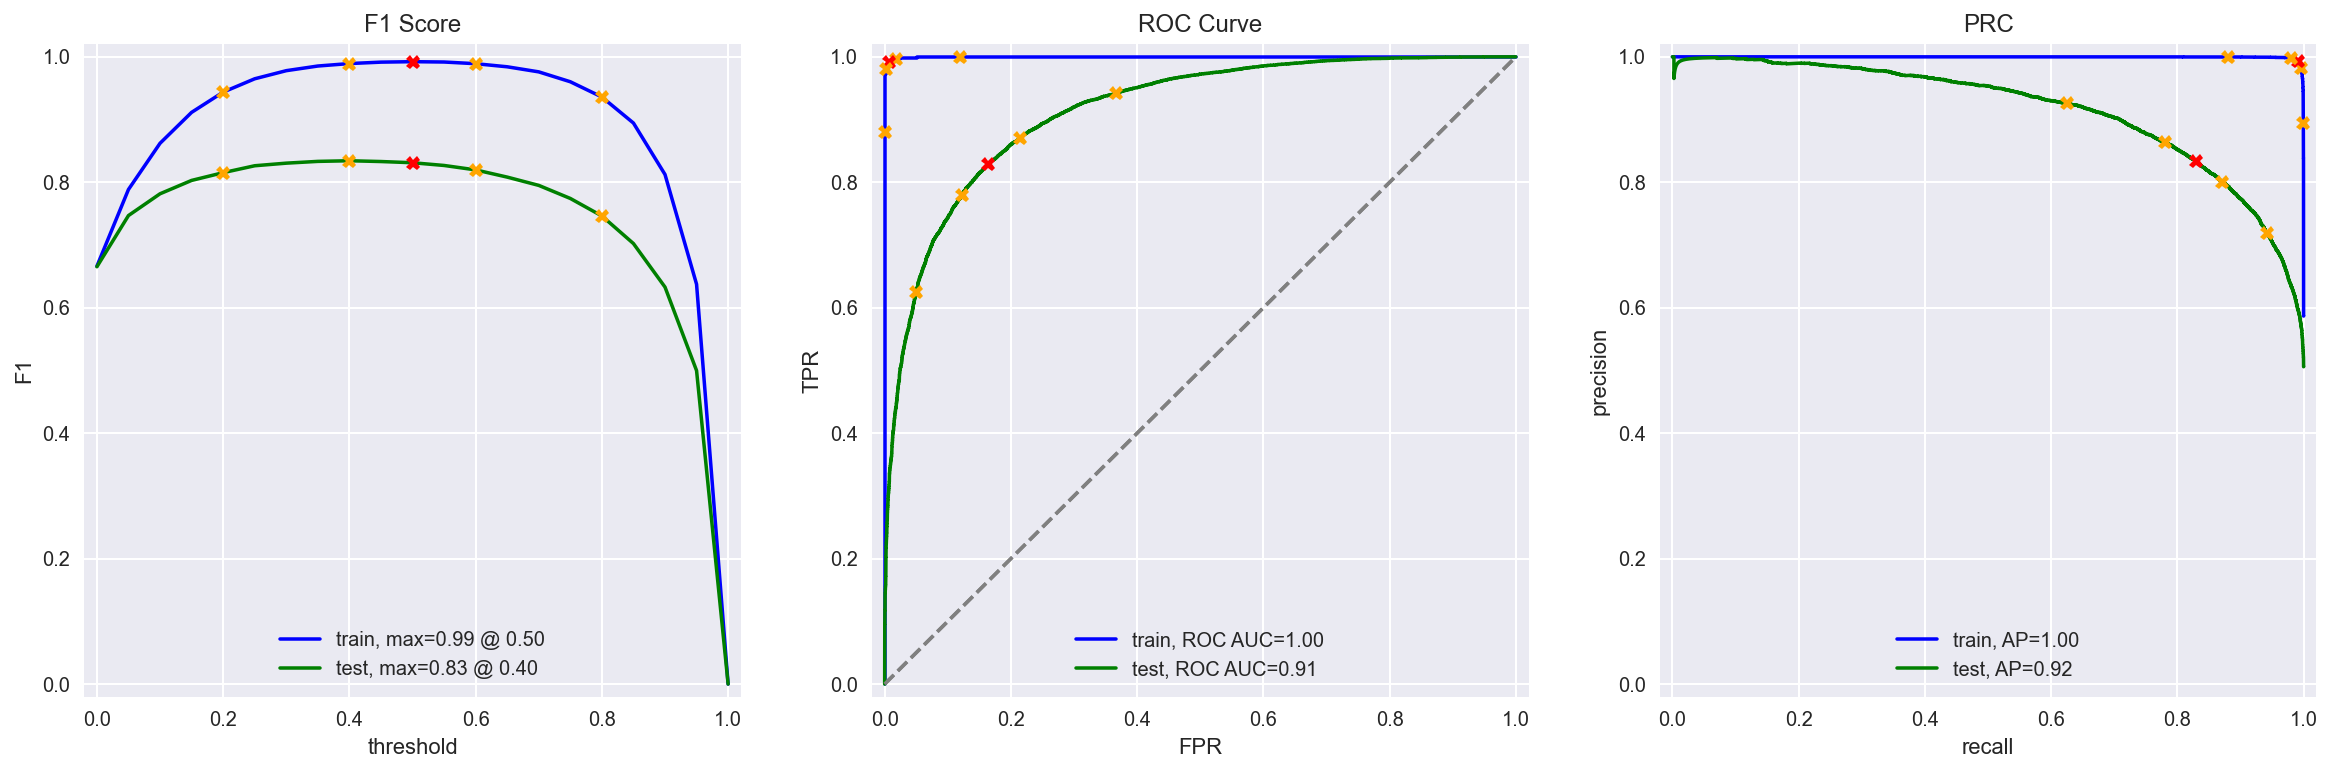

In [124]:
# evalutate the model
evaluate_model(model_4c, train_features_4, train_y, test_features_4, test_y)

The most tuned model seems to have been overfitted on the train set, as we can see almost perfect scores for the train set, while the scores on the test set are worse than our simplest real model.

I'll redo the hyperparameter tuning but this time I'll add cross validation with more folds so that maybe this doesn't happen and we get parameters that will also maximize the results on the test set.

In [136]:
# define objective function for optuna
def objective(trial):

    # parameters to play with
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": 1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # model to use
    model_4c2 = LGBMClassifier(**params)

    # define number of cross validation folds
    kfolds = KFold(n_splits=3, shuffle=True, random_state=13)

    # cross val score to perform cross validation
    scores = cross_val_score(model_4c2, train_features_4, train_y, cv=kfolds, scoring='f1')
    
    return scores.mean()

# create optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# print results
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-18 15:39:53,099] A new study created in memory with name: no-name-387b186a-51ce-4ca1-a21a-0e0e8dd29312


[LightGBM] [Warning] feature_fraction is set=0.9123421737503518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9123421737503518
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] lambda_l1 is set=8.878599646062154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.878599646062154
[LightGBM] [Warning] bagging_fraction is set=0.7313327533587213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7313327533587213
[LightGBM] [Warning] lambda_l2 is set=0.00575969560206897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00575969560206897
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9123421737503518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9123421737503518
[LightGBM] [Warning] min_data_in_leaf is set=68,

[I 2022-08-18 15:40:32,750] Trial 0 finished with value: 0.8243137996002557 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 68, 'lambda_l1': 8.878599646062154, 'lambda_l2': 0.00575969560206897, 'num_leaves': 221, 'feature_fraction': 0.9123421737503518, 'bagging_fraction': 0.7313327533587213, 'bagging_freq': 5, 'min_child_samples': 64}. Best is trial 0 with value: 0.8243137996002557.


[LightGBM] [Warning] feature_fraction is set=0.5798333937801462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5798333937801462
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] lambda_l1 is set=0.43278728183334153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43278728183334153
[LightGBM] [Warning] bagging_fraction is set=0.8922835166691535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8922835166691535
[LightGBM] [Warning] lambda_l2 is set=0.04308431628676083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04308431628676083
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5798333937801462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5798333937801462
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-08-18 15:41:34,517] Trial 1 finished with value: 0.825128434412668 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 58, 'lambda_l1': 0.43278728183334153, 'lambda_l2': 0.04308431628676083, 'num_leaves': 91, 'feature_fraction': 0.5798333937801462, 'bagging_fraction': 0.8922835166691535, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 1 with value: 0.825128434412668.


[LightGBM] [Warning] feature_fraction is set=0.981919192602816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.981919192602816
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] lambda_l1 is set=0.00017447980448711956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017447980448711956
[LightGBM] [Warning] bagging_fraction is set=0.4582709724132404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4582709724132404
[LightGBM] [Warning] lambda_l2 is set=1.4974000687301058e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4974000687301058e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.981919192602816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.981919192602816
[LightGBM] [Warning] min_data_in_lea

[I 2022-08-18 15:44:04,818] Trial 2 finished with value: 0.8237865987128493 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 14, 'lambda_l1': 0.00017447980448711956, 'lambda_l2': 1.4974000687301058e-08, 'num_leaves': 157, 'feature_fraction': 0.981919192602816, 'bagging_fraction': 0.4582709724132404, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 1 with value: 0.825128434412668.


[LightGBM] [Warning] feature_fraction is set=0.46271622050859273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46271622050859273
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] lambda_l1 is set=4.24215515615599e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.24215515615599e-08
[LightGBM] [Warning] bagging_fraction is set=0.7577634021471167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7577634021471167
[LightGBM] [Warning] lambda_l2 is set=2.4431978986442043e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4431978986442043e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.46271622050859273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46271622050859273
[LightGBM] [Warning] min_data_in

[I 2022-08-18 15:45:30,880] Trial 3 finished with value: 0.822854158807401 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 39, 'lambda_l1': 4.24215515615599e-08, 'lambda_l2': 2.4431978986442043e-08, 'num_leaves': 249, 'feature_fraction': 0.46271622050859273, 'bagging_fraction': 0.7577634021471167, 'bagging_freq': 1, 'min_child_samples': 61}. Best is trial 1 with value: 0.825128434412668.


[LightGBM] [Warning] feature_fraction is set=0.450567402591385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.450567402591385
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] lambda_l1 is set=2.2821139687392424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2821139687392424
[LightGBM] [Warning] bagging_fraction is set=0.4030437606531679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4030437606531679
[LightGBM] [Warning] lambda_l2 is set=0.5276035081288153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5276035081288153
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.450567402591385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.450567402591385
[LightGBM] [Warning] min_data_in_leaf is set=97, min

[I 2022-08-18 15:45:48,789] Trial 4 finished with value: 0.8199255411411474 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 97, 'lambda_l1': 2.2821139687392424, 'lambda_l2': 0.5276035081288153, 'num_leaves': 56, 'feature_fraction': 0.450567402591385, 'bagging_fraction': 0.4030437606531679, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 1 with value: 0.825128434412668.


[LightGBM] [Warning] feature_fraction is set=0.7063882841780807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7063882841780807
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] lambda_l1 is set=0.00010865332934454357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010865332934454357
[LightGBM] [Warning] bagging_fraction is set=0.5394749501248792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5394749501248792
[LightGBM] [Warning] lambda_l2 is set=0.027263027025271606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.027263027025271606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7063882841780807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7063882841780807
[LightGBM] [Warning] min_data_in_lea

[I 2022-08-18 15:46:35,382] Trial 5 finished with value: 0.8242627735398753 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 86, 'lambda_l1': 0.00010865332934454357, 'lambda_l2': 0.027263027025271606, 'num_leaves': 140, 'feature_fraction': 0.7063882841780807, 'bagging_fraction': 0.5394749501248792, 'bagging_freq': 1, 'min_child_samples': 66}. Best is trial 1 with value: 0.825128434412668.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.9872457688991163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9872457688991163
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambda_l1 is set=0.2923264921152383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2923264921152383
[LightGBM] [Warning] bagging_fraction is set=0.7314395250587178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7314395250587178
[LightGBM] [Warning] lambda_l2 is set=2.2651565718642027e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2651565718642027e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9872457688991163, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-08-18 15:48:40,877] Trial 6 finished with value: 0.8222894982110648 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 18, 'lambda_l1': 0.2923264921152383, 'lambda_l2': 2.2651565718642027e-07, 'num_leaves': 101, 'feature_fraction': 0.9872457688991163, 'bagging_fraction': 0.7314395250587178, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 1 with value: 0.825128434412668.


[LightGBM] [Warning] feature_fraction is set=0.7704752013976075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7704752013976075
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] lambda_l1 is set=0.0009741868014425234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009741868014425234
[LightGBM] [Warning] bagging_fraction is set=0.5548935314254877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5548935314254877
[LightGBM] [Warning] lambda_l2 is set=0.14722478945901488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14722478945901488
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7704752013976075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7704752013976075
[LightGBM] [Warning] min_data_in_leaf is

[I 2022-08-18 15:49:50,366] Trial 7 finished with value: 0.8237191446167563 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 57, 'lambda_l1': 0.0009741868014425234, 'lambda_l2': 0.14722478945901488, 'num_leaves': 171, 'feature_fraction': 0.7704752013976075, 'bagging_fraction': 0.5548935314254877, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 1 with value: 0.825128434412668.


[LightGBM] [Warning] feature_fraction is set=0.9044314810730999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9044314810730999
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] lambda_l1 is set=0.00028345032810337756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028345032810337756
[LightGBM] [Warning] bagging_fraction is set=0.655142015890505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.655142015890505
[LightGBM] [Warning] lambda_l2 is set=0.006781531429990437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006781531429990437
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9044314810730999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9044314810730999
[LightGBM] [Warning] min_data_in_leaf 

[I 2022-08-18 15:50:38,112] Trial 8 finished with value: 0.8313660491606595 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 51, 'lambda_l1': 0.00028345032810337756, 'lambda_l2': 0.006781531429990437, 'num_leaves': 37, 'feature_fraction': 0.9044314810730999, 'bagging_fraction': 0.655142015890505, 'bagging_freq': 1, 'min_child_samples': 54}. Best is trial 8 with value: 0.8313660491606595.


[LightGBM] [Warning] feature_fraction is set=0.6528608403442289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6528608403442289
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] lambda_l1 is set=1.4453225575253423e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4453225575253423e-06
[LightGBM] [Warning] bagging_fraction is set=0.5896506424150971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5896506424150971
[LightGBM] [Warning] lambda_l2 is set=0.00017013519400306738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017013519400306738
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6528608403442289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6528608403442289
[LightGBM] [Warning] min_data_in

[I 2022-08-18 15:51:21,515] Trial 9 finished with value: 0.8213964695921748 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 96, 'lambda_l1': 1.4453225575253423e-06, 'lambda_l2': 0.00017013519400306738, 'num_leaves': 123, 'feature_fraction': 0.6528608403442289, 'bagging_fraction': 0.5896506424150971, 'bagging_freq': 4, 'min_child_samples': 81}. Best is trial 8 with value: 0.8313660491606595.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.828054568687269, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.828054568687269
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l1 is set=0.004226430547033838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004226430547033838
[LightGBM] [Warning] bagging_fraction is set=0.9678342388638462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9678342388638462
[LightGBM] [Warning] lambda_l2 is set=3.0221772757174274e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0221772757174274e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.828054568687269, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-08-18 15:51:31,930] Trial 10 finished with value: 0.7931145092804844 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 35, 'lambda_l1': 0.004226430547033838, 'lambda_l2': 3.0221772757174274e-05, 'num_leaves': 2, 'feature_fraction': 0.828054568687269, 'bagging_fraction': 0.9678342388638462, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 8 with value: 0.8313660491606595.


[LightGBM] [Warning] feature_fraction is set=0.6125169742530169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6125169742530169
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] lambda_l1 is set=0.054475491153227876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.054475491153227876
[LightGBM] [Warning] bagging_fraction is set=0.9139732917488566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9139732917488566
[LightGBM] [Warning] lambda_l2 is set=8.758301015049986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.758301015049986
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6125169742530169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6125169742530169
[LightGBM] [Warning] min_data_in_leaf is set=6

[I 2022-08-18 15:52:12,738] Trial 11 finished with value: 0.8306155776757264 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 69, 'lambda_l1': 0.054475491153227876, 'lambda_l2': 8.758301015049986, 'num_leaves': 53, 'feature_fraction': 0.6125169742530169, 'bagging_fraction': 0.9139732917488566, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 8 with value: 0.8313660491606595.


[LightGBM] [Warning] feature_fraction is set=0.5805541284734621, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5805541284734621
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] lambda_l1 is set=0.022313065367731456, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022313065367731456
[LightGBM] [Warning] bagging_fraction is set=0.8447581293601095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8447581293601095
[LightGBM] [Warning] lambda_l2 is set=5.8135234011203325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8135234011203325
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5805541284734621, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5805541284734621
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-08-18 15:52:37,365] Trial 12 finished with value: 0.8286619764399932 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 75, 'lambda_l1': 0.022313065367731456, 'lambda_l2': 5.8135234011203325, 'num_leaves': 21, 'feature_fraction': 0.5805541284734621, 'bagging_fraction': 0.8447581293601095, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 8 with value: 0.8313660491606595.


[LightGBM] [Warning] feature_fraction is set=0.871690065381164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.871690065381164
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] lambda_l1 is set=4.182597688057092e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.182597688057092e-06
[LightGBM] [Warning] bagging_fraction is set=0.9977490395689561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9977490395689561
[LightGBM] [Warning] lambda_l2 is set=5.750267357513788, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.750267357513788
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.871690065381164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.871690065381164
[LightGBM] [Warning] min_data_in_leaf is set=39,

[I 2022-08-18 15:53:42,043] Trial 13 finished with value: 0.8316132097573307 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 39, 'lambda_l1': 4.182597688057092e-06, 'lambda_l2': 5.750267357513788, 'num_leaves': 52, 'feature_fraction': 0.871690065381164, 'bagging_fraction': 0.9977490395689561, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 13 with value: 0.8316132097573307.


[LightGBM] [Warning] feature_fraction is set=0.86446045142846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.86446045142846
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=5.686655530902752e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.686655530902752e-06
[LightGBM] [Warning] bagging_fraction is set=0.6477223905228754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6477223905228754
[LightGBM] [Warning] lambda_l2 is set=0.0022473629858512706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022473629858512706
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.86446045142846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.86446045142846
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-08-18 15:54:34,975] Trial 14 finished with value: 0.828548675231545 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 42, 'lambda_l1': 5.686655530902752e-06, 'lambda_l2': 0.0022473629858512706, 'num_leaves': 46, 'feature_fraction': 0.86446045142846, 'bagging_fraction': 0.6477223905228754, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 13 with value: 0.8316132097573307.


[LightGBM] [Warning] feature_fraction is set=0.7810375883020653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7810375883020653
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=5.300730476417723e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.300730476417723e-06
[LightGBM] [Warning] bagging_fraction is set=0.8122684912941307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8122684912941307
[LightGBM] [Warning] lambda_l2 is set=3.1786865856363615e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1786865856363615e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7810375883020653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7810375883020653
[LightGBM] [Warning] min_data_in_l

[I 2022-08-18 15:55:53,126] Trial 15 finished with value: 0.8286711898351976 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 30, 'lambda_l1': 5.300730476417723e-06, 'lambda_l2': 3.1786865856363615e-05, 'num_leaves': 79, 'feature_fraction': 0.7810375883020653, 'bagging_fraction': 0.8122684912941307, 'bagging_freq': 2, 'min_child_samples': 75}. Best is trial 13 with value: 0.8316132097573307.


[LightGBM] [Warning] feature_fraction is set=0.9033991825102237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9033991825102237
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] lambda_l1 is set=7.011335073275241e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.011335073275241e-08
[LightGBM] [Warning] bagging_fraction is set=0.6735389696366458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6735389696366458
[LightGBM] [Warning] lambda_l2 is set=1.0852807332844914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0852807332844914
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9033991825102237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9033991825102237
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 15:56:29,024] Trial 16 finished with value: 0.8283795248107101 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 48, 'lambda_l1': 7.011335073275241e-08, 'lambda_l2': 1.0852807332844914, 'num_leaves': 23, 'feature_fraction': 0.9033991825102237, 'bagging_fraction': 0.6735389696366458, 'bagging_freq': 2, 'min_child_samples': 47}. Best is trial 13 with value: 0.8316132097573307.


[LightGBM] [Warning] feature_fraction is set=0.9278007813846755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9278007813846755
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l1 is set=2.93949003427123e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.93949003427123e-07
[LightGBM] [Warning] bagging_fraction is set=0.9814082359370909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9814082359370909
[LightGBM] [Warning] lambda_l2 is set=4.856026691490033e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.856026691490033e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9278007813846755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9278007813846755
[LightGBM] [Warning] min_data_in_leaf 

[I 2022-08-18 15:57:55,939] Trial 17 finished with value: 0.8303551236612718 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 26, 'lambda_l1': 2.93949003427123e-07, 'lambda_l2': 4.856026691490033e-06, 'num_leaves': 69, 'feature_fraction': 0.9278007813846755, 'bagging_fraction': 0.9814082359370909, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 13 with value: 0.8316132097573307.


[LightGBM] [Warning] feature_fraction is set=0.7559869815144943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7559869815144943
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=5.3547046879151285e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.3547046879151285e-05
[LightGBM] [Warning] bagging_fraction is set=0.6301885043367865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6301885043367865
[LightGBM] [Warning] lambda_l2 is set=0.0019073150666972854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019073150666972854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7559869815144943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7559869815144943
[LightGBM] [Warning] min_data_in_l

[I 2022-08-18 15:58:27,001] Trial 18 finished with value: 0.8306153654570934 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 50, 'lambda_l1': 5.3547046879151285e-05, 'lambda_l2': 0.0019073150666972854, 'num_leaves': 24, 'feature_fraction': 0.7559869815144943, 'bagging_fraction': 0.6301885043367865, 'bagging_freq': 1, 'min_child_samples': 79}. Best is trial 13 with value: 0.8316132097573307.


[LightGBM] [Warning] feature_fraction is set=0.8286627505169545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8286627505169545
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] lambda_l1 is set=1.5237039446570371e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5237039446570371e-05
[LightGBM] [Warning] bagging_fraction is set=0.797503810529491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.797503810529491
[LightGBM] [Warning] lambda_l2 is set=0.7820099346644434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7820099346644434
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8286627505169545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8286627505169545
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 16:00:38,867] Trial 19 finished with value: 0.8287577736279724 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 25, 'lambda_l1': 1.5237039446570371e-05, 'lambda_l2': 0.7820099346644434, 'num_leaves': 196, 'feature_fraction': 0.8286627505169545, 'bagging_fraction': 0.797503810529491, 'bagging_freq': 4, 'min_child_samples': 44}. Best is trial 13 with value: 0.8316132097573307.


[LightGBM] [Warning] feature_fraction is set=0.6960829092853293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6960829092853293
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] lambda_l1 is set=0.0019648559695606507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019648559695606507
[LightGBM] [Warning] bagging_fraction is set=0.4686021005629042, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4686021005629042
[LightGBM] [Warning] lambda_l2 is set=9.440792700634326e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.440792700634326e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6960829092853293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6960829092853293
[LightGBM] [Warning] min_data_in_lea

[I 2022-08-18 16:00:46,929] Trial 20 finished with value: 0.7925740050688123 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 61, 'lambda_l1': 0.0019648559695606507, 'lambda_l2': 9.440792700634326e-07, 'num_leaves': 2, 'feature_fraction': 0.6960829092853293, 'bagging_fraction': 0.4686021005629042, 'bagging_freq': 2, 'min_child_samples': 28}. Best is trial 13 with value: 0.8316132097573307.


[LightGBM] [Warning] feature_fraction is set=0.5863202602975744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5863202602975744
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] lambda_l1 is set=0.02108266422785132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02108266422785132
[LightGBM] [Warning] bagging_fraction is set=0.9077064593568174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9077064593568174
[LightGBM] [Warning] lambda_l2 is set=6.235981912567697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.235981912567697
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5863202602975744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5863202602975744
[LightGBM] [Warning] min_data_in_leaf is set=75,

[I 2022-08-18 16:01:25,604] Trial 21 finished with value: 0.8313375111527962 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 75, 'lambda_l1': 0.02108266422785132, 'lambda_l2': 6.235981912567697, 'num_leaves': 48, 'feature_fraction': 0.5863202602975744, 'bagging_fraction': 0.9077064593568174, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 13 with value: 0.8316132097573307.


[LightGBM] [Warning] feature_fraction is set=0.5150797994258665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5150797994258665
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] lambda_l1 is set=0.011212420931929278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011212420931929278
[LightGBM] [Warning] bagging_fraction is set=0.909448081389677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.909448081389677
[LightGBM] [Warning] lambda_l2 is set=8.271094188403534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.271094188403534
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5150797994258665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5150797994258665
[LightGBM] [Warning] min_data_in_leaf is set=80,

[I 2022-08-18 16:02:04,984] Trial 22 finished with value: 0.8337264839898918 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 80, 'lambda_l1': 0.011212420931929278, 'lambda_l2': 8.271094188403534, 'num_leaves': 113, 'feature_fraction': 0.5150797994258665, 'bagging_fraction': 0.909448081389677, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 22 with value: 0.8337264839898918.


[LightGBM] [Warning] feature_fraction is set=0.5063024163080153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5063024163080153
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] lambda_l1 is set=0.0007402116825059701, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007402116825059701
[LightGBM] [Warning] bagging_fraction is set=0.9987487775222169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9987487775222169
[LightGBM] [Warning] lambda_l2 is set=0.129164877589699, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.129164877589699
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5063024163080153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5063024163080153
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-08-18 16:03:03,200] Trial 23 finished with value: 0.8336466002122074 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 86, 'lambda_l1': 0.0007402116825059701, 'lambda_l2': 0.129164877589699, 'num_leaves': 105, 'feature_fraction': 0.5063024163080153, 'bagging_fraction': 0.9987487775222169, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 22 with value: 0.8337264839898918.


[LightGBM] [Warning] feature_fraction is set=0.509507837005589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509507837005589
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] lambda_l1 is set=9.052711761679274e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.052711761679274e-07
[LightGBM] [Warning] bagging_fraction is set=0.997505798982066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.997505798982066
[LightGBM] [Warning] lambda_l2 is set=1.2293291677359035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2293291677359035
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.509507837005589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509507837005589
[LightGBM] [Warning] min_data_in_leaf is set=87,

[I 2022-08-18 16:03:55,932] Trial 24 finished with value: 0.8348281451032981 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 87, 'lambda_l1': 9.052711761679274e-07, 'lambda_l2': 1.2293291677359035, 'num_leaves': 119, 'feature_fraction': 0.509507837005589, 'bagging_fraction': 0.997505798982066, 'bagging_freq': 6, 'min_child_samples': 71}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5081053846739295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5081053846739295
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] lambda_l1 is set=0.005438730930685755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005438730930685755
[LightGBM] [Warning] bagging_fraction is set=0.9487143594783604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9487143594783604
[LightGBM] [Warning] lambda_l2 is set=0.15993245503270778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15993245503270778
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5081053846739295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5081053846739295
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 16:04:50,447] Trial 25 finished with value: 0.8306243212448056 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 87, 'lambda_l1': 0.005438730930685755, 'lambda_l2': 0.15993245503270778, 'num_leaves': 119, 'feature_fraction': 0.5081053846739295, 'bagging_fraction': 0.9487143594783604, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.40380364007179037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40380364007179037
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] lambda_l1 is set=1.0314157083452208e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0314157083452208e-08
[LightGBM] [Warning] bagging_fraction is set=0.85772077201494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85772077201494
[LightGBM] [Warning] lambda_l2 is set=0.8150596491502338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8150596491502338
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.40380364007179037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40380364007179037
[LightGBM] [Warning] min_data_in_leaf is

[I 2022-08-18 16:05:29,649] Trial 26 finished with value: 0.833251852620577 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 88, 'lambda_l1': 1.0314157083452208e-08, 'lambda_l2': 0.8150596491502338, 'num_leaves': 100, 'feature_fraction': 0.40380364007179037, 'bagging_fraction': 0.85772077201494, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5188409015442201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5188409015442201
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] lambda_l1 is set=3.727309977710112e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.727309977710112e-05
[LightGBM] [Warning] bagging_fraction is set=0.9261856019281262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9261856019281262
[LightGBM] [Warning] lambda_l2 is set=0.05800636849193503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05800636849193503
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5188409015442201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5188409015442201
[LightGBM] [Warning] min_data_in_leaf is

[I 2022-08-18 16:06:30,870] Trial 27 finished with value: 0.8319430274792255 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 76, 'lambda_l1': 3.727309977710112e-05, 'lambda_l2': 0.05800636849193503, 'num_leaves': 139, 'feature_fraction': 0.5188409015442201, 'bagging_fraction': 0.9261856019281262, 'bagging_freq': 5, 'min_child_samples': 68}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5109619131191246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5109619131191246
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] lambda_l1 is set=0.0882715591770028, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0882715591770028
[LightGBM] [Warning] bagging_fraction is set=0.8588639488012126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8588639488012126
[LightGBM] [Warning] lambda_l2 is set=1.6965963830941775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6965963830941775
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5109619131191246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5109619131191246
[LightGBM] [Warning] min_data_in_leaf is set=81,

[I 2022-08-18 16:07:17,774] Trial 28 finished with value: 0.8312435170619933 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 81, 'lambda_l1': 0.0882715591770028, 'lambda_l2': 1.6965963830941775, 'num_leaves': 165, 'feature_fraction': 0.5109619131191246, 'bagging_fraction': 0.8588639488012126, 'bagging_freq': 6, 'min_child_samples': 86}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.40080592561486283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40080592561486283
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.0005303319134525806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005303319134525806
[LightGBM] [Warning] bagging_fraction is set=0.9956285364431119, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9956285364431119
[LightGBM] [Warning] lambda_l2 is set=0.01080927562589394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01080927562589394
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.40080592561486283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40080592561486283
[LightGBM] [Warning] min_data_in_lea

[I 2022-08-18 16:08:18,365] Trial 29 finished with value: 0.8301757155557045 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 67, 'lambda_l1': 0.0005303319134525806, 'lambda_l2': 0.01080927562589394, 'num_leaves': 190, 'feature_fraction': 0.40080592561486283, 'bagging_fraction': 0.9956285364431119, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5444897553588847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5444897553588847
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] lambda_l1 is set=3.7987227429070696e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7987227429070696e-07
[LightGBM] [Warning] bagging_fraction is set=0.9578981099545666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9578981099545666
[LightGBM] [Warning] lambda_l2 is set=0.23098305541348413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23098305541348413
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5444897553588847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5444897553588847
[LightGBM] [Warning] min_data_in_leaf 

[I 2022-08-18 16:09:13,809] Trial 30 finished with value: 0.8312469799612036 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 94, 'lambda_l1': 3.7987227429070696e-07, 'lambda_l2': 0.23098305541348413, 'num_leaves': 115, 'feature_fraction': 0.5444897553588847, 'bagging_fraction': 0.9578981099545666, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.4029735040715562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4029735040715562
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] lambda_l1 is set=1.1672925470104537e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1672925470104537e-08
[LightGBM] [Warning] bagging_fraction is set=0.8678474325766663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8678474325766663
[LightGBM] [Warning] lambda_l2 is set=1.7389858209033593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7389858209033593
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4029735040715562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4029735040715562
[LightGBM] [Warning] min_data_in_leaf is

[I 2022-08-18 16:09:51,234] Trial 31 finished with value: 0.8313835967785114 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 88, 'lambda_l1': 1.1672925470104537e-08, 'lambda_l2': 1.7389858209033593, 'num_leaves': 100, 'feature_fraction': 0.4029735040715562, 'bagging_fraction': 0.8678474325766663, 'bagging_freq': 6, 'min_child_samples': 71}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.4598164101915847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4598164101915847
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] lambda_l1 is set=1.908300022909324e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.908300022909324e-08
[LightGBM] [Warning] bagging_fraction is set=0.9392347002121126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9392347002121126
[LightGBM] [Warning] lambda_l2 is set=0.23399872022479504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23399872022479504
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4598164101915847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4598164101915847
[LightGBM] [Warning] min_data_in_leaf is

[I 2022-08-18 16:10:34,347] Trial 32 finished with value: 0.8321481251813904 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 91, 'lambda_l1': 1.908300022909324e-08, 'lambda_l2': 0.23399872022479504, 'num_leaves': 82, 'feature_fraction': 0.4598164101915847, 'bagging_fraction': 0.9392347002121126, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.4676370974480134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4676370974480134
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=2.1467290941543463e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1467290941543463e-07
[LightGBM] [Warning] bagging_fraction is set=0.8854747624457155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8854747624457155
[LightGBM] [Warning] lambda_l2 is set=2.3914709838090182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3914709838090182
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4676370974480134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4676370974480134
[LightGBM] [Warning] min_data_in_leaf 

[I 2022-08-18 16:11:13,151] Trial 33 finished with value: 0.8324788402173217 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 100, 'lambda_l1': 2.1467290941543463e-07, 'lambda_l2': 2.3914709838090182, 'num_leaves': 108, 'feature_fraction': 0.4676370974480134, 'bagging_fraction': 0.8854747624457155, 'bagging_freq': 7, 'min_child_samples': 65}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5547568152109389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5547568152109389
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] lambda_l1 is set=6.229661979061489e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.229661979061489e-08
[LightGBM] [Warning] bagging_fraction is set=0.8149093255058766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8149093255058766
[LightGBM] [Warning] lambda_l2 is set=0.03243597919916426, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03243597919916426
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5547568152109389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5547568152109389
[LightGBM] [Warning] min_data_in_leaf is

[I 2022-08-18 16:12:08,413] Trial 34 finished with value: 0.8342108219747361 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 82, 'lambda_l1': 6.229661979061489e-08, 'lambda_l2': 0.03243597919916426, 'num_leaves': 141, 'feature_fraction': 0.5547568152109389, 'bagging_fraction': 0.8149093255058766, 'bagging_freq': 5, 'min_child_samples': 58}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.6268345984536015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6268345984536015
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] lambda_l1 is set=8.741701762828948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.741701762828948
[LightGBM] [Warning] bagging_fraction is set=0.7999458465332995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7999458465332995
[LightGBM] [Warning] lambda_l2 is set=0.047045386381730045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047045386381730045
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6268345984536015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6268345984536015
[LightGBM] [Warning] min_data_in_leaf is set=8

[I 2022-08-18 16:12:36,121] Trial 35 finished with value: 0.83154798195554 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 82, 'lambda_l1': 8.741701762828948, 'lambda_l2': 0.047045386381730045, 'num_leaves': 135, 'feature_fraction': 0.6268345984536015, 'bagging_fraction': 0.7999458465332995, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5555998240531418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5555998240531418
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] lambda_l1 is set=8.248257325027477e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.248257325027477e-08
[LightGBM] [Warning] bagging_fraction is set=0.8284953719556875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8284953719556875
[LightGBM] [Warning] lambda_l2 is set=0.0013933291572683167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013933291572683167
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5555998240531418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5555998240531418
[LightGBM] [Warning] min_data_in_lea

[I 2022-08-18 16:13:36,007] Trial 36 finished with value: 0.8238185139442447 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 80, 'lambda_l1': 8.248257325027477e-08, 'lambda_l2': 0.0013933291572683167, 'num_leaves': 149, 'feature_fraction': 0.5555998240531418, 'bagging_fraction': 0.8284953719556875, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.4852723827092114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4852723827092114
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l1 is set=0.005666056856162957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005666056856162957
[LightGBM] [Warning] bagging_fraction is set=0.8952112655569661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8952112655569661
[LightGBM] [Warning] lambda_l2 is set=0.07594641945009523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07594641945009523
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4852723827092114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4852723827092114
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 16:14:37,024] Trial 37 finished with value: 0.8289735249719973 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 71, 'lambda_l1': 0.005666056856162957, 'lambda_l2': 0.07594641945009523, 'num_leaves': 155, 'feature_fraction': 0.4852723827092114, 'bagging_fraction': 0.8952112655569661, 'bagging_freq': 7, 'min_child_samples': 64}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5478050800553075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5478050800553075
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] lambda_l1 is set=8.856448686728982e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.856448686728982e-07
[LightGBM] [Warning] bagging_fraction is set=0.7554318259845337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7554318259845337
[LightGBM] [Warning] lambda_l2 is set=0.025207895873154938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025207895873154938
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5478050800553075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5478050800553075
[LightGBM] [Warning] min_data_in_leaf 

[I 2022-08-18 16:15:28,697] Trial 38 finished with value: 0.8239818818508772 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 65, 'lambda_l1': 8.856448686728982e-07, 'lambda_l2': 0.025207895873154938, 'num_leaves': 89, 'feature_fraction': 0.5478050800553075, 'bagging_fraction': 0.7554318259845337, 'bagging_freq': 5, 'min_child_samples': 39}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.6694047797269946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6694047797269946
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] lambda_l1 is set=0.4506384023289097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4506384023289097
[LightGBM] [Warning] bagging_fraction is set=0.9369187175296495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9369187175296495
[LightGBM] [Warning] lambda_l2 is set=0.4154678145013824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4154678145013824
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6694047797269946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6694047797269946
[LightGBM] [Warning] min_data_in_leaf is set=84,

[I 2022-08-18 16:16:28,924] Trial 39 finished with value: 0.8333849590659397 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 84, 'lambda_l1': 0.4506384023289097, 'lambda_l2': 0.4154678145013824, 'num_leaves': 237, 'feature_fraction': 0.6694047797269946, 'bagging_fraction': 0.9369187175296495, 'bagging_freq': 6, 'min_child_samples': 89}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.4300801934351816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4300801934351816
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] lambda_l1 is set=0.0001508640390610291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001508640390610291
[LightGBM] [Warning] bagging_fraction is set=0.7137625628894653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7137625628894653
[LightGBM] [Warning] lambda_l2 is set=0.013879239183623866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013879239183623866
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4300801934351816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4300801934351816
[LightGBM] [Warning] min_data_in_leaf 

[I 2022-08-18 16:17:08,073] Trial 40 finished with value: 0.8229121347894187 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 92, 'lambda_l1': 0.0001508640390610291, 'lambda_l2': 0.013879239183623866, 'num_leaves': 185, 'feature_fraction': 0.4300801934351816, 'bagging_fraction': 0.7137625628894653, 'bagging_freq': 4, 'min_child_samples': 79}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.6662143595886943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6662143595886943
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] lambda_l1 is set=0.17763135216949533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17763135216949533
[LightGBM] [Warning] bagging_fraction is set=0.9414837061579024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9414837061579024
[LightGBM] [Warning] lambda_l2 is set=0.4033971560265831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4033971560265831
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6662143595886943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6662143595886943
[LightGBM] [Warning] min_data_in_leaf is set=8

[I 2022-08-18 16:18:20,207] Trial 41 finished with value: 0.8335154762780087 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 83, 'lambda_l1': 0.17763135216949533, 'lambda_l2': 0.4033971560265831, 'num_leaves': 250, 'feature_fraction': 0.6662143595886943, 'bagging_fraction': 0.9414837061579024, 'bagging_freq': 7, 'min_child_samples': 89}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.6235696662647263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6235696662647263
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] lambda_l1 is set=0.9437561717845073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9437561717845073
[LightGBM] [Warning] bagging_fraction is set=0.9641067847472624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9641067847472624
[LightGBM] [Warning] lambda_l2 is set=3.1068050725086875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1068050725086875
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6235696662647263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6235696662647263
[LightGBM] [Warning] min_data_in_leaf is set=80,

[I 2022-08-18 16:19:08,230] Trial 42 finished with value: 0.8318272187298895 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 80, 'lambda_l1': 0.9437561717845073, 'lambda_l2': 3.1068050725086875, 'num_leaves': 132, 'feature_fraction': 0.6235696662647263, 'bagging_fraction': 0.9641067847472624, 'bagging_freq': 7, 'min_child_samples': 62}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.49447209261858255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49447209261858255
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] lambda_l1 is set=0.14825847477153026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14825847477153026
[LightGBM] [Warning] bagging_fraction is set=0.8837197317117796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8837197317117796
[LightGBM] [Warning] lambda_l2 is set=0.14633057408221645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14633057408221645
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.49447209261858255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49447209261858255
[LightGBM] [Warning] min_data_in_leaf is

[I 2022-08-18 16:19:55,531] Trial 43 finished with value: 0.8326686398947206 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 98, 'lambda_l1': 0.14825847477153026, 'lambda_l2': 0.14633057408221645, 'num_leaves': 210, 'feature_fraction': 0.49447209261858255, 'bagging_fraction': 0.8837197317117796, 'bagging_freq': 7, 'min_child_samples': 85}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5327153004793196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5327153004793196
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] lambda_l1 is set=0.027672313607069458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.027672313607069458
[LightGBM] [Warning] bagging_fraction is set=0.9749884092886596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9749884092886596
[LightGBM] [Warning] lambda_l2 is set=0.4046735691566832, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4046735691566832
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5327153004793196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5327153004793196
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-08-18 16:21:00,977] Trial 44 finished with value: 0.8323394178152138 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 73, 'lambda_l1': 0.027672313607069458, 'lambda_l2': 0.4046735691566832, 'num_leaves': 250, 'feature_fraction': 0.5327153004793196, 'bagging_fraction': 0.9749884092886596, 'bagging_freq': 6, 'min_child_samples': 93}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5873872311610908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5873872311610908
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] lambda_l1 is set=0.0018225610063770117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018225610063770117
[LightGBM] [Warning] bagging_fraction is set=0.7745363651520978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7745363651520978
[LightGBM] [Warning] lambda_l2 is set=0.0005340414350885657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005340414350885657
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5873872311610908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5873872311610908
[LightGBM] [Warning] min_data_in_lea

[I 2022-08-18 16:21:48,786] Trial 45 finished with value: 0.8295994732795972 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 78, 'lambda_l1': 0.0018225610063770117, 'lambda_l2': 0.0005340414350885657, 'num_leaves': 72, 'feature_fraction': 0.5873872311610908, 'bagging_fraction': 0.7745363651520978, 'bagging_freq': 7, 'min_child_samples': 67}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.4392478579536575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4392478579536575
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] lambda_l1 is set=3.0044652065981516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0044652065981516
[LightGBM] [Warning] bagging_fraction is set=0.9213123726616872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9213123726616872
[LightGBM] [Warning] lambda_l2 is set=0.09164582879345953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09164582879345953
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4392478579536575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4392478579536575
[LightGBM] [Warning] min_data_in_leaf is set=

[I 2022-08-18 16:22:23,697] Trial 46 finished with value: 0.8297097637831591 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 62, 'lambda_l1': 3.0044652065981516, 'lambda_l2': 0.09164582879345953, 'num_leaves': 213, 'feature_fraction': 0.4392478579536575, 'bagging_fraction': 0.9213123726616872, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.721401581576343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.721401581576343
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] lambda_l1 is set=0.015470234363430152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015470234363430152
[LightGBM] [Warning] bagging_fraction is set=0.9915064593183911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9915064593183911
[LightGBM] [Warning] lambda_l2 is set=0.004462656483295951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004462656483295951
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.721401581576343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.721401581576343
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-08-18 16:23:39,907] Trial 47 finished with value: 0.8234027693152349 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 91, 'lambda_l1': 0.015470234363430152, 'lambda_l2': 0.004462656483295951, 'num_leaves': 124, 'feature_fraction': 0.721401581576343, 'bagging_fraction': 0.9915064593183911, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.4813219806215193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4813219806215193
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] lambda_l1 is set=0.008963649101634233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008963649101634233
[LightGBM] [Warning] bagging_fraction is set=0.910813424564364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.910813424564364
[LightGBM] [Warning] lambda_l2 is set=3.3414446024487647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3414446024487647
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4813219806215193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4813219806215193
[LightGBM] [Warning] min_data_in_leaf is set=8

[I 2022-08-18 16:24:22,640] Trial 48 finished with value: 0.8308003943081353 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 86, 'lambda_l1': 0.008963649101634233, 'lambda_l2': 3.3414446024487647, 'num_leaves': 175, 'feature_fraction': 0.4813219806215193, 'bagging_fraction': 0.910813424564364, 'bagging_freq': 7, 'min_child_samples': 76}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.649768676152643, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.649768676152643
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] lambda_l1 is set=0.0007888602459903653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007888602459903653
[LightGBM] [Warning] bagging_fraction is set=0.9595568745532275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9595568745532275
[LightGBM] [Warning] lambda_l2 is set=8.42344631522786, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.42344631522786
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.649768676152643, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.649768676152643
[LightGBM] [Warning] min_data_in_leaf is set=70, m

[I 2022-08-18 16:25:14,821] Trial 49 finished with value: 0.8311782674024517 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 70, 'lambda_l1': 0.0007888602459903653, 'lambda_l2': 8.42344631522786, 'num_leaves': 238, 'feature_fraction': 0.649768676152643, 'bagging_fraction': 0.9595568745532275, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5670793065065713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5670793065065713
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] lambda_l1 is set=1.4887481797738836e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4887481797738836e-06
[LightGBM] [Warning] bagging_fraction is set=0.9996570952242534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996570952242534
[LightGBM] [Warning] lambda_l2 is set=2.8828314709211488e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8828314709211488e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5670793065065713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5670793065065713
[LightGBM] [Warning] min_data_in

[I 2022-08-18 16:26:15,294] Trial 50 finished with value: 0.8307291673792111 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 95, 'lambda_l1': 1.4887481797738836e-06, 'lambda_l2': 2.8828314709211488e-08, 'num_leaves': 147, 'feature_fraction': 0.5670793065065713, 'bagging_fraction': 0.9996570952242534, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.6643416666186849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643416666186849
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] lambda_l1 is set=0.5622850335743532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5622850335743532
[LightGBM] [Warning] bagging_fraction is set=0.9358065086734406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9358065086734406
[LightGBM] [Warning] lambda_l2 is set=0.5283183605538626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5283183605538626
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6643416666186849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643416666186849
[LightGBM] [Warning] min_data_in_leaf is set=84,

[I 2022-08-18 16:27:15,101] Trial 51 finished with value: 0.8305759234280207 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 84, 'lambda_l1': 0.5622850335743532, 'lambda_l2': 0.5283183605538626, 'num_leaves': 226, 'feature_fraction': 0.6643416666186849, 'bagging_fraction': 0.9358065086734406, 'bagging_freq': 6, 'min_child_samples': 93}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.6833918990082407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6833918990082407
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] lambda_l1 is set=0.17042247081236916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17042247081236916
[LightGBM] [Warning] bagging_fraction is set=0.9401173475730416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9401173475730416
[LightGBM] [Warning] lambda_l2 is set=0.3770225310905989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3770225310905989
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6833918990082407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6833918990082407
[LightGBM] [Warning] min_data_in_leaf is set=8

[I 2022-08-18 16:28:26,669] Trial 52 finished with value: 0.8302335593265578 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 85, 'lambda_l1': 0.17042247081236916, 'lambda_l2': 0.3770225310905989, 'num_leaves': 256, 'feature_fraction': 0.6833918990082407, 'bagging_fraction': 0.9401173475730416, 'bagging_freq': 6, 'min_child_samples': 90}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.7421184848223259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7421184848223259
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] lambda_l1 is set=1.4751825083457386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4751825083457386
[LightGBM] [Warning] bagging_fraction is set=0.8299647720389852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8299647720389852
[LightGBM] [Warning] lambda_l2 is set=0.9010826869100381, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9010826869100381
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7421184848223259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7421184848223259
[LightGBM] [Warning] min_data_in_leaf is set=77,

[I 2022-08-18 16:29:16,188] Trial 53 finished with value: 0.8322249542517485 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 77, 'lambda_l1': 1.4751825083457386, 'lambda_l2': 0.9010826869100381, 'num_leaves': 242, 'feature_fraction': 0.7421184848223259, 'bagging_fraction': 0.8299647720389852, 'bagging_freq': 5, 'min_child_samples': 69}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.6003742419924956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6003742419924956
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] lambda_l1 is set=0.05291727791098982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05291727791098982
[LightGBM] [Warning] bagging_fraction is set=0.9755383095343915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9755383095343915
[LightGBM] [Warning] lambda_l2 is set=0.014822369896984617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014822369896984617
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6003742419924956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6003742419924956
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 16:30:44,276] Trial 54 finished with value: 0.831614628750752 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 83, 'lambda_l1': 0.05291727791098982, 'lambda_l2': 0.014822369896984617, 'num_leaves': 231, 'feature_fraction': 0.6003742419924956, 'bagging_fraction': 0.9755383095343915, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.6410467248218337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6410467248218337
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] lambda_l1 is set=0.4385801801015569, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4385801801015569
[LightGBM] [Warning] bagging_fraction is set=0.8871550988081975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8871550988081975
[LightGBM] [Warning] lambda_l2 is set=1.4815527443020404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4815527443020404
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6410467248218337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6410467248218337
[LightGBM] [Warning] min_data_in_leaf is set=90,

[I 2022-08-18 16:31:43,584] Trial 55 finished with value: 0.8315806706002481 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 90, 'lambda_l1': 0.4385801801015569, 'lambda_l2': 1.4815527443020404, 'num_leaves': 92, 'feature_fraction': 0.6410467248218337, 'bagging_fraction': 0.8871550988081975, 'bagging_freq': 7, 'min_child_samples': 83}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5308809423027353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5308809423027353
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] lambda_l1 is set=5.17064757905597e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.17064757905597e-08
[LightGBM] [Warning] bagging_fraction is set=0.9195524797795088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9195524797795088
[LightGBM] [Warning] lambda_l2 is set=0.3736925544801157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3736925544801157
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5308809423027353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5308809423027353
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-08-18 16:33:05,524] Trial 56 finished with value: 0.830019731217457 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 54, 'lambda_l1': 5.17064757905597e-08, 'lambda_l2': 0.3736925544801157, 'num_leaves': 111, 'feature_fraction': 0.5308809423027353, 'bagging_fraction': 0.9195524797795088, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.7181190173535579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7181190173535579
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] lambda_l1 is set=0.0003409478241780475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003409478241780475
[LightGBM] [Warning] bagging_fraction is set=0.9518203283249728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9518203283249728
[LightGBM] [Warning] lambda_l2 is set=0.03583022032821145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03583022032821145
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7181190173535579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7181190173535579
[LightGBM] [Warning] min_data_in_leaf is

[I 2022-08-18 16:34:10,038] Trial 57 finished with value: 0.8203872110770734 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 72, 'lambda_l1': 0.0003409478241780475, 'lambda_l2': 0.03583022032821145, 'num_leaves': 64, 'feature_fraction': 0.7181190173535579, 'bagging_fraction': 0.9518203283249728, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.6703446872183884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6703446872183884
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] lambda_l1 is set=0.001482442197026398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001482442197026398
[LightGBM] [Warning] bagging_fraction is set=0.9754608717200184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9754608717200184
[LightGBM] [Warning] lambda_l2 is set=3.796009296966764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.796009296966764
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6703446872183884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6703446872183884
[LightGBM] [Warning] min_data_in_leaf is set=7

[I 2022-08-18 16:35:12,390] Trial 58 finished with value: 0.8310137514714975 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 79, 'lambda_l1': 0.001482442197026398, 'lambda_l2': 3.796009296966764, 'num_leaves': 216, 'feature_fraction': 0.6703446872183884, 'bagging_fraction': 0.9754608717200184, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.8007631425661419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8007631425661419
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] lambda_l1 is set=0.23219563700562462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23219563700562462
[LightGBM] [Warning] bagging_fraction is set=0.8389678901579953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8389678901579953
[LightGBM] [Warning] lambda_l2 is set=9.78954767444225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.78954767444225
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8007631425661419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8007631425661419
[LightGBM] [Warning] min_data_in_leaf is set=95, m

[I 2022-08-18 16:36:03,026] Trial 59 finished with value: 0.8312532108155487 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 95, 'lambda_l1': 0.23219563700562462, 'lambda_l2': 9.78954767444225, 'num_leaves': 127, 'feature_fraction': 0.8007631425661419, 'bagging_fraction': 0.8389678901579953, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5695814850227207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5695814850227207
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] lambda_l1 is set=1.8086109910756436e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8086109910756436e-05
[LightGBM] [Warning] bagging_fraction is set=0.9020690276811404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9020690276811404
[LightGBM] [Warning] lambda_l2 is set=6.754600140592714e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.754600140592714e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5695814850227207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5695814850227207
[LightGBM] [Warning] min_data_in_l

[I 2022-08-18 16:37:17,978] Trial 60 finished with value: 0.8313597294585188 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 74, 'lambda_l1': 1.8086109910756436e-05, 'lambda_l2': 6.754600140592714e-05, 'num_leaves': 201, 'feature_fraction': 0.5695814850227207, 'bagging_fraction': 0.9020690276811404, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.43081620786135116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43081620786135116
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=74 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] lambda_l1 is set=3.1236830870938344e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1236830870938344e-08
[LightGBM] [Warning] bagging_fraction is set=0.8557588894591986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8557588894591986
[LightGBM] [Warning] lambda_l2 is set=0.8818824272675443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8818824272675443
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.43081620786135116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43081620786135116
[LightGBM] [Warning] min_data_in_lea

[I 2022-08-18 16:38:00,349] Trial 61 finished with value: 0.8331681226401472 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 89, 'lambda_l1': 3.1236830870938344e-08, 'lambda_l2': 0.8818824272675443, 'num_leaves': 102, 'feature_fraction': 0.43081620786135116, 'bagging_fraction': 0.8557588894591986, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5114615038655442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5114615038655442
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] lambda_l1 is set=1.4926583773908273e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4926583773908273e-07
[LightGBM] [Warning] bagging_fraction is set=0.867095214228337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867095214228337
[LightGBM] [Warning] lambda_l2 is set=0.1364932742518545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1364932742518545
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5114615038655442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5114615038655442
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 16:38:52,786] Trial 62 finished with value: 0.832596926429324 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 87, 'lambda_l1': 1.4926583773908273e-07, 'lambda_l2': 0.1364932742518545, 'num_leaves': 98, 'feature_fraction': 0.5114615038655442, 'bagging_fraction': 0.867095214228337, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.605581219978837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.605581219978837
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] lambda_l1 is set=2.242050706174724e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.242050706174724e-08
[LightGBM] [Warning] bagging_fraction is set=0.9353940641178629, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9353940641178629
[LightGBM] [Warning] lambda_l2 is set=0.7541864150070047, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7541864150070047
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.605581219978837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.605581219978837
[LightGBM] [Warning] min_data_in_leaf is set=8

[I 2022-08-18 16:39:52,302] Trial 63 finished with value: 0.8320902944767878 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 83, 'lambda_l1': 2.242050706174724e-08, 'lambda_l2': 0.7541864150070047, 'num_leaves': 84, 'feature_fraction': 0.605581219978837, 'bagging_fraction': 0.9353940641178629, 'bagging_freq': 5, 'min_child_samples': 80}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.4661986838653571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4661986838653571
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] lambda_l1 is set=1.1428195625635653e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1428195625635653e-08
[LightGBM] [Warning] bagging_fraction is set=0.8727947551868657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8727947551868657
[LightGBM] [Warning] lambda_l2 is set=0.27733163359334423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27733163359334423
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4661986838653571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4661986838653571
[LightGBM] [Warning] min_data_in_leaf 

[I 2022-08-18 16:40:43,593] Trial 64 finished with value: 0.8297761346257571 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 93, 'lambda_l1': 1.1428195625635653e-08, 'lambda_l2': 0.27733163359334423, 'num_leaves': 118, 'feature_fraction': 0.4661986838653571, 'bagging_fraction': 0.8727947551868657, 'bagging_freq': 6, 'min_child_samples': 64}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.4209831966576461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4209831966576461
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=5.102209460692397e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.102209460692397e-07
[LightGBM] [Warning] bagging_fraction is set=0.9561743296913855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9561743296913855
[LightGBM] [Warning] lambda_l2 is set=1.542158578745998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.542158578745998
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4209831966576461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4209831966576461
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 16:41:25,686] Trial 65 finished with value: 0.8298677304705032 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 100, 'lambda_l1': 5.102209460692397e-07, 'lambda_l2': 1.542158578745998, 'num_leaves': 106, 'feature_fraction': 0.4209831966576461, 'bagging_fraction': 0.9561743296913855, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.49241852116108736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49241852116108736
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=0.05466206516966044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05466206516966044
[LightGBM] [Warning] bagging_fraction is set=0.8096746753285047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8096746753285047
[LightGBM] [Warning] lambda_l2 is set=4.063296042432048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.063296042432048
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.49241852116108736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49241852116108736
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-08-18 16:42:47,775] Trial 66 finished with value: 0.8305275243324609 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 15, 'lambda_l1': 0.05466206516966044, 'lambda_l2': 4.063296042432048, 'num_leaves': 142, 'feature_fraction': 0.49241852116108736, 'bagging_fraction': 0.8096746753285047, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.448992289270393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.448992289270393
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] lambda_l1 is set=9.738833858445523e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.738833858445523e-08
[LightGBM] [Warning] bagging_fraction is set=0.7643534844678377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7643534844678377
[LightGBM] [Warning] lambda_l2 is set=0.10511071702017154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10511071702017154
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.448992289270393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.448992289270393
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-08-18 16:43:32,191] Trial 67 finished with value: 0.830716857340441 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 88, 'lambda_l1': 9.738833858445523e-08, 'lambda_l2': 0.10511071702017154, 'num_leaves': 97, 'feature_fraction': 0.448992289270393, 'bagging_fraction': 0.7643534844678377, 'bagging_freq': 5, 'min_child_samples': 77}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5273791522063592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5273791522063592
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] lambda_l1 is set=2.6129656176673403e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6129656176673403e-06
[LightGBM] [Warning] bagging_fraction is set=0.9821839269402173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9821839269402173
[LightGBM] [Warning] lambda_l2 is set=0.028831094887392827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.028831094887392827
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5273791522063592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5273791522063592
[LightGBM] [Warning] min_data_in_lea

[I 2022-08-18 16:44:37,960] Trial 68 finished with value: 0.8321536460995667 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 85, 'lambda_l1': 2.6129656176673403e-06, 'lambda_l2': 0.028831094887392827, 'num_leaves': 161, 'feature_fraction': 0.5273791522063592, 'bagging_fraction': 0.9821839269402173, 'bagging_freq': 7, 'min_child_samples': 44}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.6998875619474947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6998875619474947
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] lambda_l1 is set=3.7629026152497036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7629026152497036
[LightGBM] [Warning] bagging_fraction is set=0.4153292059278754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4153292059278754
[LightGBM] [Warning] lambda_l2 is set=0.6561744378393969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6561744378393969
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6998875619474947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6998875619474947
[LightGBM] [Warning] min_data_in_leaf is set=97,

[I 2022-08-18 16:45:00,622] Trial 69 finished with value: 0.8290792798240266 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 97, 'lambda_l1': 3.7629026152497036, 'lambda_l2': 0.6561744378393969, 'num_leaves': 72, 'feature_fraction': 0.6998875619474947, 'bagging_fraction': 0.4153292059278754, 'bagging_freq': 6, 'min_child_samples': 59}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.5497028303093558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5497028303093558
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] lambda_l1 is set=4.4966848050869725e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4966848050869725e-05
[LightGBM] [Warning] bagging_fraction is set=0.907059772522557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.907059772522557
[LightGBM] [Warning] lambda_l2 is set=2.1259128407085566, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1259128407085566
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5497028303093558, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-08-18 16:45:55,442] Trial 70 finished with value: 0.8253830057329233 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 81, 'lambda_l1': 4.4966848050869725e-05, 'lambda_l2': 2.1259128407085566, 'num_leaves': 117, 'feature_fraction': 0.5497028303093558, 'bagging_fraction': 0.907059772522557, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.41589172772351735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41589172772351735
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] lambda_l1 is set=2.8297072886863598e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8297072886863598e-08
[LightGBM] [Warning] bagging_fraction is set=0.8525315858589945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8525315858589945
[LightGBM] [Warning] lambda_l2 is set=0.826924868965261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.826924868965261
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.41589172772351735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41589172772351735
[LightGBM] [Warning] min_data_in_leaf 

[I 2022-08-18 16:46:40,215] Trial 71 finished with value: 0.8325483024637969 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 90, 'lambda_l1': 2.8297072886863598e-08, 'lambda_l2': 0.826924868965261, 'num_leaves': 108, 'feature_fraction': 0.41589172772351735, 'bagging_fraction': 0.8525315858589945, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.47909360780140625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47909360780140625
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] lambda_l1 is set=3.5335819023310484e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5335819023310484e-08
[LightGBM] [Warning] bagging_fraction is set=0.7898315268628764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7898315268628764
[LightGBM] [Warning] lambda_l2 is set=1.0068086630492292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0068086630492292
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.47909360780140625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47909360780140625
[LightGBM] [Warning] min_data_in_lea

[I 2022-08-18 16:47:25,433] Trial 72 finished with value: 0.8321200123170249 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 89, 'lambda_l1': 3.5335819023310484e-08, 'lambda_l2': 1.0068086630492292, 'num_leaves': 90, 'feature_fraction': 0.47909360780140625, 'bagging_fraction': 0.7898315268628764, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.44446424314342964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44446424314342964
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] lambda_l1 is set=1.0010723669289225e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0010723669289225e-08
[LightGBM] [Warning] bagging_fraction is set=0.8235915176323014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8235915176323014
[LightGBM] [Warning] lambda_l2 is set=0.20234800138159284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20234800138159284
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.44446424314342964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44446424314342964
[LightGBM] [Warning] min_data_in_l

[I 2022-08-18 16:48:22,497] Trial 73 finished with value: 0.8321924022481122 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 77, 'lambda_l1': 1.0010723669289225e-08, 'lambda_l2': 0.20234800138159284, 'num_leaves': 103, 'feature_fraction': 0.44446424314342964, 'bagging_fraction': 0.8235915176323014, 'bagging_freq': 6, 'min_child_samples': 64}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.49979340650879994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49979340650879994
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] lambda_l1 is set=1.5219047400043944e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5219047400043944e-07
[LightGBM] [Warning] bagging_fraction is set=0.8496284053055373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8496284053055373
[LightGBM] [Warning] lambda_l2 is set=5.074114441233875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.074114441233875
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.49979340650879994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49979340650879994
[LightGBM] [Warning] min_data_in_leaf 

[I 2022-08-18 16:49:10,557] Trial 74 finished with value: 0.8340653454949671 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 93, 'lambda_l1': 1.5219047400043944e-07, 'lambda_l2': 5.074114441233875, 'num_leaves': 132, 'feature_fraction': 0.49979340650879994, 'bagging_fraction': 0.8496284053055373, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.49859496170256024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49859496170256024
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] lambda_l1 is set=1.6733895531607726e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6733895531607726e-07
[LightGBM] [Warning] bagging_fraction is set=0.6138912834666282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138912834666282
[LightGBM] [Warning] lambda_l2 is set=7.255015056967386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.255015056967386
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.49859496170256024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49859496170256024
[LightGBM] [Warning] min_data_in_leaf 

[I 2022-08-18 16:49:43,546] Trial 75 finished with value: 0.8310358694495527 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 92, 'lambda_l1': 1.6733895531607726e-07, 'lambda_l2': 7.255015056967386, 'num_leaves': 130, 'feature_fraction': 0.49859496170256024, 'bagging_fraction': 0.6138912834666282, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.5669981359646384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5669981359646384
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] lambda_l1 is set=9.122803309349316e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.122803309349316e-05
[LightGBM] [Warning] bagging_fraction is set=0.7296058797083919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7296058797083919
[LightGBM] [Warning] lambda_l2 is set=4.981425879237698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.981425879237698
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5669981359646384, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-08-18 16:50:24,166] Trial 76 finished with value: 0.8326320195125879 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 82, 'lambda_l1': 9.122803309349316e-05, 'lambda_l2': 4.981425879237698, 'num_leaves': 139, 'feature_fraction': 0.5669981359646384, 'bagging_fraction': 0.7296058797083919, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.9475562174105355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9475562174105355
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] lambda_l1 is set=6.435833137254228e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.435833137254228e-08
[LightGBM] [Warning] bagging_fraction is set=0.6861467599146714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6861467599146714
[LightGBM] [Warning] lambda_l2 is set=2.5332991582817104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5332991582817104
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9475562174105355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9475562174105355
[LightGBM] [Warning] min_data_in_leaf is 

[I 2022-08-18 16:51:25,478] Trial 77 finished with value: 0.83147938880848 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 86, 'lambda_l1': 6.435833137254228e-08, 'lambda_l2': 2.5332991582817104, 'num_leaves': 124, 'feature_fraction': 0.9475562174105355, 'bagging_fraction': 0.6861467599146714, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5913824565564008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5913824565564008
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] lambda_l1 is set=9.006085100153839e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.006085100153839e-07
[LightGBM] [Warning] bagging_fraction is set=0.927355160192281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.927355160192281
[LightGBM] [Warning] lambda_l2 is set=0.07375789653897705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07375789653897705
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5913824565564008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5913824565564008
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 16:52:38,189] Trial 78 finished with value: 0.8334975159615161 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 66, 'lambda_l1': 9.006085100153839e-07, 'lambda_l2': 0.07375789653897705, 'num_leaves': 114, 'feature_fraction': 0.5913824565564008, 'bagging_fraction': 0.927355160192281, 'bagging_freq': 7, 'min_child_samples': 89}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.6222113649588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6222113649588
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] lambda_l1 is set=0.0029620133784391952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029620133784391952
[LightGBM] [Warning] bagging_fraction is set=0.92751201037027, subsample=1.0 will be ignored. Current value: bagging_fraction=0.92751201037027
[LightGBM] [Warning] lambda_l2 is set=0.006893784831397303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006893784831397303
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6222113649588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6222113649588
[LightGBM] [Warning] min_data_in_leaf is set=66, min_c

[I 2022-08-18 16:54:10,667] Trial 79 finished with value: 0.8316586901988838 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 66, 'lambda_l1': 0.0029620133784391952, 'lambda_l2': 0.006893784831397303, 'num_leaves': 174, 'feature_fraction': 0.6222113649588, 'bagging_fraction': 0.92751201037027, 'bagging_freq': 7, 'min_child_samples': 90}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5936742579221023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5936742579221023
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] lambda_l1 is set=5.12276108051675e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.12276108051675e-07
[LightGBM] [Warning] bagging_fraction is set=0.9461718888614038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9461718888614038
[LightGBM] [Warning] lambda_l2 is set=0.06965613515263366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06965613515263366
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5936742579221023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5936742579221023
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 16:55:38,457] Trial 80 finished with value: 0.8289526339882186 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 63, 'lambda_l1': 5.12276108051675e-07, 'lambda_l2': 0.06965613515263366, 'num_leaves': 155, 'feature_fraction': 0.5936742579221023, 'bagging_fraction': 0.9461718888614038, 'bagging_freq': 7, 'min_child_samples': 89}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.538849395790675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.538849395790675
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] lambda_l1 is set=1.5155198251860385e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5155198251860385e-05
[LightGBM] [Warning] bagging_fraction is set=0.8930239076291197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8930239076291197
[LightGBM] [Warning] lambda_l2 is set=0.24765254701230138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.24765254701230138
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.538849395790675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.538849395790675
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 16:56:47,807] Trial 81 finished with value: 0.8312909462758338 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 57, 'lambda_l1': 1.5155198251860385e-05, 'lambda_l2': 0.24765254701230138, 'num_leaves': 113, 'feature_fraction': 0.538849395790675, 'bagging_fraction': 0.8930239076291197, 'bagging_freq': 7, 'min_child_samples': 83}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.6350908978867869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6350908978867869
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] lambda_l1 is set=3.4682871696157805e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4682871696157805e-07
[LightGBM] [Warning] bagging_fraction is set=0.8754325809914567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8754325809914567
[LightGBM] [Warning] lambda_l2 is set=0.49076600509562185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49076600509562185
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6350908978867869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6350908978867869
[LightGBM] [Warning] min_data_in_leaf 

[I 2022-08-18 16:57:52,902] Trial 82 finished with value: 0.8316873558238016 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 94, 'lambda_l1': 3.4682871696157805e-07, 'lambda_l2': 0.49076600509562185, 'num_leaves': 119, 'feature_fraction': 0.6350908978867869, 'bagging_fraction': 0.8754325809914567, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5118269782018603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5118269782018603
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] lambda_l1 is set=1.2642900339839082e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2642900339839082e-06
[LightGBM] [Warning] bagging_fraction is set=0.984857796253672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.984857796253672
[LightGBM] [Warning] lambda_l2 is set=1.3954302475838891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3954302475838891
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5118269782018603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5118269782018603
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 16:58:57,785] Trial 83 finished with value: 0.8296526266020375 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 75, 'lambda_l1': 1.2642900339839082e-06, 'lambda_l2': 1.3954302475838891, 'num_leaves': 242, 'feature_fraction': 0.5118269782018603, 'bagging_fraction': 0.984857796253672, 'bagging_freq': 4, 'min_child_samples': 78}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5620930969877003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5620930969877003
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] lambda_l1 is set=1.31990415680409e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.31990415680409e-07
[LightGBM] [Warning] bagging_fraction is set=0.5392090738697886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5392090738697886
[LightGBM] [Warning] lambda_l2 is set=0.05649076653319442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05649076653319442
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5620930969877003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5620930969877003
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 16:59:40,738] Trial 84 finished with value: 0.8285205355504021 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 79, 'lambda_l1': 1.31990415680409e-07, 'lambda_l2': 0.05649076653319442, 'num_leaves': 132, 'feature_fraction': 0.5620930969877003, 'bagging_fraction': 0.5392090738697886, 'bagging_freq': 6, 'min_child_samples': 86}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5785271682656192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5785271682656192
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] lambda_l1 is set=0.011911648807109883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011911648807109883
[LightGBM] [Warning] bagging_fraction is set=0.9654822574261388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9654822574261388
[LightGBM] [Warning] lambda_l2 is set=0.12589255604149596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12589255604149596
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5785271682656192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5785271682656192
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 17:01:05,232] Trial 85 finished with value: 0.8312338230008008 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 68, 'lambda_l1': 0.011911648807109883, 'lambda_l2': 0.12589255604149596, 'num_leaves': 256, 'feature_fraction': 0.5785271682656192, 'bagging_fraction': 0.9654822574261388, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.522198523522106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.522198523522106
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=3.6951313145804288e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6951313145804288e-06
[LightGBM] [Warning] bagging_fraction is set=0.9145848676876396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9145848676876396
[LightGBM] [Warning] lambda_l2 is set=0.38019989441199853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.38019989441199853
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.522198523522106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.522198523522106
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 17:02:07,382] Trial 86 finished with value: 0.8214633469486579 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 42, 'lambda_l1': 3.6951313145804288e-06, 'lambda_l2': 0.38019989441199853, 'num_leaves': 80, 'feature_fraction': 0.522198523522106, 'bagging_fraction': 0.9145848676876396, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.4750978558987092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4750978558987092
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] lambda_l1 is set=8.250935954442197e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.250935954442197e-06
[LightGBM] [Warning] bagging_fraction is set=0.8395838351620578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8395838351620578
[LightGBM] [Warning] lambda_l2 is set=0.022614805757600193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.022614805757600193
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4750978558987092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4750978558987092
[LightGBM] [Warning] min_data_in_leaf 

[I 2022-08-18 17:03:07,498] Trial 87 finished with value: 0.8334383337139339 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 84, 'lambda_l1': 8.250935954442197e-06, 'lambda_l2': 0.022614805757600193, 'num_leaves': 149, 'feature_fraction': 0.4750978558987092, 'bagging_fraction': 0.8395838351620578, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.45899136886096903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45899136886096903
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] lambda_l1 is set=7.929581824705105e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.929581824705105e-07
[LightGBM] [Warning] bagging_fraction is set=0.8436519484711782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8436519484711782
[LightGBM] [Warning] lambda_l2 is set=0.025720277511398305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025720277511398305
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.45899136886096903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45899136886096903
[LightGBM] [Warning] min_data_in_l

[I 2022-08-18 17:03:58,812] Trial 88 finished with value: 0.8314163818056041 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 84, 'lambda_l1': 7.929581824705105e-07, 'lambda_l2': 0.025720277511398305, 'num_leaves': 149, 'feature_fraction': 0.45899136886096903, 'bagging_fraction': 0.8436519484711782, 'bagging_freq': 7, 'min_child_samples': 62}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.4760970296763171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4760970296763171
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] lambda_l1 is set=2.6481362908870563e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6481362908870563e-06
[LightGBM] [Warning] bagging_fraction is set=0.9290228802869717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9290228802869717
[LightGBM] [Warning] lambda_l2 is set=0.0008428466399793501, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008428466399793501
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4760970296763171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4760970296763171
[LightGBM] [Warning] min_data_in_l

[I 2022-08-18 17:04:57,279] Trial 89 finished with value: 0.829523985523514 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 82, 'lambda_l1': 2.6481362908870563e-06, 'lambda_l2': 0.0008428466399793501, 'num_leaves': 166, 'feature_fraction': 0.4760970296763171, 'bagging_fraction': 0.9290228802869717, 'bagging_freq': 7, 'min_child_samples': 67}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.6843235750010883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6843235750010883
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] lambda_l1 is set=2.2892845724123664e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2892845724123664e-07
[LightGBM] [Warning] bagging_fraction is set=0.9944820178901663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9944820178901663
[LightGBM] [Warning] lambda_l2 is set=0.003431451208932786, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003431451208932786
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6843235750010883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6843235750010883
[LightGBM] [Warning] min_data_in_lea

[I 2022-08-18 17:06:26,627] Trial 90 finished with value: 0.8314802706833518 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 77, 'lambda_l1': 2.2892845724123664e-07, 'lambda_l2': 0.003431451208932786, 'num_leaves': 137, 'feature_fraction': 0.6843235750010883, 'bagging_fraction': 0.9944820178901663, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5005385777678735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5005385777678735
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] lambda_l1 is set=0.08005721880876641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08005721880876641
[LightGBM] [Warning] bagging_fraction is set=0.8992333981964286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8992333981964286
[LightGBM] [Warning] lambda_l2 is set=0.010476967064311272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010476967064311272
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5005385777678735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5005385777678735
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 17:07:27,811] Trial 91 finished with value: 0.8326735969616669 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 87, 'lambda_l1': 0.08005721880876641, 'lambda_l2': 0.010476967064311272, 'num_leaves': 145, 'feature_fraction': 0.5005385777678735, 'bagging_fraction': 0.8992333981964286, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5422040173171362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5422040173171362
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] lambda_l1 is set=7.25440164863273e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.25440164863273e-06
[LightGBM] [Warning] bagging_fraction is set=0.8168929077682373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8168929077682373
[LightGBM] [Warning] lambda_l2 is set=4.567226260238543e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.567226260238543e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5422040173171362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5422040173171362
[LightGBM] [Warning] min_data_in_leaf 

[I 2022-08-18 17:08:22,251] Trial 92 finished with value: 0.8314591320996926 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 98, 'lambda_l1': 7.25440164863273e-06, 'lambda_l2': 4.567226260238543e-06, 'num_leaves': 95, 'feature_fraction': 0.5422040173171362, 'bagging_fraction': 0.8168929077682373, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5204852987783982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5204852987783982
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] lambda_l1 is set=1.2473121285407847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2473121285407847
[LightGBM] [Warning] bagging_fraction is set=0.8379620600082173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8379620600082173
[LightGBM] [Warning] lambda_l2 is set=0.017189616413152677, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017189616413152677
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5204852987783982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5204852987783982
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-08-18 17:09:07,351] Trial 93 finished with value: 0.8317983275903024 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 80, 'lambda_l1': 1.2473121285407847, 'lambda_l2': 0.017189616413152677, 'num_leaves': 122, 'feature_fraction': 0.5204852987783982, 'bagging_fraction': 0.8379620600082173, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.48596336829868386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48596336829868386
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] lambda_l1 is set=0.6993166487251729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6993166487251729
[LightGBM] [Warning] bagging_fraction is set=0.8784714328116996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784714328116996
[LightGBM] [Warning] lambda_l2 is set=0.04969723570696388, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04969723570696388
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.48596336829868386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48596336829868386
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 17:09:55,295] Trial 94 finished with value: 0.8320024737034345 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 92, 'lambda_l1': 0.6993166487251729, 'lambda_l2': 0.04969723570696388, 'num_leaves': 112, 'feature_fraction': 0.48596336829868386, 'bagging_fraction': 0.8784714328116996, 'bagging_freq': 5, 'min_child_samples': 60}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.6145514388181617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6145514388181617
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] lambda_l1 is set=0.0002728676047184101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002728676047184101
[LightGBM] [Warning] bagging_fraction is set=0.8619961266466653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8619961266466653
[LightGBM] [Warning] lambda_l2 is set=2.614953988303432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.614953988303432
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6145514388181617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6145514388181617
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-08-18 17:10:53,276] Trial 95 finished with value: 0.8293370949531421 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 85, 'lambda_l1': 0.0002728676047184101, 'lambda_l2': 2.614953988303432, 'num_leaves': 233, 'feature_fraction': 0.6145514388181617, 'bagging_fraction': 0.8619961266466653, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.46087674323597655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46087674323597655
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] lambda_l1 is set=4.978314855577697e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.978314855577697e-08
[LightGBM] [Warning] bagging_fraction is set=0.9467574557458149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9467574557458149
[LightGBM] [Warning] lambda_l2 is set=0.09192587041547173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09192587041547173
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.46087674323597655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46087674323597655
[LightGBM] [Warning] min_data_in_lea

[I 2022-08-18 17:11:48,089] Trial 96 finished with value: 0.8300078417609417 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 88, 'lambda_l1': 4.978314855577697e-08, 'lambda_l2': 0.09192587041547173, 'num_leaves': 221, 'feature_fraction': 0.46087674323597655, 'bagging_fraction': 0.9467574557458149, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.6656517130765415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6656517130765415
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] lambda_l1 is set=1.9860290351056415e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9860290351056415e-08
[LightGBM] [Warning] bagging_fraction is set=0.9735155222878896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9735155222878896
[LightGBM] [Warning] lambda_l2 is set=5.698013089014582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.698013089014582
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6656517130765415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6656517130765415
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 17:12:44,727] Trial 97 finished with value: 0.8326029187193434 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 83, 'lambda_l1': 1.9860290351056415e-08, 'lambda_l2': 5.698013089014582, 'num_leaves': 127, 'feature_fraction': 0.6656517130765415, 'bagging_fraction': 0.9735155222878896, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5011523530443859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011523530443859
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] lambda_l1 is set=7.582708961779007e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.582708961779007e-06
[LightGBM] [Warning] bagging_fraction is set=0.7940287257084772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7940287257084772
[LightGBM] [Warning] lambda_l2 is set=0.1777444165306325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1777444165306325
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5011523530443859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5011523530443859
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-08-18 17:13:42,119] Trial 98 finished with value: 0.834374107271414 and parameters: {'boosting_type': 'gbdt', 'min_data_in_leaf': 72, 'lambda_l1': 7.582708961779007e-06, 'lambda_l2': 0.1777444165306325, 'num_leaves': 184, 'feature_fraction': 0.5011523530443859, 'bagging_fraction': 0.7940287257084772, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 24 with value: 0.8348281451032981.


[LightGBM] [Warning] feature_fraction is set=0.5041700559237543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5041700559237543
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l1 is set=1.8556025800946174e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8556025800946174e-05
[LightGBM] [Warning] bagging_fraction is set=0.78509886363868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78509886363868
[LightGBM] [Warning] lambda_l2 is set=0.2118537893114843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2118537893114843
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5041700559237543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5041700559237543
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-08-18 17:14:45,800] Trial 99 finished with value: 0.8219172216991023 and parameters: {'boosting_type': 'dart', 'min_data_in_leaf': 71, 'lambda_l1': 1.8556025800946174e-05, 'lambda_l2': 0.2118537893114843, 'num_leaves': 248, 'feature_fraction': 0.5041700559237543, 'bagging_fraction': 0.78509886363868, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 24 with value: 0.8348281451032981.


Number of finished trials: 100
Best trial:
  Value: 0.8348281451032981
  Params: 
    boosting_type: gbdt
    min_data_in_leaf: 87
    lambda_l1: 9.052711761679274e-07
    lambda_l2: 1.2293291677359035
    num_leaves: 119
    feature_fraction: 0.509507837005589
    bagging_fraction: 0.997505798982066
    bagging_freq: 6
    min_child_samples: 71


Let's see how the parameters that we got from the cross validation hyperparameter tuning perform:

In [138]:
# define model
model_4c2 = LGBMClassifier(boosting_type='gbdt', 
                          min_data_in_leaf=87, 
                          lambda_l1=9.052711761679274e-07,
                          lambda_l2=1.2293291677359035,
                          num_leaves=119,
                          feature_fraction=0.509507837005589,
                          bagging_fraction=0.997505798982066,
                          bagging_freq=6,
                          min_child_samples=71
                         )

# fit the data
model_4c2.fit(train_features_4, train_y)

[LightGBM] [Warning] feature_fraction is set=0.509507837005589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.509507837005589
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] lambda_l1 is set=9.052711761679274e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.052711761679274e-07
[LightGBM] [Warning] bagging_fraction is set=0.997505798982066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.997505798982066
[LightGBM] [Warning] lambda_l2 is set=1.2293291677359035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2293291677359035
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


LGBMClassifier(bagging_fraction=0.997505798982066, bagging_freq=6,
               feature_fraction=0.509507837005589,
               lambda_l1=9.052711761679274e-07, lambda_l2=1.2293291677359035,
               min_child_samples=71, min_data_in_leaf=87, num_leaves=119)

          train  test
Accuracy    1.0  0.84
F1          1.0  0.83
APS         1.0  0.92
ROC AUC     1.0  0.92


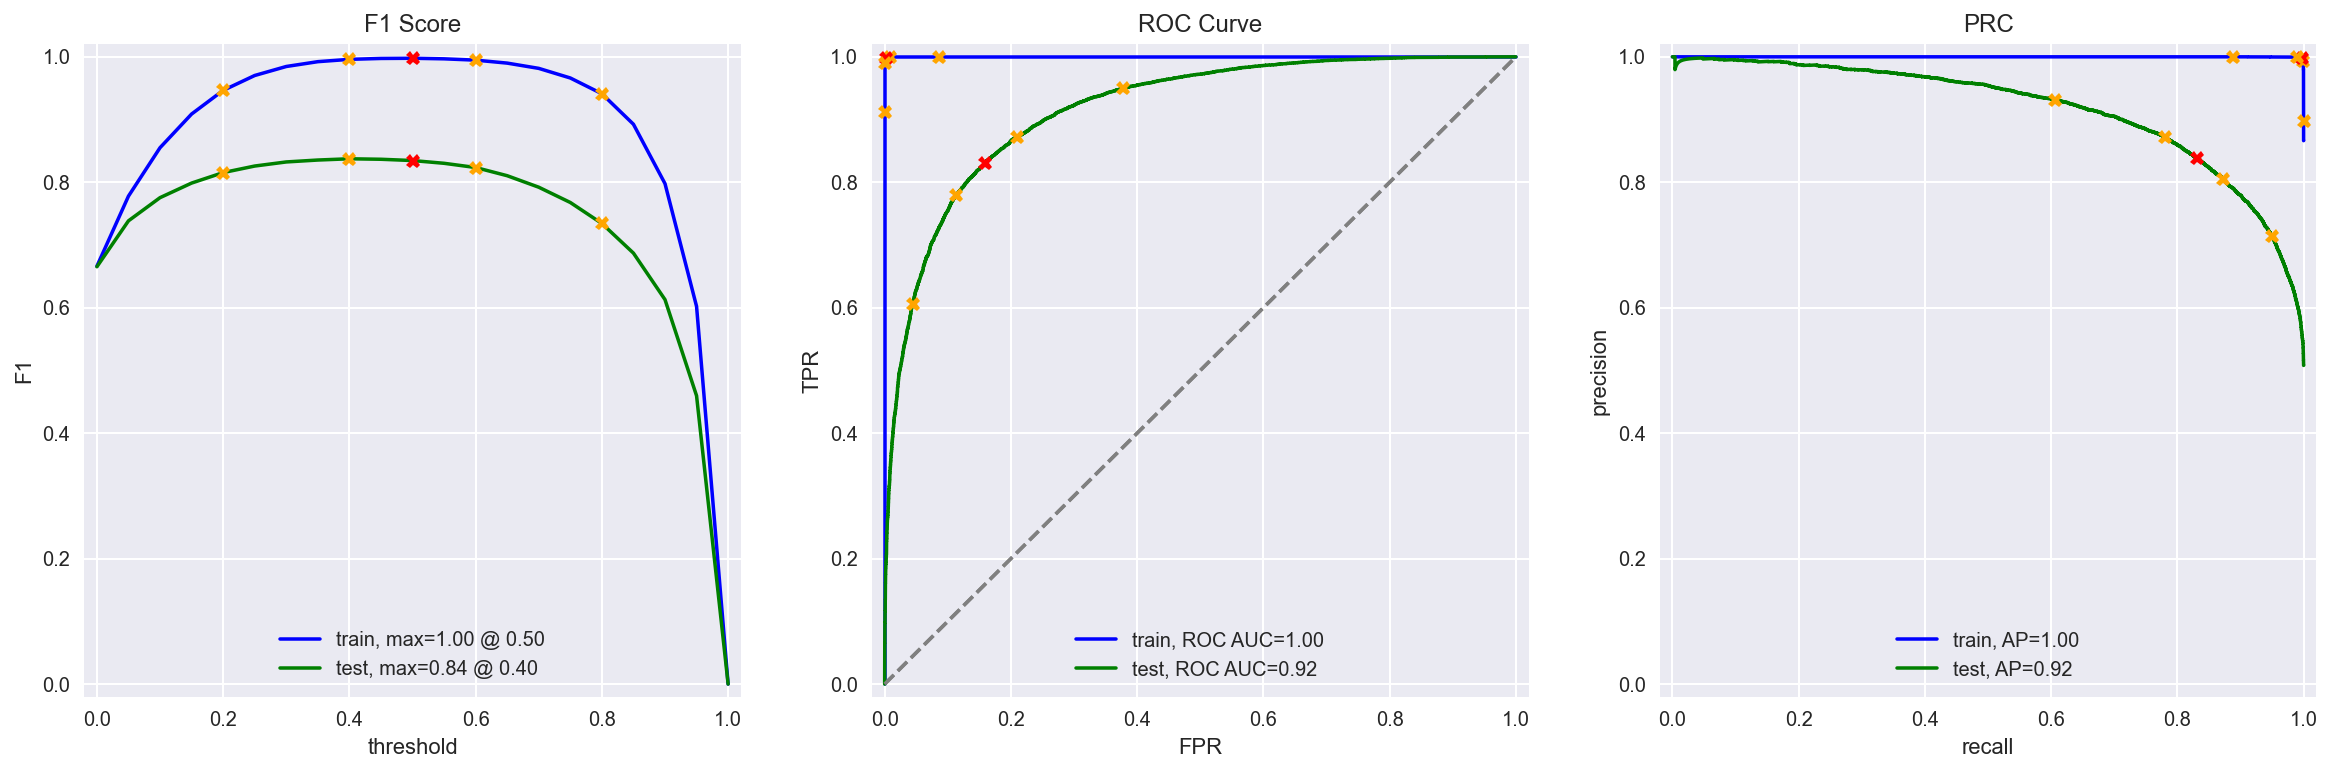

In [139]:
# evalutate the model
evaluate_model(model_4c2, train_features_4, train_y, test_features_4, test_y)

Unfortunately, the results show that overfitting seems to be even worse at this point. We get a perfect ROC curve for the training set, but the same 0.83 F1 score on the test set.

### Summary of models

We tried all kinds of different models:
* model_0:   A uniform dummy model (50:50 chance of predicting 0 or 1) as sanity check
* model_1a:  Features based on NLTK (stopwords) + TF-IDF and logistic regression model
* model_1b:  Features based on NLTK (stopwords + lemmatization) + TF-IDF and logistic regression model
* model_2:   Features based on spaCy (lemmatization) + TF-IDF and logistic regression model
* model_3:   Features based on spaCy (lemmatization) + TF-IDF and lightGBM classification model
* model_4a:  Features based on BERT embeddings and a logistic regression model
* model_4b:  Features based on BERT embeddings and a lightGBM model cross validated to tune 2 basic hyperparameters
* model_4c:  Features based on BERT embeddings and a lightGBM model with more hyperparameter tuning using Optuna
* model_4c2: Features based on BERT embeddings and a lightGBM model with more hyperparameter tuning using Optuna + cross validation

In the end, the results were surprising, as the highest F1 scores were acquired using the simplest features and classification models - the TF-IDF without lemmatization and a simple logistic regression model. It had a nice 0.94 F1 score on the training model (really tuned BERT-lightGBM models reached 0.99-1.00), and the best 0.88 F1 score on the test set (where the BERT-lightGBM models gave us 0.83). Still, we managed to beat the cutoff of 0.85 F1 score on the test set.

Let's now see how these models perform against entirely new text reviews.

## My Reviews

I wrote a few positive and negative reviews, let's see how our models stack up against these.

In [143]:
# 4 negative reviews followed by 4 positive reviews
my_reviews = pd.DataFrame([
    'This movie is boring, repetitive and has lousy humor. Don\'t waste your time.',
    'One more movie with high budget cast but poor story and realisation. I am tired of paying for this shit.',
    'I completely agree with the other person. I am very tired of all the netflix garbage.',    
    'The only reason this gets 1 star is because of the soundtrack! Don\'t wast your time on this effort!!!',
    'Loved it wish it was a 4 hour movie, Jamie Foxx can do no wrong. Was a all round awesome movie experience.',
    'Fantastic movie and great actor, haven\'t watched something so cool since bad boys 3. I recommend it. Snoop dogg is the best.',
    'Don\'t let these trash reviews stop you from watching this movie, it has nonstop action and laughter.',
    'This would make a cool and fun series. Action, comedy and horror. Win! The characters were fun. The story line keeps you interested.'
], columns=['review'])

# normalize reviews (remove anything not letters, and lower the case + remove leading, trailing and consecutive whitespaces)
my_reviews['review_norm'] = my_reviews['review'].str.replace(r'[^a-zA-Z]', ' ', regex=True).str.lower().str.strip().replace(r'\s+',' ', regex=True)

# print reviews
my_reviews

review  \
0  This movie is boring, repetitive and has lousy...   
1  One more movie with high budget cast but poor ...   
2  I completely agree with the other person. I am...   
3  The only reason this gets 1 star is because of...   
4  Loved it wish it was a 4 hour movie, Jamie Fox...   
5  Fantastic movie and great actor, haven't watch...   
6  Don't let these trash reviews stop you from wa...   
7  This would make a cool and fun series. Action,...   

                                         review_norm  
0  this movie is boring repetitive and has lousy ...  
1  one more movie with high budget cast but poor ...  
2  i completely agree with the other person i am ...  
3  the only reason this gets star is because of t...  
4  loved it wish it was a hour movie jamie foxx c...  
5  fantastic movie and great actor haven t watche...  
6  don t let these trash reviews stop you from wa...  
7  this would make a cool and fun series action c...

### Text vectorization

In [144]:
# collect texts
texts = my_reviews['review_norm']

# let's vectorize the texts appropriately
tfidf_1a = count_tf_idf.fit(df_reviews_train['review_norm'])
features_1a = count_tf_idf.transform(texts)
tfidf_1b = count_tf_idf.fit(df_reviews_train['review_norm_and_lemmatized_nltk'])
features_1b = count_tf_idf.transform(texts)
tfidf_2and3 = count_tf_idf.fit(df_reviews_train['review_norm_and_lemmatized_spacy'])
features_2and3 = count_tf_idf.transform(texts)
bert_4 = BERT_text_to_embeddings(texts)

Using the cpu device.


  0%|          | 0/1 [00:00<?, ?it/s]

### Function for testing the different models

In [152]:
# list of models
model_names = ['model_1a', 'model_1b', 'model_2', 'model_3', 'model_4a', 'model_4b', 'model_4c', 'model_4c2']

# list of models
model_objects = [model_1a, model_1b, model_2, model_3, model_4a, model_4b, model_4c, model_4c2]

# list of model features
model_features = [features_1a, features_1b, features_2and3, features_2and3, bert_4, bert_4, bert_4, bert_4]

# list of model average probabilities
model_proba = []

# function for testing models
def test_model(name, model, features):
    
    # print name of model being tested
    print(name)
    
    # predict probabilities
    my_reviews_pred_prob = model.predict_proba(features)[:, 1]
    
    # print probabilities for each of the texts
    for i, review in enumerate(texts.str.slice(0, 100)):
        print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
        
    # calculate average score for positive and for negative reviews
    neg_score = my_reviews_pred_prob[:3].mean()
    pos_score = my_reviews_pred_prob[4:].mean()
        
    print()
    
    return [neg_score, pos_score]

### Model results

In [153]:
# loop over all models and print their results with our new texts
for i in range(len(model_names)):
    model_proba.append(test_model(model_names[i], model_objects[i], model_features[i]))

model_1a
0.01:  this movie is boring repetitive and has lousy humor don t waste your time
0.15:  one more movie with high budget cast but poor story and realisation i am tired of paying for this sh
0.17:  i completely agree with the other person i am very tired of all the netflix garbage
0.27:  the only reason this gets star is because of the soundtrack don t wast your time on this effort
0.78:  loved it wish it was a hour movie jamie foxx can do no wrong was a all round awesome movie experienc
0.88:  fantastic movie and great actor haven t watched something so cool since bad boys i recommend it snoo
0.33:  don t let these trash reviews stop you from watching this movie it has nonstop action and laughter
0.90:  this would make a cool and fun series action comedy and horror win the characters were fun the story

model_1b
0.01:  this movie is boring repetitive and has lousy humor don t waste your time
0.15:  one more movie with high budget cast but poor story and realisation i am tired o

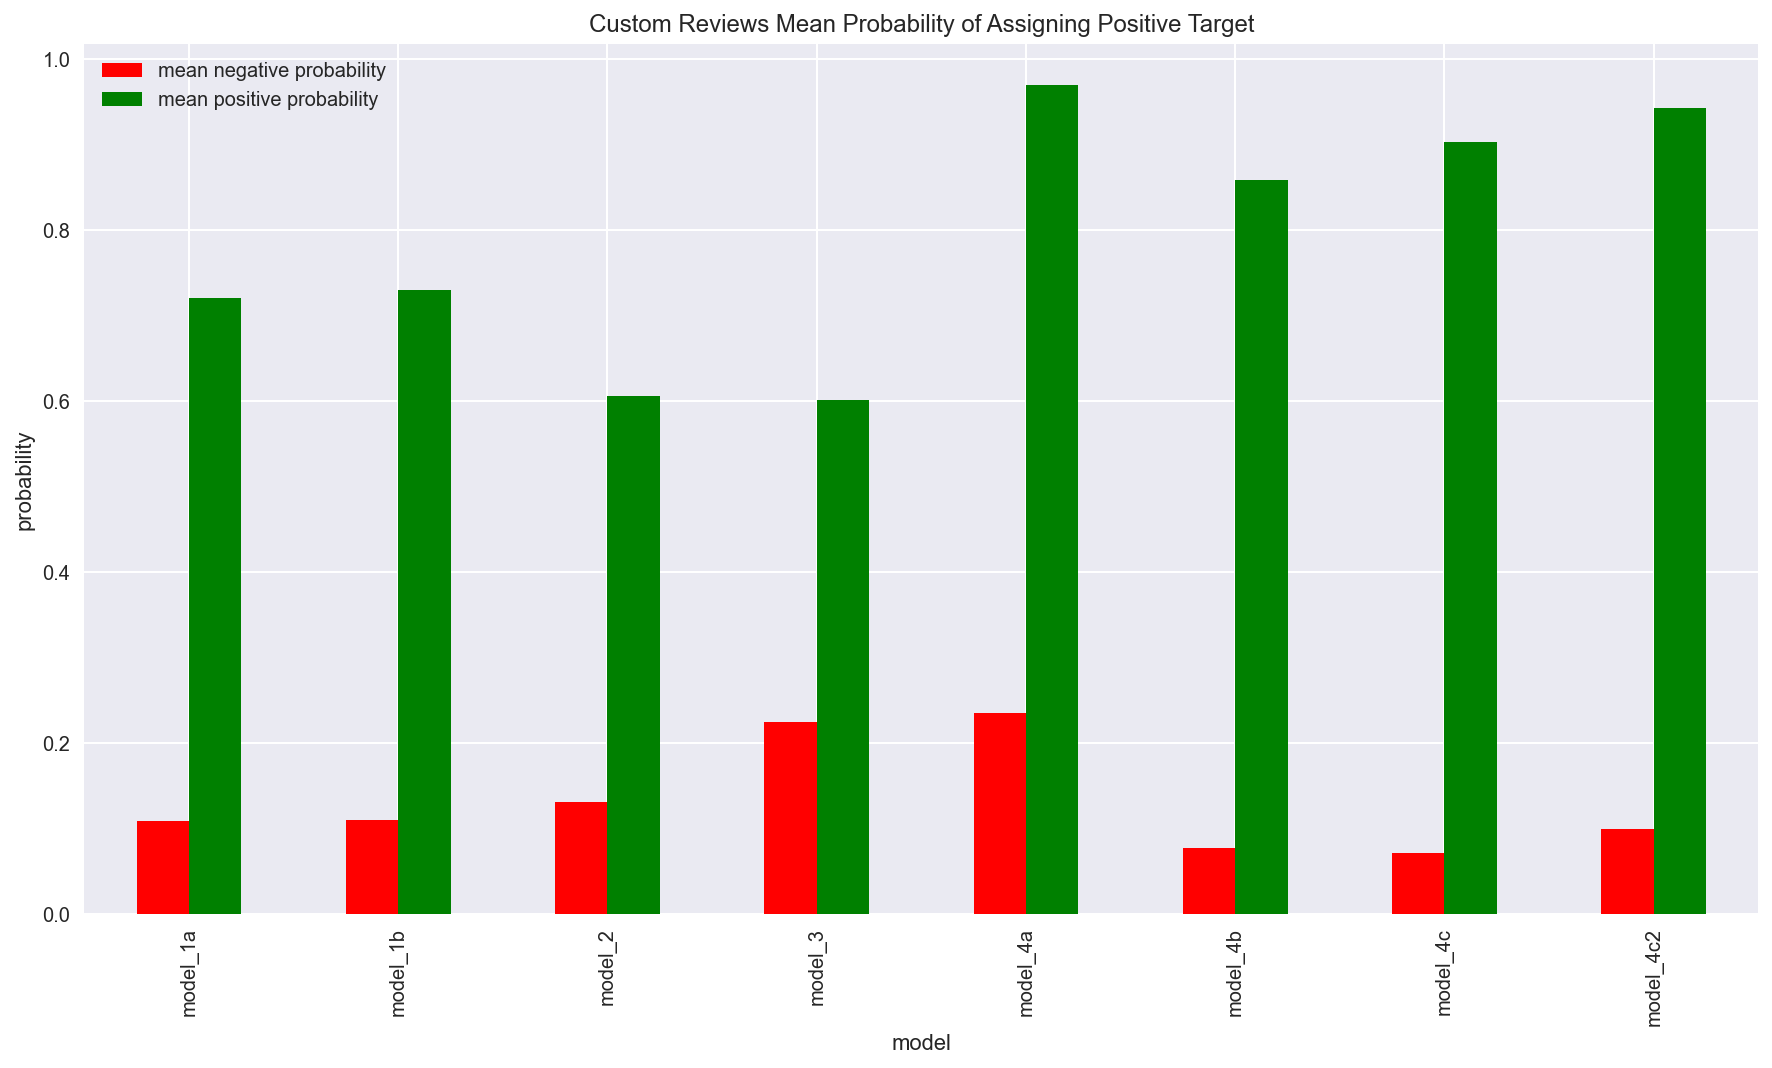

In [167]:
# change list into dataframe
models_df = pd.DataFrame(model_proba, columns=['mean negative probability', 'mean positive probability'])

# convert model names to dataframe as well
names_df = pd.DataFrame(model_names, columns=['model'])

# merge the two dataframes
models_df = names_df.merge(right=models_df, how='inner', left_index=True, right_index=True)

# output graph explaining the results
models_df.plot(kind='bar', x='model', y=['mean negative probability', 'mean positive probability'], figsize=(15,8), title='Custom Reviews Mean Probability of Assigning Positive Target', color=['red','green'])
plt.ylabel('probability');

Unlike in the test set, we can see better results here for the more complex models. The probability calculated here is the probability to be assigned a positive target value - a positive review. 

BERT embeddings obviously helped score the positive reviews as more positive than when using the NLTK and spaCy language models. In addition, the lowest "positive" scores for negative reviews were given to the BERT models as well.

So the best model in terms of our custom reviews is either model_4c or model_4c2 (BERT embeddings + Optuna tuned lightGBM classification), while the worst model was model_3 (spaCy + TF-IDF + lightly tuned lightGBM model).

## Conclusions

We managed to train 9 different models in the end, and while results were partially counter to my intuition, we found models that gave us an F1 score above the 0.85 threshold we were asked to pass. In general, the simpler models gave us better results, which might point to a problem with over-fitting which I tried to improve.

In the custom reviews, we can see that the models performed closer to what I was expecting. Some of the reviews I entered contain both negative and positive text. It is possible that the more advanced context aware BERT embeddings helped process these better which could explain the better scores. 

Obviously, there are other major differences between the train/test sets and my custom reviews. The given set were acquired from IMDB so are based on native English speakers reviews, and happen to have been collected several years ago (see EDA). Language changes over time, so I wasn't expecting the same kind of models to do well on what are in the end different kinds of texts.